# Waiting for changes:
- os fix for csv

- load margins from csv
- make h1 and h2 smaller?  (probably unnecessary until later)


# Changes
* print out the margin contributions

In [3]:
import os
from pathlib import Path
cwd = Path.cwd()
if "tmp" in str(cwd).lower():
    #put the directory of the folder that you want here!
    os.chdir("/mnt/smb/locker/abbott-locker/Luke/Nelli Reimplementation/10.16.25 - Reps_Margins/conjunctive_lazy_rich_1e-5_reps_margins_v2")
!pwd

/mnt/smb/locker/abbott-locker/Luke/Nelli Reimplementation/10.16.25 - Reps_Margins/conjunctive_lazy_rich_1e-5_reps_margins_v2


# Knowledge Assembly

In [4]:
# for nellinetworkconjunctive
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
grandparent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
greatgrandparent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, greatgrandparent_dir)
sys.path.insert(0, grandparent_dir)
sys.path.insert(0, parent_dir)  

from nellinetworkconjunctivev2 import Network
from helpers import fit_sigmoid, mean_squared_error, rotate, load_behavioural_data
from plotting import plotting_init, matrix_plot, mds_plot

import torch
import numpy as np
from scipy.special import expit
from sklearn import manifold
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool

## Load behavioural data

In [5]:
midd_performance, high_performers, low_performers = load_behavioural_data("../../behavioural-data/")

## Set simulation mode

In [6]:
mode = "main" # "lazy-regime", "two-readouts", "fixed-inputs"
mode2 = "main"

## Set Hyperparameters

In [7]:
# Random seeds
seeds_n = 1
mds_seed = 1

# Number of input items
items_n = 7

# Experiment details
training_blocks = 1
trials = 3000
training_length = training_blocks * trials
# stitching_steps = 20

# Network hyperparameters
readouts = 2 if mode == "two-readouts" else 1
h1_size = 20

if mode == "lazy-regime":
    w1_weight_std = np.sqrt(6. / items_n)
    w2_weight_std = np.sqrt(10. / h1_size)
else:
    w1_weight_std = 0.025 * np.sqrt(1 / items_n)
    w2_weight_std = np.sqrt(1 / h1_size)

proportion = 1e5    
    
if mode2 == "lazy-regime":
    w3_weight_std = np.sqrt(6. / items_n)
    w4_weight_std = np.sqrt(10. / h1_size)
else:
    w3_weight_std = 0.025 * np.sqrt(1 / items_n) / proportion
    w4_weight_std = np.sqrt(1 / h1_size) / proportion

learning_rate = 0.03 if mode == "lazy-regime" else 0.05
learning_rate_layers_3_4 = 0.05

# Parameter space for gridsearch
gammas = np.concatenate([[0], np.geomspace(1e-4, 1, 69)])
ss = np.geomspace(1e-2, 100, 65)

In [8]:
print(w1_weight_std)
print(w3_weight_std)

0.00944911182523068
9.44911182523068e-08


# TI Exp with conjunctive population

In [9]:
def train_networks_exp(gamma):
    # Log
    results = {
        "train": {
            "losses": np.zeros((seeds_n, training_length)),
            "w1s": np.zeros((seeds_n, training_length, h1_size, items_n)),
            "w2s": np.zeros((seeds_n, training_length, readouts, h1_size)),
            "h1s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "h2s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "r1s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "r2s": np.zeros((seeds_n, training_length, items_n, h1_size)), 
            "certainties": np.zeros((seeds_n, training_length, items_n, items_n)),
            "evals": np.zeros((seeds_n, items_n, items_n)),
        },
    }
    
    results["train"]["training_progress"] = np.zeros((seeds_n, training_length, items_n, items_n))
    
    for seed in range(seeds_n):
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Init Network
        model = Network(items_n, h1_size, w1_weight_std, w2_weight_std, w3_weight_std, w4_weight_std, readouts=readouts)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.SGD([
            {'params': [*model.layer_1.parameters(), *model.layer_2.parameters()], 'lr': learning_rate},
            {'params': [*model.layer_3.parameters(), *model.layer_4.parameters()], 'lr': learning_rate_layers_3_4}
        ])

        training_step = 0
        items_per_context = items_n
        
        for block in range(training_blocks): 
            items_per_context = 7
            p = 4
            q = 2
            training_pairs_norm = np.asarray(list(zip(range(0, items_per_context - 1), range(1, items_per_context))))
            training_pairs_exp = np.asarray([[p,q]])
            training_pairs = np.concatenate([training_pairs_norm, training_pairs_exp], axis=0)
            for trial in range(trials):
                # Sample input and target
                random_index = np.random.randint(0, len(training_pairs))
                item_1, item_2 = np.random.choice(training_pairs[random_index], 2, False)
                if readouts == 1:
                    if item_1 == p and item_2 == q or item_1 == q and item_2 == p:
                        exception = True
                    else:
                        exception = False
                    if not exception:
                        target = torch.tensor([1. if item_1 > item_2 else -1.])
                    else:
                        target = torch.tensor([-1. if item_1 > item_2 else 1.])

                #UNCHANGED SO FAR
                elif readouts == 2:
                    target = torch.tensor([1., -1.] if item_1 > item_2 else [-1., 1.])


                # Forward propagate and backpropagate
                optimiser.zero_grad()
                _, output = model(item_1, item_2)
                model.loss = criterion(output, target)
                model.loss.backward()
                model.correct(learning_rate, gamma)
                optimiser.step()

                # Log
                with torch.no_grad():
                    results["train"]["losses"][seed, training_step] = model.loss.item()
                    results["train"]["w1s"][seed, training_step] = model.layer_1.weight.detach().numpy().copy()
                    results["train"]["w2s"][seed, training_step] = model.layer_2.weight.detach().numpy().copy()
                    results["train"]["h1s"][seed, training_step] = model.extract_h1s()
                    results["train"]["h2s"][seed, training_step] = model.extract_h2s()
                    results["train"]["r1s"][seed, training_step] = model.extract_r1s()
                    results["train"]["r2s"][seed, training_step] = model.extract_r2s()
                    results["train"]["certainties"][seed, training_step] = model.pairwise_certainty.a.copy()
                    results["train"]["training_progress"][seed, training_step] = model.evaluate()
                
                training_step += 1
        
        # Evaluate
        with torch.no_grad():
            results["train"]["evals"][seed] = model.evaluate()
        
    return gamma, results

In [ ]:
results = train_networks_exp(.1)

KeyboardInterrupt: 

# Check the convergence

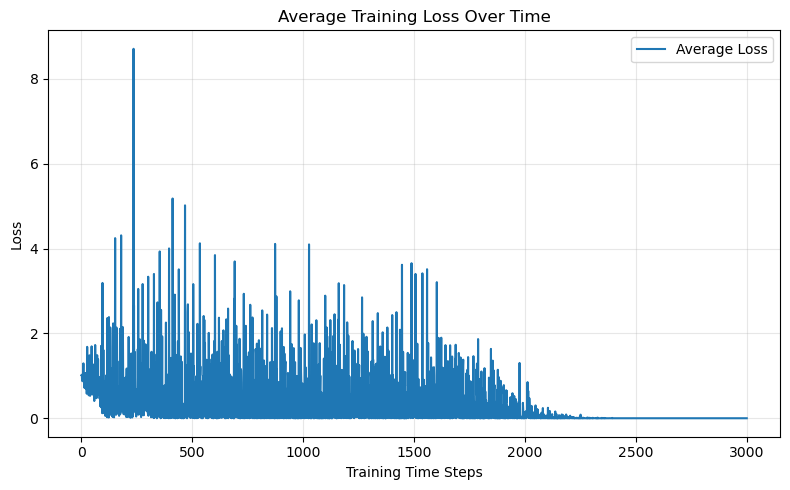

In [ ]:
import matplotlib.pyplot as plt

# Plot the average loss across all seeds during training
if isinstance(results, tuple):
    results = results[1]
losses = results["train"]["losses"]  # shape: (seeds_n, training_steps)
avg_loss = losses.mean(axis=0)
plt.figure(figsize=(8, 5))
plt.plot(avg_loss, label='Average Loss')
plt.xlabel("Training Time Steps")
plt.ylabel("Loss")
plt.title("Average Training Loss Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


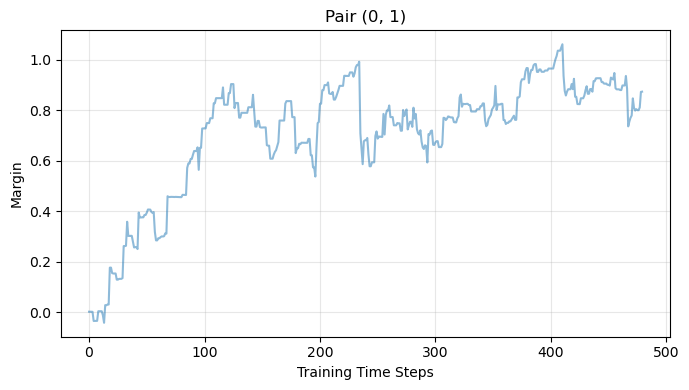

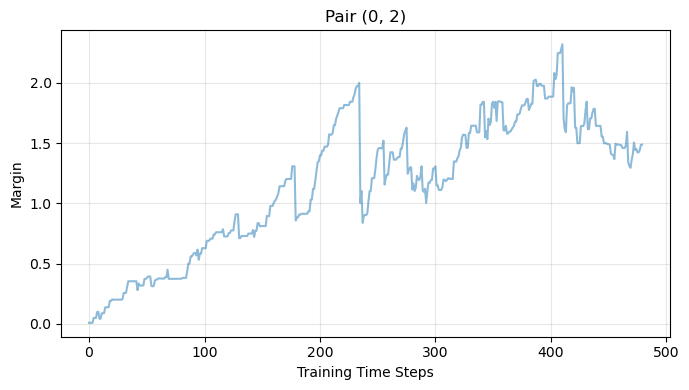

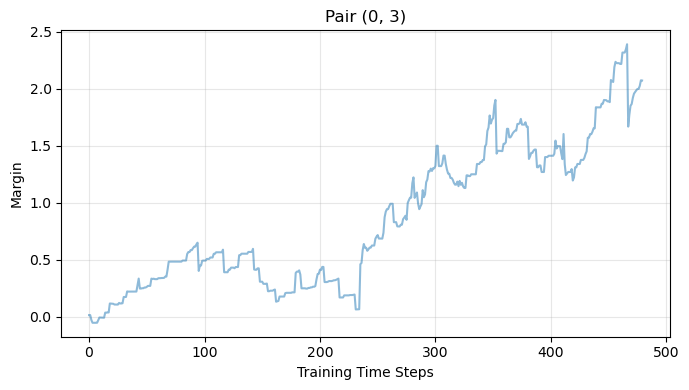

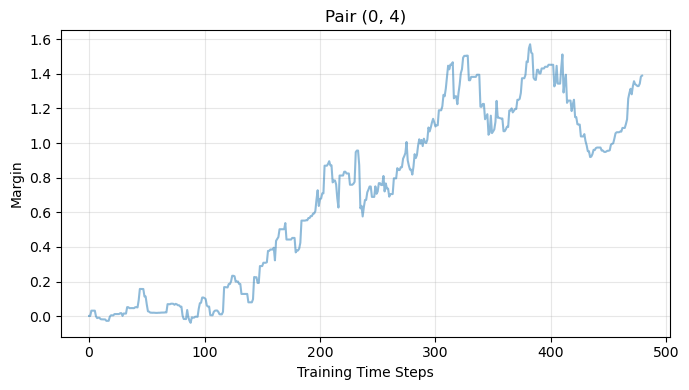

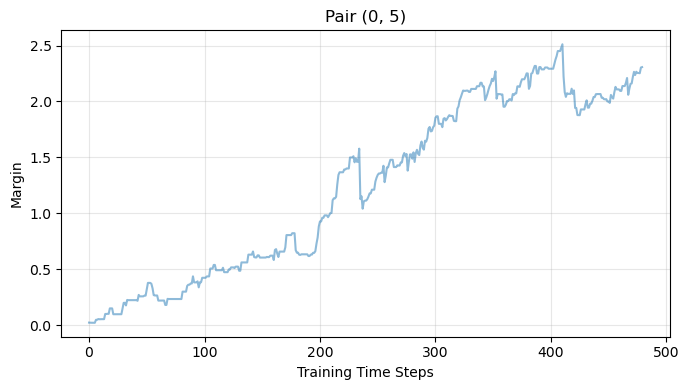

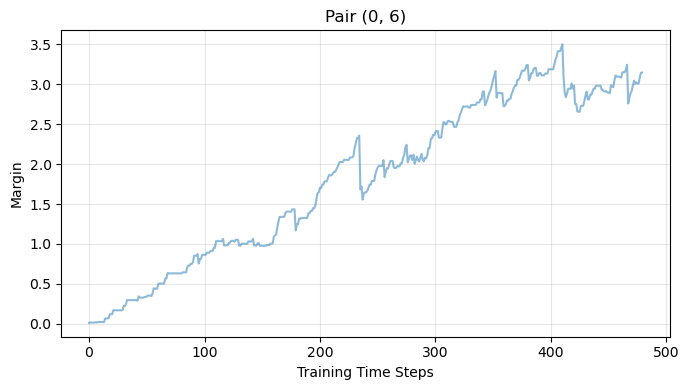

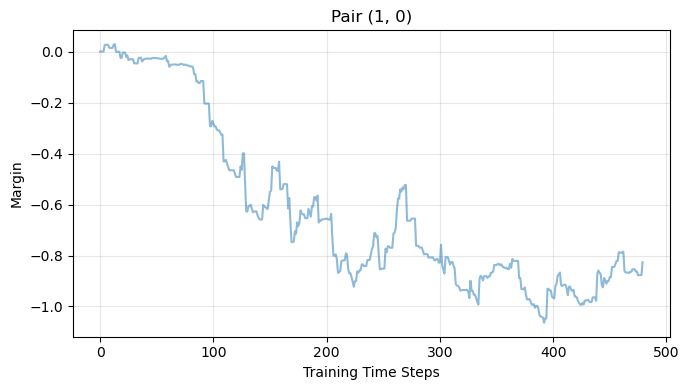

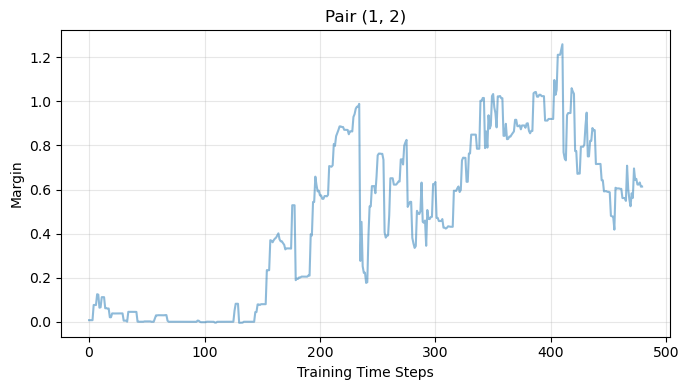

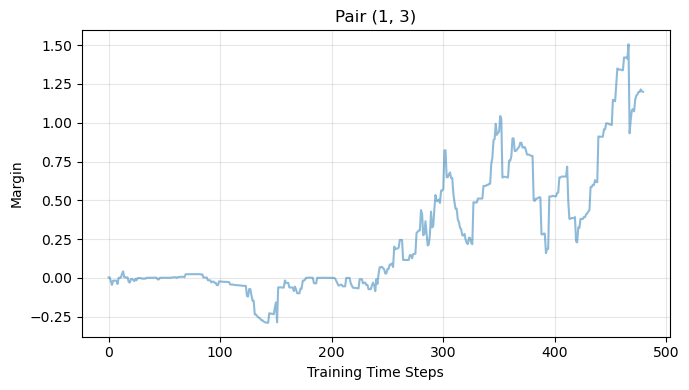

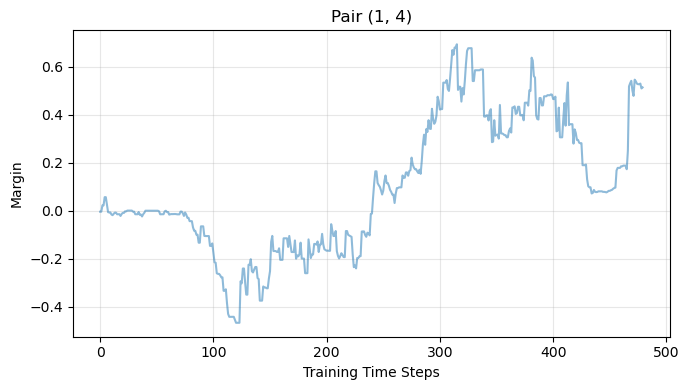

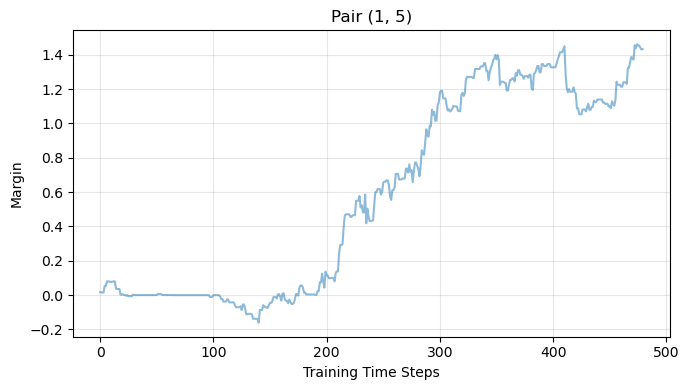

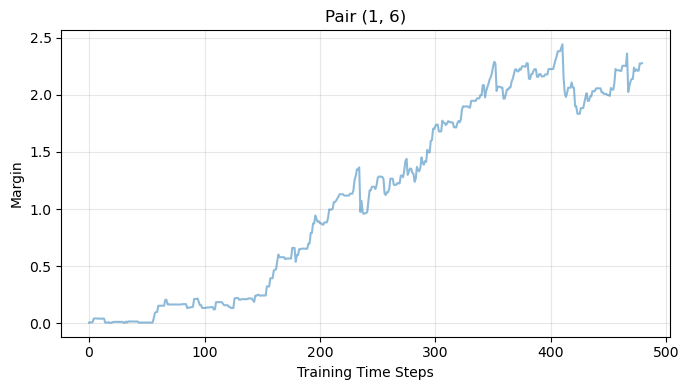

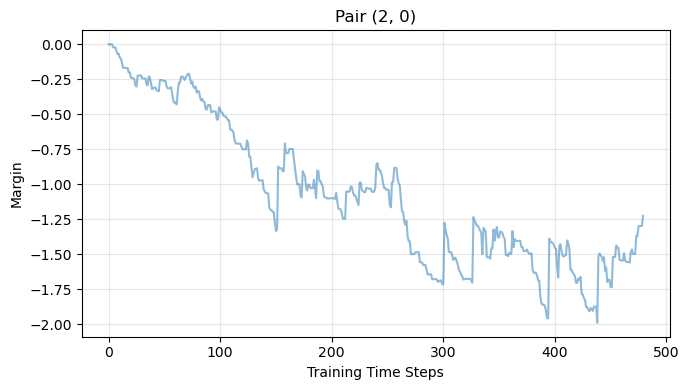

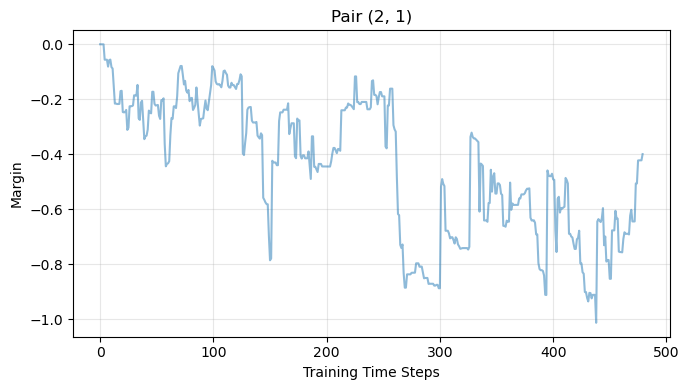

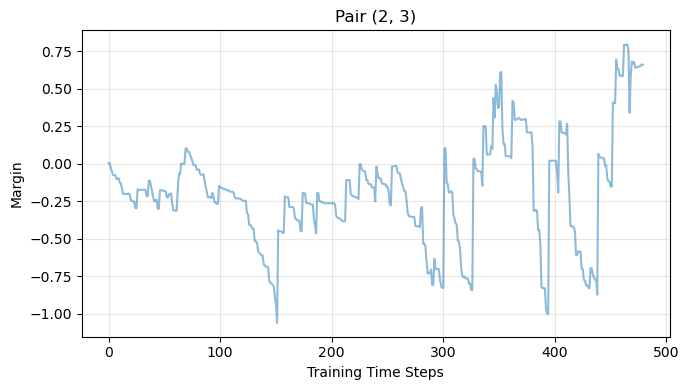

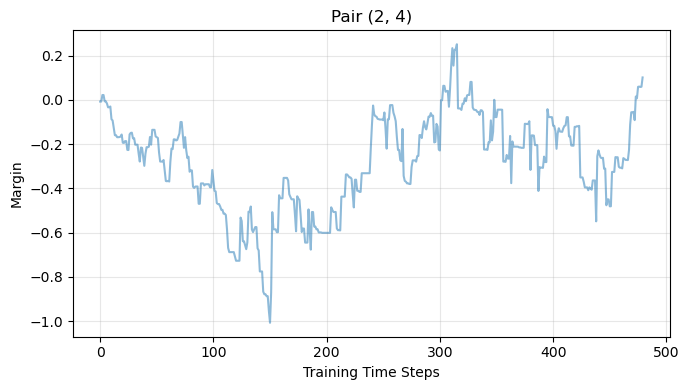

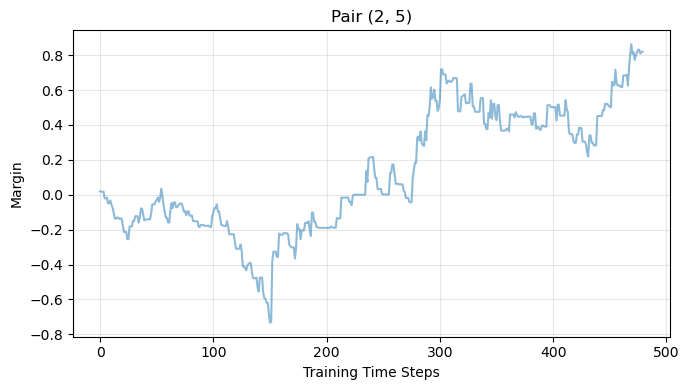

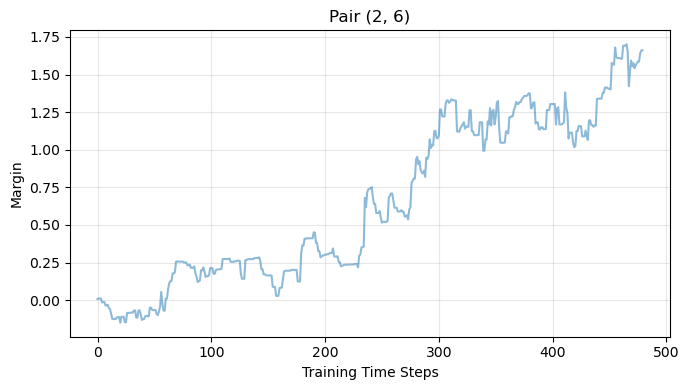

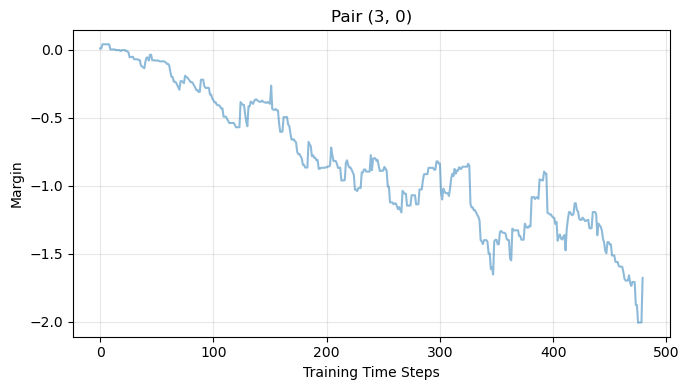

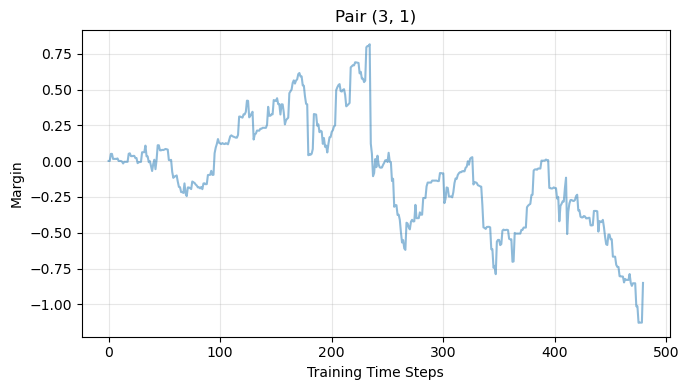

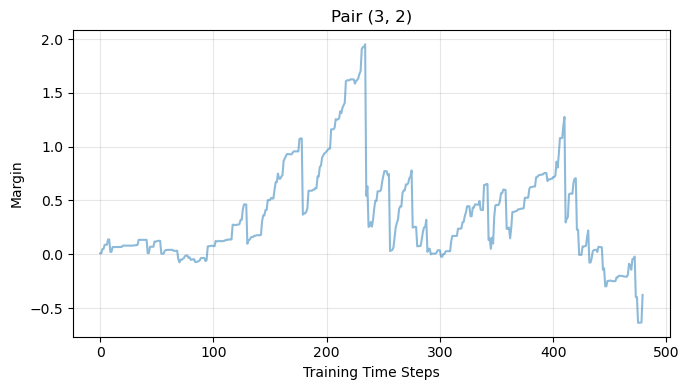

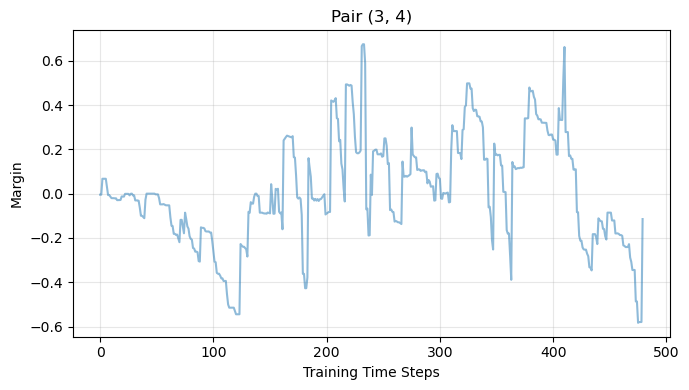

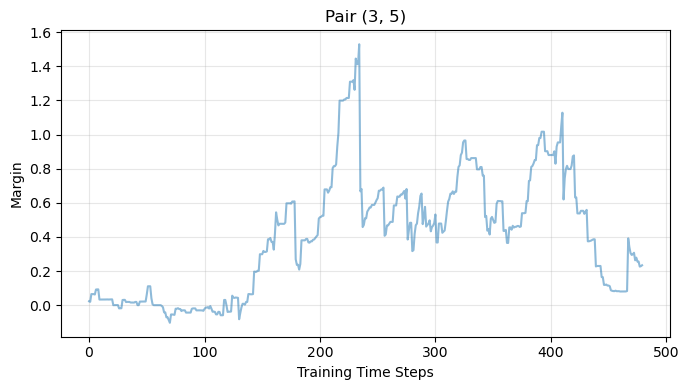

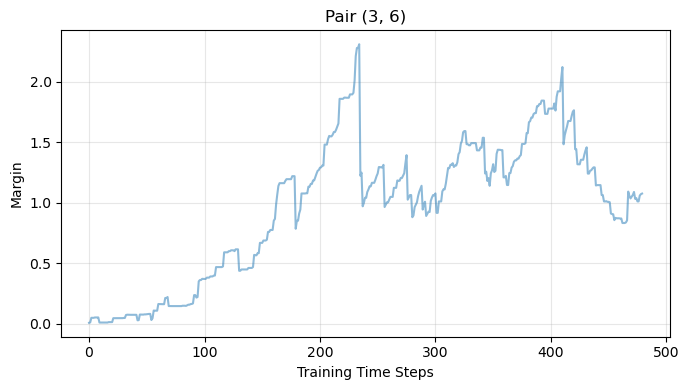

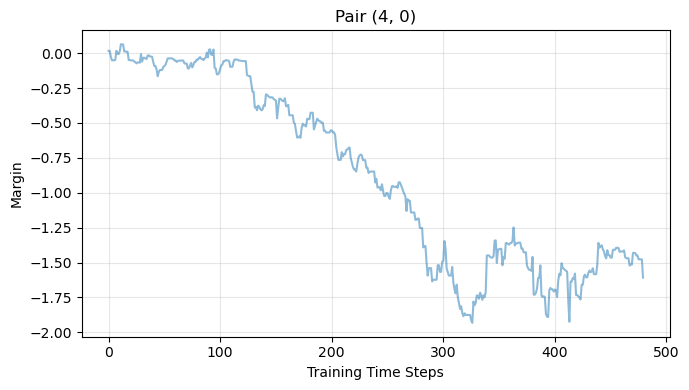

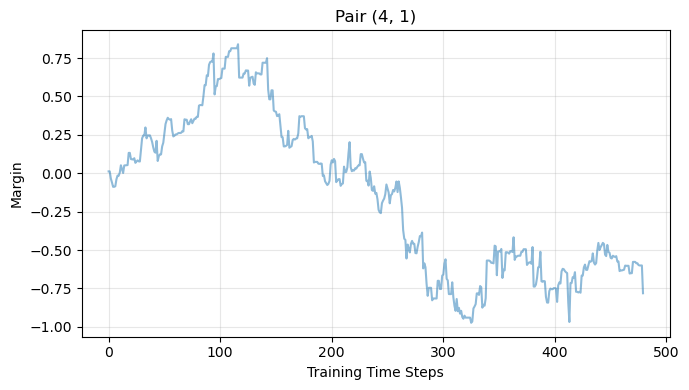

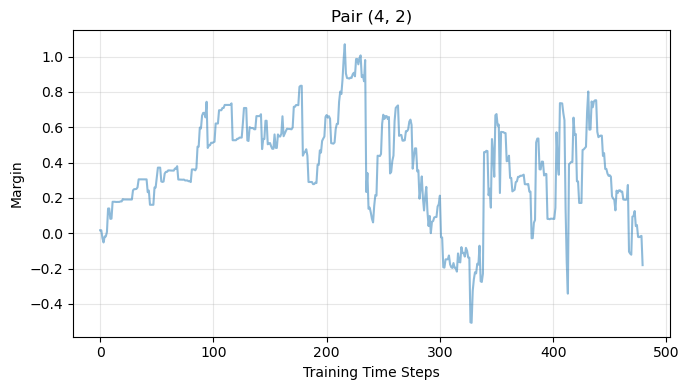

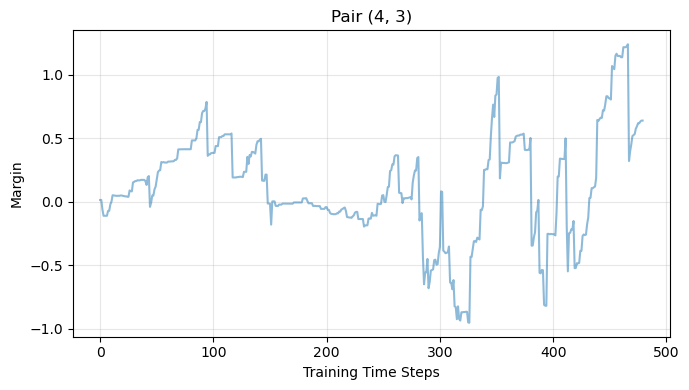

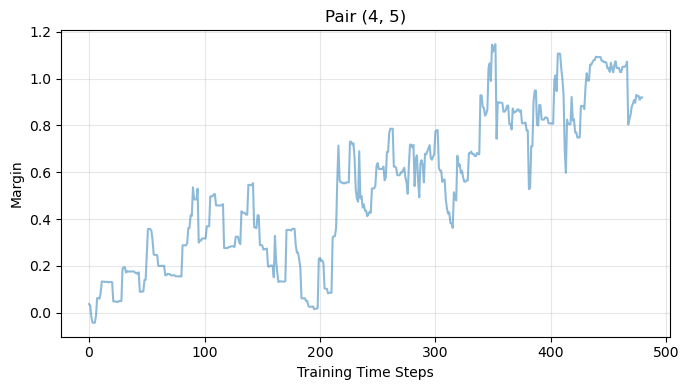

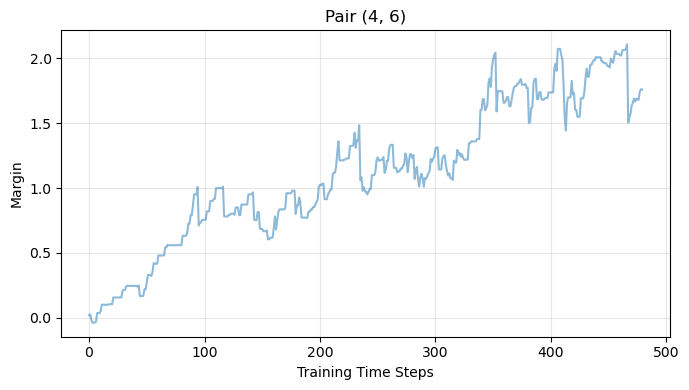

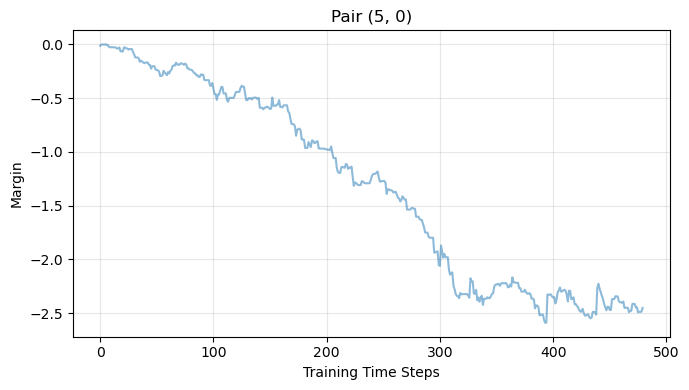

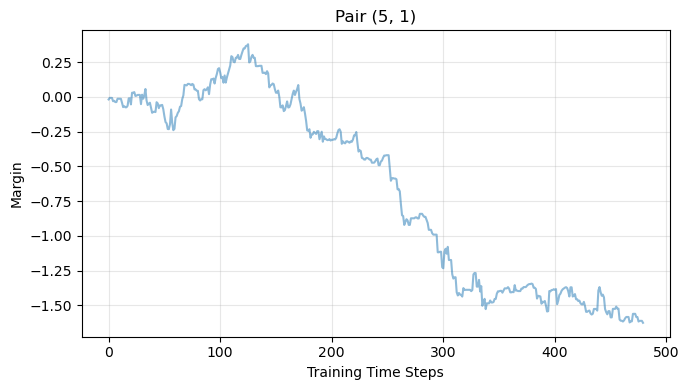

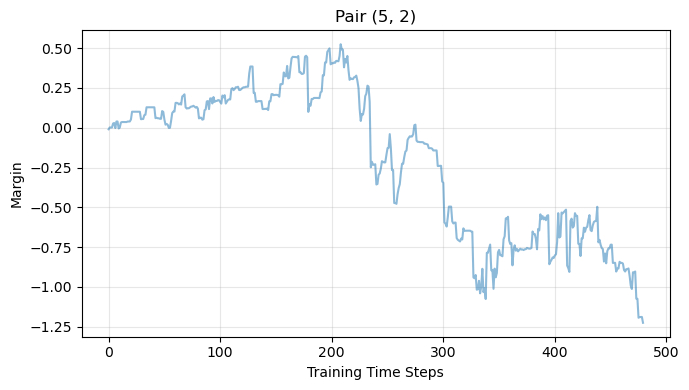

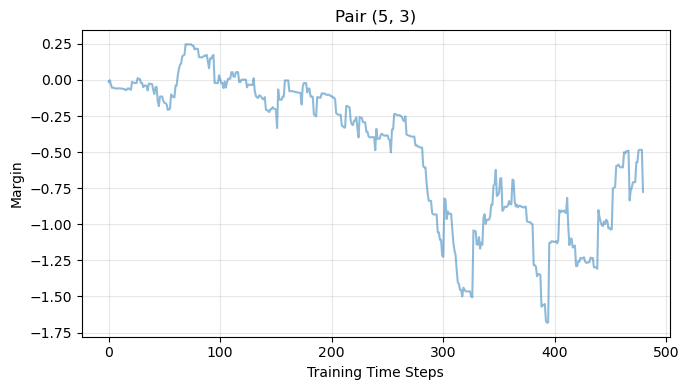

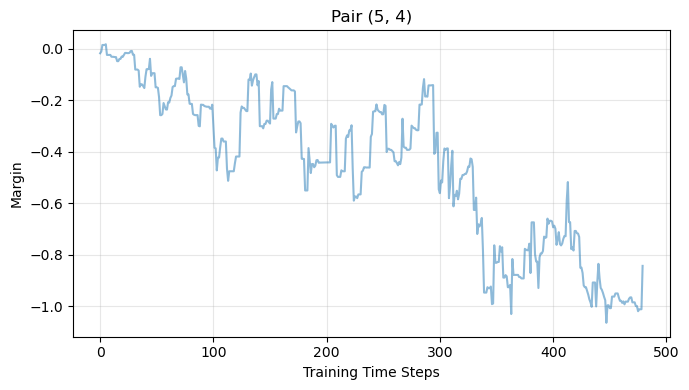

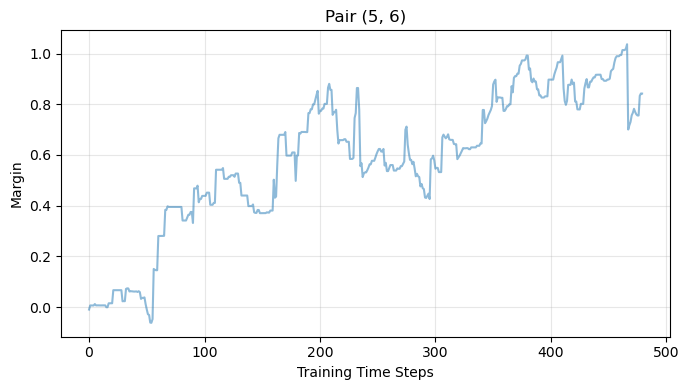

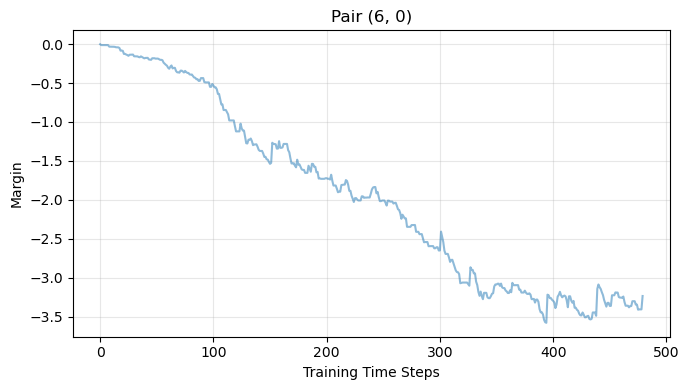

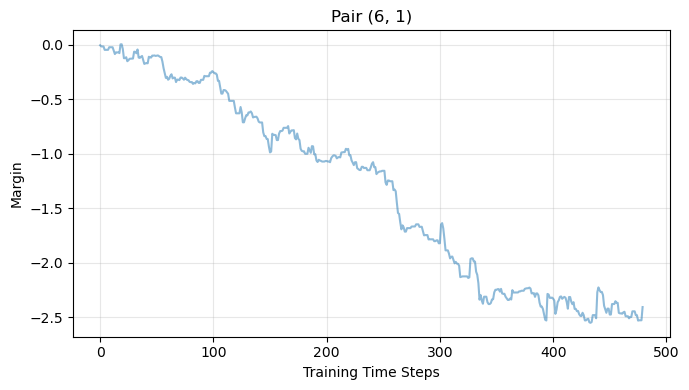

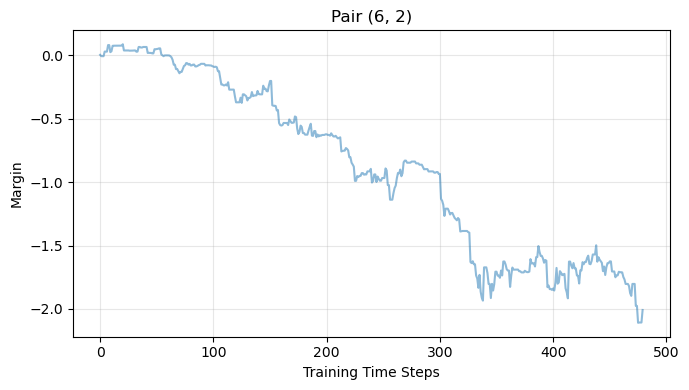

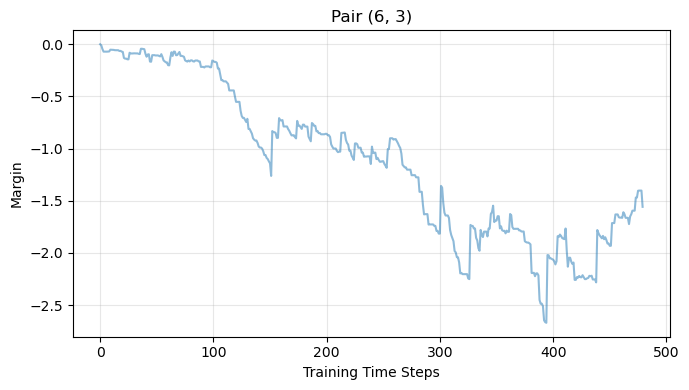

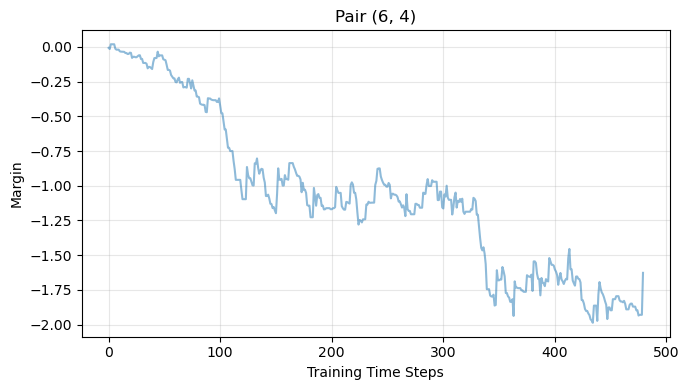

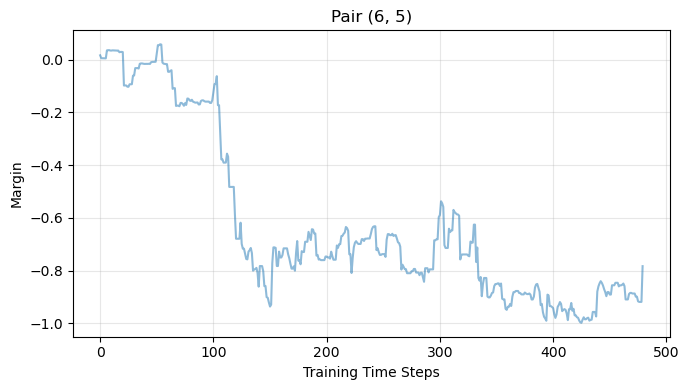

In [ ]:
# Plot for every possible pair (i, j) in different figures
# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
training_progress = results["train"]["training_progress"]
seeds_n = training_progress.shape[0]
items_n = training_progress.shape[2]

for i in range(items_n):
    for j in range(items_n):
        if i == j:
            continue  # skip diagonal if desired
        plt.figure(figsize=(7,4))
        for seed in range(seeds_n):
            plt.plot(training_progress[seed, :480, i, j], alpha=0.5)
        plt.xlabel("Training Time Steps")
        plt.ylabel("Margin")
        plt.title(f"Pair ({i}, {j})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

Average margin grid (across seeds and final time):
[[-1.05042115e-03  9.99013543e-01  1.48609853e+00  1.72174990e+00
   1.51547623e+00  2.81844544e+00  3.80688047e+00]
 [-9.89854753e-01  6.99640310e-04  9.94534969e-01  5.51813900e-01
   4.81914043e-01  1.80517542e+00  2.79662561e+00]
 [-2.98570871e+00 -9.97796059e-01 -9.22510743e-01  9.97805715e-01
  -1.00115895e+00  4.83841300e-01  1.44858003e+00]
 [-1.73989749e+00 -9.37994897e-01 -1.00086856e+00  1.52880587e-02
   9.99004364e-01  1.04447114e+00  2.05234408e+00]
 [-1.28787827e+00 -2.85583615e-01  1.00060534e+00 -1.00072038e+00
  -7.36064553e-01  9.96270180e-01  1.48841977e+00]
 [-2.50114107e+00 -1.52776897e+00 -4.28822935e-01 -7.92537928e-01
  -9.98675287e-01  1.94564331e-02  9.99211729e-01]
 [-3.54719400e+00 -2.53832269e+00 -1.48011410e+00 -1.79602456e+00
  -3.11003876e+00 -9.95603859e-01 -7.49434531e-03]]


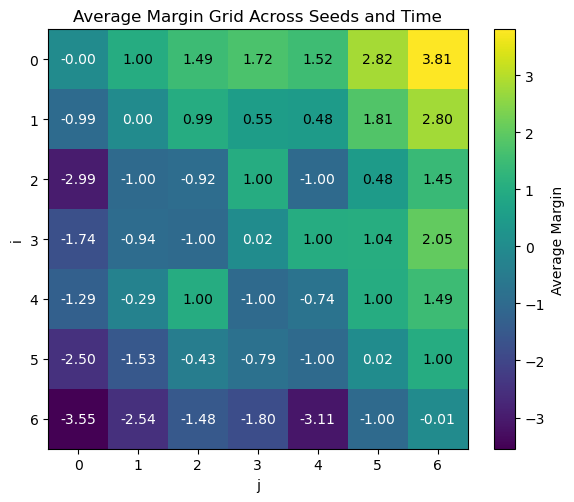

In [ ]:
# Compute the average margin across seeds and time for each (i, j) pair
# Resulting in a grid of shape (items_n, items_n)
t_final = training_progress.shape[1] - 1
average_margin_grid = training_progress[:, t_final, :, :].mean(axis=0)
print("Average margin grid (across seeds and final time):")
print(average_margin_grid)

# Plot the average margin grid as a heatmap with values over each rectangle
plt.figure(figsize=(6, 5))
im = plt.imshow(average_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im, label="Average Margin")
plt.xlabel("j")
plt.ylabel("i")
plt.title("Average Margin Grid Across Seeds and Time")

# Add values in each cell
for i in range(average_margin_grid.shape[0]):
    for j in range(average_margin_grid.shape[1]):
        value = average_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()

Corrected average margin grid:
[[-1.05042115e-03  9.99013543e-01  1.48609853e+00  1.72174990e+00
   1.51547623e+00  2.81844544e+00  3.80688047e+00]
 [ 9.89854753e-01  6.99640310e-04  9.94534969e-01  5.51813900e-01
   4.81914043e-01  1.80517542e+00  2.79662561e+00]
 [ 2.98570871e+00  9.97796059e-01 -9.22510743e-01  9.97805715e-01
   1.00115895e+00  4.83841300e-01  1.44858003e+00]
 [ 1.73989749e+00  9.37994897e-01  1.00086856e+00  1.52880587e-02
   9.99004364e-01  1.04447114e+00  2.05234408e+00]
 [ 1.28787827e+00  2.85583615e-01  1.00060534e+00  1.00072038e+00
  -7.36064553e-01  9.96270180e-01  1.48841977e+00]
 [ 2.50114107e+00  1.52776897e+00  4.28822935e-01  7.92537928e-01
   9.98675287e-01  1.94564331e-02  9.99211729e-01]
 [ 3.54719400e+00  2.53832269e+00  1.48011410e+00  1.79602456e+00
   3.11003876e+00  9.95603859e-01 -7.49434531e-03]]


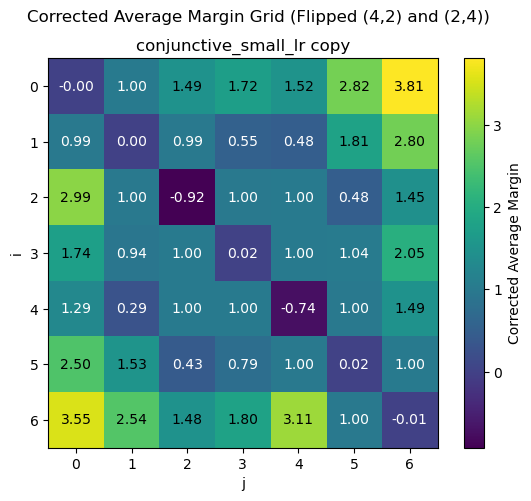

In [ ]:
# Create a "correct" average margin grid where (4,2) and (2,4) entries are multiplied by -1, as well as if i>j
correct_margin_grid = average_margin_grid.copy()
correct_margin_grid[4, 2] *= -1
correct_margin_grid[2, 4] *= -1
for i in range(correct_margin_grid.shape[0]):
    for j in range(correct_margin_grid.shape[1]):
        if i>j and ( (i != 2 and j != 4) or (i != 4 and j != 2) ):
            correct_margin_grid[i,j] *= -1

print("Corrected average margin grid:")
print(correct_margin_grid)

# Plot the corrected average margin grid as a heatmap with values over each rectangle
plt.figure(figsize=(6, 5))
im_correct = plt.imshow(correct_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im_correct, label="Corrected Average Margin")
plt.xlabel("j")
plt.ylabel("i")
plt.suptitle("Corrected Average Margin Grid (Flipped (4,2) and (2,4))")
plt.title("conjunctive_small_lr copy")

# Add values in each cell
for i in range(correct_margin_grid.shape[0]):
    for j in range(correct_margin_grid.shape[1]):
        value = correct_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im_correct.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()



Sigmoid of corrected average margin grid:
[[0.49973739 0.73086459 0.81549196 0.8483541  0.81987137 0.94366448
  0.9782655 ]
 [0.72905923 0.50017491 0.72998273 0.63455633 0.61819975 0.85877777
  0.94249321]
 [0.9519243  0.73062504 0.28444659 0.73062694 0.73128638 0.61865453
  0.8097798 ]
 [0.85067404 0.71869446 0.73122931 0.50382194 0.73086278 0.73971179
  0.88618426]
 [0.78378785 0.57091459 0.73117758 0.73120019 0.32386532 0.73032462
  0.81584097]
 [0.92422177 0.82167965 0.60559256 0.68837601 0.73079804 0.50486395
  0.73090357]
 [0.97200116 0.92678509 0.81458981 0.85766432 0.95730494 0.73019337
  0.49812642]]


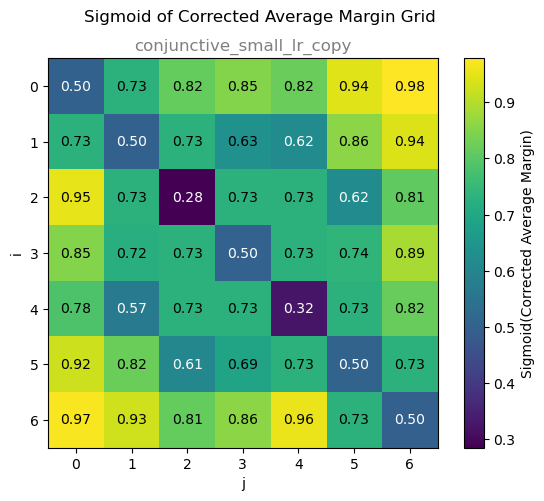

In [ ]:
# Compute the sigmoid of the corrected average margin grid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid_correct_margin_grid = sigmoid(correct_margin_grid)

print("Sigmoid of corrected average margin grid:")
print(sigmoid_correct_margin_grid)

# Plot the sigmoid margin grid as a heatmap with values in each cell
plt.figure(figsize=(6, 5))
im_sigmoid_correct = plt.imshow(sigmoid_correct_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im_sigmoid_correct, label="Sigmoid(Corrected Average Margin)")
plt.xlabel("j")
plt.ylabel("i")
plt.suptitle("Sigmoid of Corrected Average Margin Grid")
plt.title("conjunctive_small_lr_copy", color='gray')

# Add values in each cell
for i in range(sigmoid_correct_margin_grid.shape[0]):
    for j in range(sigmoid_correct_margin_grid.shape[1]):
        value = sigmoid_correct_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im_sigmoid_correct.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()


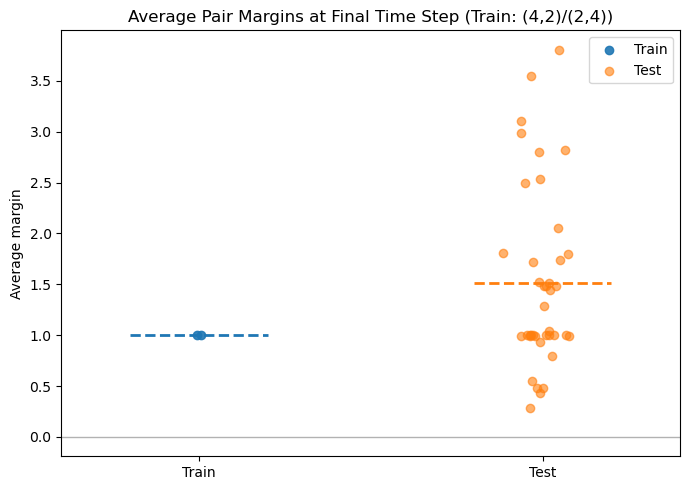

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set your training pair (ensure p, q are defined as desired)
p, q = 4, 2

items_n = correct_margin_grid.shape[0]

# Masks: only (p,q) and (q,p) are training; test = all other off-diagonals
non_diag = ~np.eye(items_n, dtype=bool)
train_mask = np.zeros((items_n, items_n), dtype=bool)
train_mask[p, q] = True
train_mask[q, p] = True
test_mask = non_diag & ~train_mask

train_vals = correct_margin_grid[train_mask]
test_vals = correct_margin_grid[test_mask]

# Jittered x-positions for scatter
rng = np.random.default_rng(0)
x_train = rng.normal(loc=0, scale=0.05, size=train_vals.size)
x_test  = rng.normal(loc=1, scale=0.05, size=test_vals.size)

plt.figure(figsize=(7, 5))
plt.scatter(x_train, train_vals, color='C0', alpha=0.9, label='Train')
plt.scatter(x_test,  test_vals,  color='C1', alpha=0.6, label='Test')

# Optional: overlay means
plt.hlines(train_vals.mean(), -0.2, 0.2, colors='C0', linestyles='--', linewidth=2)
plt.hlines(test_vals.mean(),  0.8,  1.2, colors='C1', linestyles='--', linewidth=2)

plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('Average margin')
plt.title(f'Average Pair Margins at Final Time Step (Train: ({p},{q})/({q},{p}))')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.4, 1.4)
plt.legend()
plt.tight_layout()
plt.show()

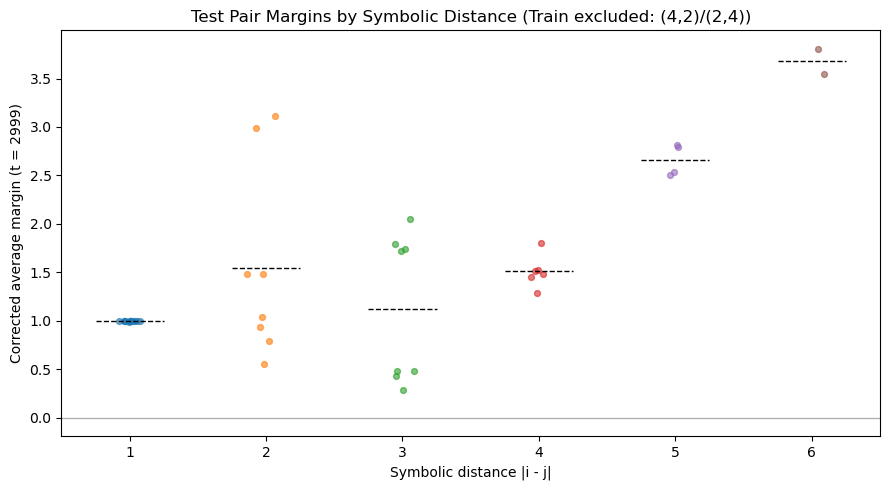

In [ ]:
# Scatter of TEST pair margins grouped by symbolic distance |i - j|
# Assumes: correct_margin_grid, t_final, p, q are defined as above

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

# Exclude diagonal and training pair (p,q)/(q,p)
non_diag = ~np.eye(items_n, dtype=bool)
train_mask = np.zeros((items_n, items_n), dtype=bool)
train_mask[p, q] = True
train_mask[q, p] = True
test_mask = non_diag & ~train_mask

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

for d in range(1, items_n):
    vals = correct_margin_grid[(dist_mat == d) & test_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, label=None)
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

plt.xticks(range(1, items_n), [str(d) for d in range(1, items_n)])
plt.xlabel('Symbolic distance |i - j|')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title(f'Test Pair Margins by Symbolic Distance (Train excluded: ({p},{q})/({q},{p}))')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(0.5, items_n - 0.5)
plt.tight_layout()
plt.show()

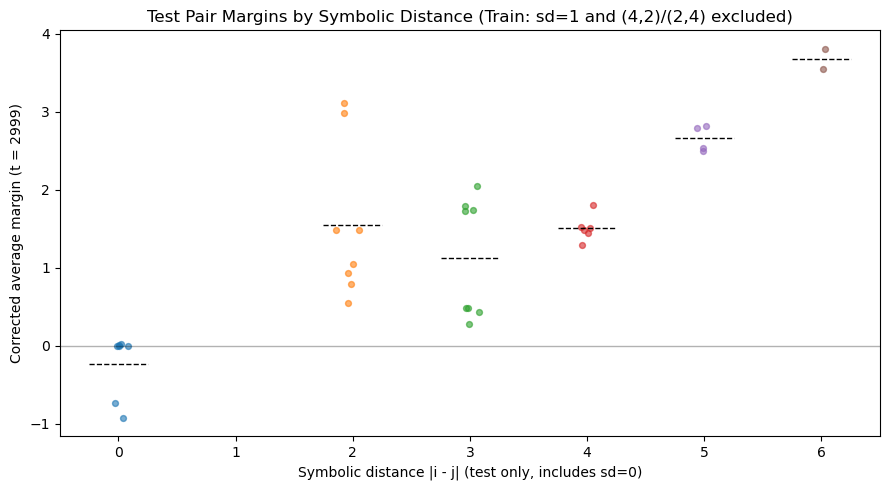

In [ ]:
# Scatter of TEST pair margins grouped by symbolic distance |i - j|, including sd=0
# Assumes: correct_margin_grid, t_final, p, q are defined

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

# Training = all sd==1 pairs + the special pair (p,q)/(q,p)
training_mask = (dist_mat == 1)
training_mask[p, q] = True
training_mask[q, p] = True

# Test = everything else (including diagonal sd=0)
test_mask = ~training_mask

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

for d in range(0, items_n):
    vals = correct_margin_grid[(dist_mat == d) & test_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18)
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (test only, includes sd=0)')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title(f'Test Pair Margins by Symbolic Distance (Train: sd=1 and ({p},{q})/({q},{p}) excluded)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.tight_layout()
plt.show()

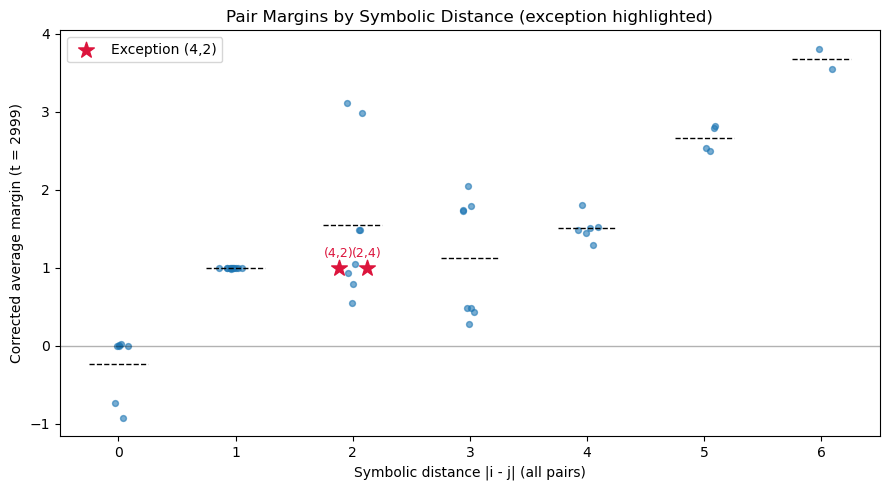

In [ ]:
# Scatter of pair margins by symbolic distance |i - j| (including sd=0),
# highlighting the exception pair (p,q)/(q,p) with a distinct color and label.

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

# Exclude the exception pair from the base scatter to avoid duplicate markers
base_mask = np.ones_like(dist_mat, dtype=bool)
base_mask[p, q] = False
base_mask[q, p] = False

# Plot all pairs grouped by symbolic distance (including sd=0 and sd=1)
for d in range(0, items_n):
    vals = correct_margin_grid[(dist_mat == d) & base_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, color='C0')
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

# Highlight the exception pair (p,q) and (q,p) at their symbolic distance
d_exc = abs(p - q)
y_pq = correct_margin_grid[p, q]
y_qp = correct_margin_grid[q, p]
plt.scatter(d_exc - 0.12, y_pq, color='crimson', marker='*', s=140, zorder=5, label=f'Exception ({p},{q})')
plt.scatter(d_exc + 0.12, y_qp, color='crimson', marker='*', s=140, zorder=5)

# Annotate the exception points
plt.annotate(f'({p},{q})', (d_exc - 0.12, y_pq), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)
plt.annotate(f'({q},{p})', (d_exc + 0.12, y_qp), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (all pairs)')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title('Pair Margins by Symbolic Distance (exception highlighted)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.legend()
plt.tight_layout()
plt.show()

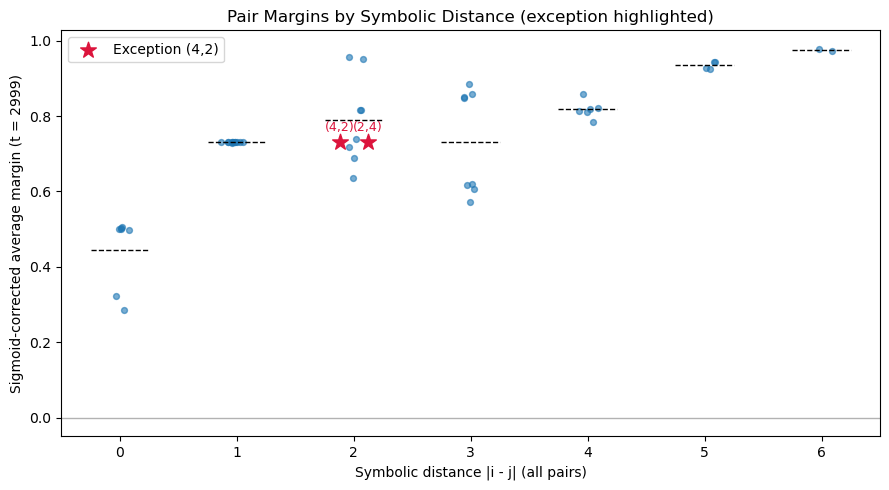

In [ ]:
# Scatter of pair margins by symbolic distance |i - j| (including sd=0),
# highlighting the exception pair (p,q)/(q,p) using sigmoid_correct_margin_grid.

import numpy as np
import matplotlib.pyplot as plt

items_n = sigmoid_correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

# Exclude the exception pair from the base scatter to avoid duplicate markers
base_mask = np.ones_like(dist_mat, dtype=bool)
base_mask[p, q] = False
base_mask[q, p] = False

# Plot all pairs grouped by symbolic distance (including sd=0 and sd=1)
for d in range(0, items_n):
    vals = sigmoid_correct_margin_grid[(dist_mat == d) & base_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, color='C0')
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

# Highlight the exception pair (p,q) and (q,p) at their symbolic distance
d_exc = abs(p - q)
y_pq = sigmoid_correct_margin_grid[p, q]
y_qp = sigmoid_correct_margin_grid[q, p]
plt.scatter(d_exc - 0.12, y_pq, color='crimson', marker='*', s=140, zorder=5, label=f'Exception ({p},{q})')
plt.scatter(d_exc + 0.12, y_qp, color='crimson', marker='*', s=140, zorder=5)

# Annotate the exception points
plt.annotate(f'({p},{q})', (d_exc - 0.12, y_pq), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)
plt.annotate(f'({q},{p})', (d_exc + 0.12, y_qp), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (all pairs)')
plt.ylabel('Sigmoid-corrected average margin (t = %d)' % t_final)
plt.title('Pair Margins by Symbolic Distance (exception highlighted)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import csv
import gzip
import shutil

# Extract training pair results and save to CSV
# We'll save the average margin over seeds for each pair (i, j) at each time step
# Additionally, save h1s and h2s activations (per time_step, item, unit) with per-seed values, mean, and std

# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
train_dict = results["train"]

# Margins (training_progress): shape (seeds_n, time_steps, items_n, items_n)
training_progress = train_dict["training_progress"]
seeds_n, time_steps, items_n, _ = training_progress.shape

# Prepare CSV header for margins
header_margins = ["time_step", "i", "j"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_margin", "std_margin"]

rows = []
for i in range(items_n):
    for j in range(items_n):
        for t in range(time_steps):
            margins = training_progress[:, t, i, j]
            mean_margin = margins.mean()
            std_margin = margins.std()
            row = [t, i, j] + list(margins) + [mean_margin, std_margin]
            rows.append(row)

# Write margins CSV
csv_filename = f"conjunctive_lazy_rich.csv"
with open(csv_filename, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header_margins)
    writer.writerows(rows)

# Gzip the margins CSV
csv_gz_filename = csv_filename + ".gz"
with open(csv_filename, 'rb') as f_in, gzip.open(csv_gz_filename, 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

print(f"Training pair results saved to {csv_filename} (gzipped to {csv_gz_filename})")

# Save h1s if available: shape (seeds_n, time_steps, items_n, h1_size)
if "h1s" in train_dict and train_dict["h1s"] is not None:
    h1s = train_dict["h1s"]
    h1_seeds, h1_time_steps, h1_items_n, h1_size = h1s.shape
    assert h1_seeds == seeds_n and h1_time_steps == time_steps and h1_items_n == items_n, "h1s shape mismatch"

    header_h1 = ["time_step", "item", "unit"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_activation", "std_activation"]
    rows_h1 = []
    for t in range(time_steps):
        for i in range(items_n):
            for unit in range(h1_size):
                vals = h1s[:, t, i, unit]
                rows_h1.append([t, i, unit] + list(vals) + [vals.mean(), vals.std()])

    h1_csv_filename = f"conjunctive_lazy_rich_h1s.csv"
    with open(h1_csv_filename, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header_h1)
        writer.writerows(rows_h1)
    # Gzip the h1s CSV
    h1_csv_gz_filename = h1_csv_filename + ".gz"
    with open(h1_csv_filename, 'rb') as f_in, gzip.open(h1_csv_gz_filename, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    print(f"h1 activations saved to {h1_csv_filename} (gzipped to {h1_csv_gz_filename})")
else:
    print("h1s not found in results['train']; skipping h1 CSV.")

# Save h2s if available: shape (seeds_n, time_steps, items_n, h2_size)
if "h2s" in train_dict and train_dict["h2s"] is not None:
    h2s = train_dict["h2s"]
    h2_seeds, h2_time_steps, h2_items_n, h2_size = h2s.shape
    if h2_seeds == seeds_n and h2_time_steps == time_steps and h2_items_n == items_n:
        header_h2 = ["time_step", "item", "unit"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_activation", "std_activation"]
        rows_h2 = []
        for t in range(time_steps):
            for i in range(items_n):
                for unit in range(h2_size):
                    vals = h2s[:, t, i, unit]
                    rows_h2.append([t, i, unit] + list(vals) + [vals.mean(), vals.std()])

        h2_csv_filename = f"conjunctive_lazy_rich_h2s.csv"
        with open(h2_csv_filename, mode="w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(header_h2)
            writer.writerows(rows_h2)
        # Gzip the h2s CSV
        h2_csv_gz_filename = h2_csv_filename + ".gz"
        with open(h2_csv_filename, 'rb') as f_in, gzip.open(h2_csv_gz_filename, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        print(f"h2 activations saved to {h2_csv_filename} (gzipped to {h2_csv_gz_filename})")
    else:
        print("h2s shape mismatch with training_progress; skipping h2 CSV.")
else:
    print("h2s not found in results['train']; skipping h2 CSV.")

Training pair results saved to conjunctive_lazy_rich.csv (gzipped to conjunctive_lazy_rich.csv.gz)
h1 activations saved to conjunctive_lazy_rich_h1s.csv (gzipped to conjunctive_lazy_rich_h1s.csv.gz)
h2 activations saved to conjunctive_lazy_rich_h2s.csv (gzipped to conjunctive_lazy_rich_h2s.csv.gz)


In [ ]:
csv_filename = f"conjunctive_lazy_rich.csv"
import pandas as pd

# Read the CSV file with training pair margins
df = pd.read_csv(csv_filename)

# Display the first few rows to verify extraction
print("Extracted results from CSV:")
print(df.head())

# Now 'df' contains the extracted results and can be used for further analysis or plotting


Extracted results from CSV:
   time_step  i  j        seed_0   mean_margin  std_margin
0          0  0  0  1.879169e-12  1.879169e-12         0.0
1          1  0  0  1.885779e-12  1.885779e-12         0.0
2          2  0  0  1.870533e-12  1.870533e-12         0.0
3          3  0  0  1.847263e-12  1.847263e-12         0.0
4          4  0  0  1.846703e-12  1.846703e-12         0.0


Figure out keyerror on t issue

In [ ]:
import numpy as np

print("Columns in DataFrame:", df.columns.tolist())

# Try to find the correct time, i, j column names
# The original code expects 't', but the CSV uses 'time_step'
# Let's map accordingly
col_map = {}
for col in df.columns:
    if col.lower() in ['t', 'time', 'time_step']:
        col_map['t'] = col
    if col.lower() == 'i':
        col_map['i'] = col
    if col.lower() == 'j':
        col_map['j'] = col

# Use mapped column names
t_col = col_map.get('t', 'time_step')
i_col = col_map.get('i', 'i')
j_col = col_map.get('j', 'j')

df_sorted = df.sort_values([t_col, i_col, j_col]).reset_index(drop=True)

# The number of margin columns is seeds_n
margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
seeds_n = len(margin_cols)
time_steps = df[t_col].max() + 1  # assumes t is 0-based and contiguous
items_n = max(df[i_col].max(), df[j_col].max()) + 1  # assuming 0-based indexing

# Initialize training_progress array
training_progress = np.zeros((seeds_n, time_steps, items_n, items_n))

# Fill the array
for idx, row in df.iterrows():
    t = int(row[t_col])
    i = int(row[i_col])
    j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress[s, t, i, j] = row[col]

Columns in DataFrame: ['time_step', 'i', 'j', 'seed_0', 'mean_margin', 'std_margin']


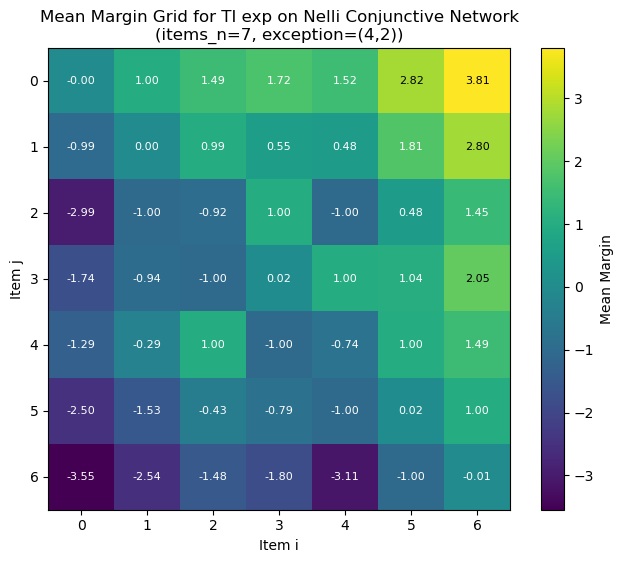

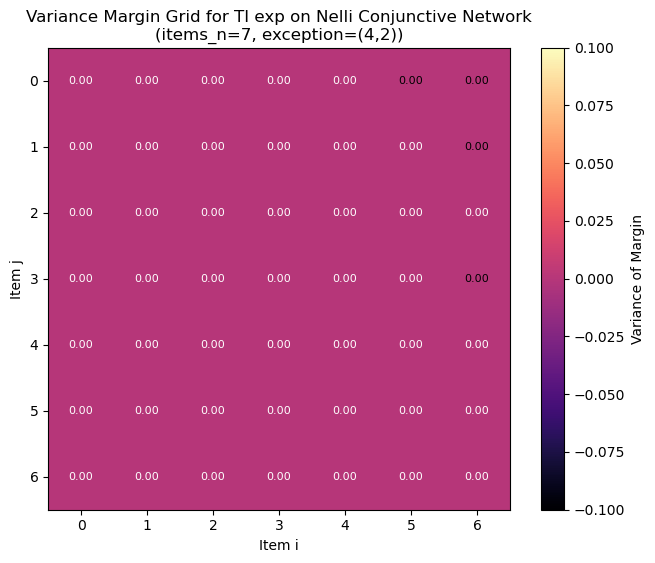

In [ ]:
items_per_context = 7
p = 4
q = 2

if isinstance(results, tuple):
    results = results[1]
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, training_progress.shape[1]-1, i, j]
Average_Grid = np.mean(Grid, axis=0)
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Margin Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))

# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title(f'Variance Margin Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()


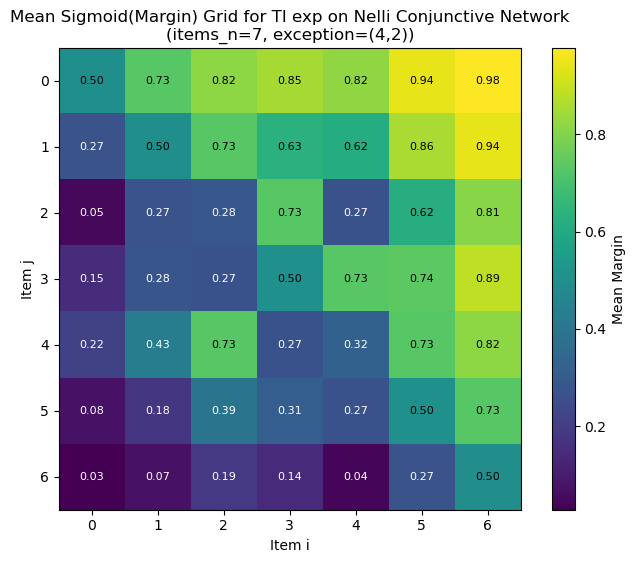

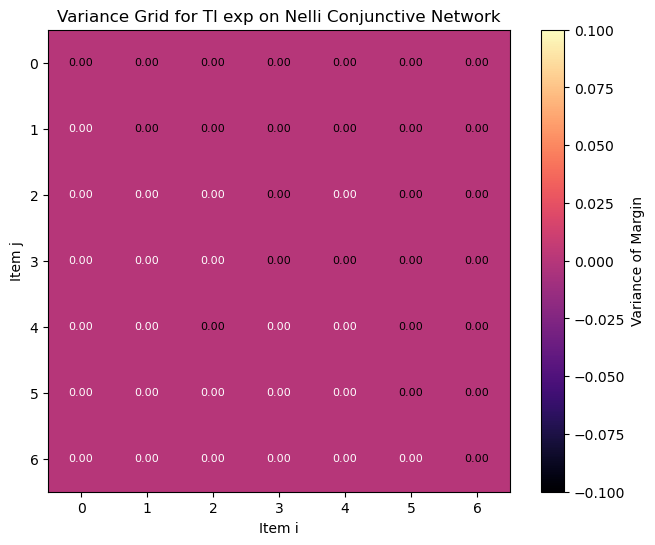

In [ ]:
# if isinstance(results, tuple):
    # results = results[1]
# training_progress = results["train"]["training_progress"]
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, training_length - 1, i, j]
Average_Grid = np.mean(Grid, axis=0)
# Apply sigmoid function to Average_Grid
Average_Grid = 1 / (1 + np.exp(-Average_Grid))
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Sigmoid(Margin) Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title('Variance Grid for TI exp on Nelli Conjunctive Network')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

Current directory: /mnt/smb/locker/abbott-locker/Luke/Nelli Reimplementation/10.16.25 - Reps_Margins/conjunctive_lazy_rich_1e-5_reps_margins_v2
Using directory: Z:\Luke\Nelli Reimplementation
csv_margin.py exists: False
Loaded data from CSV: 1 seeds, 3000 timesteps, 7 items
Exception items: [2, 3, 4]
Non-exception items: [0, 1, 5, 6]


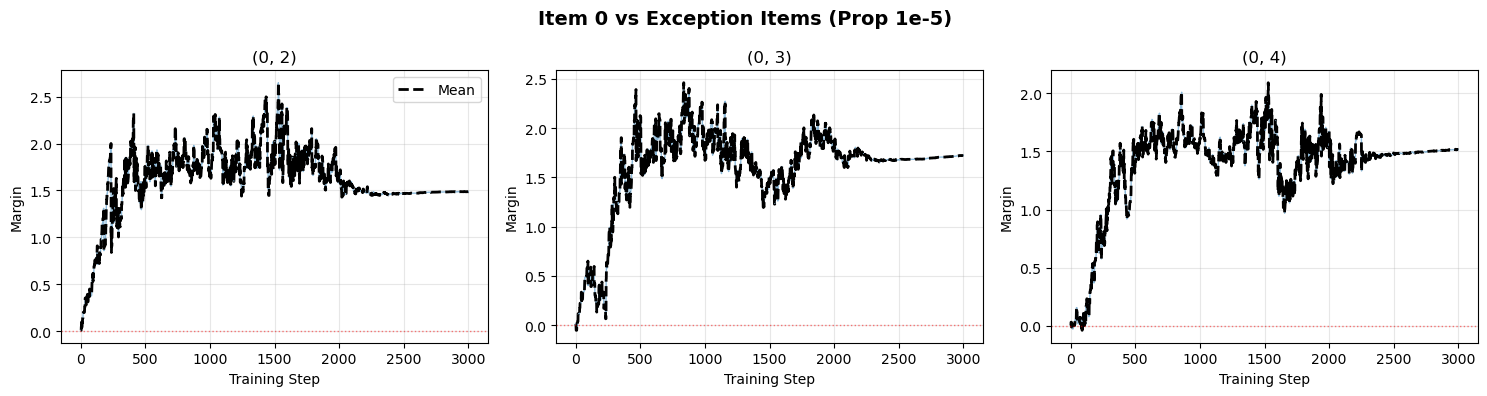

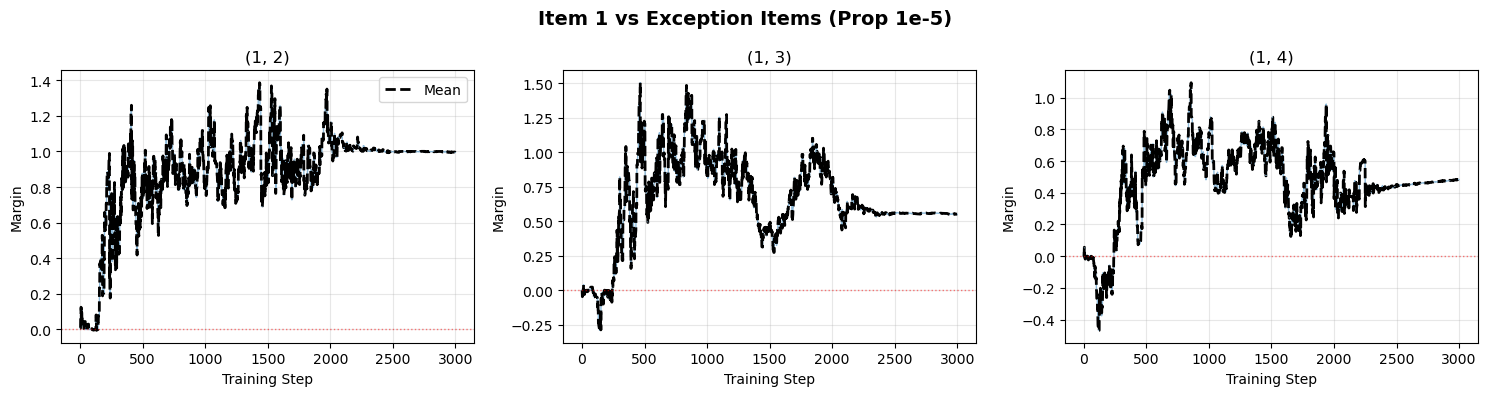

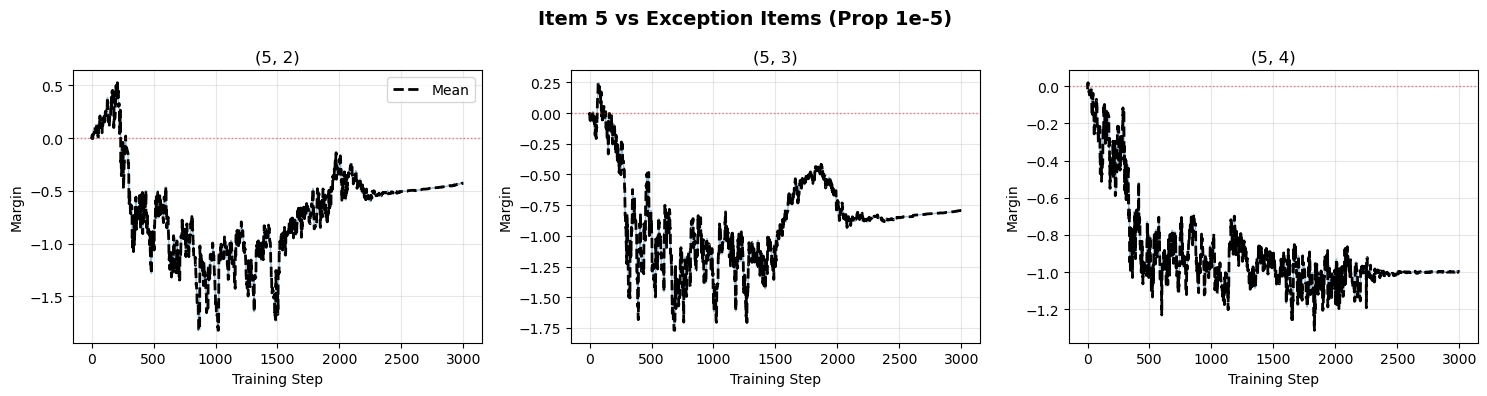

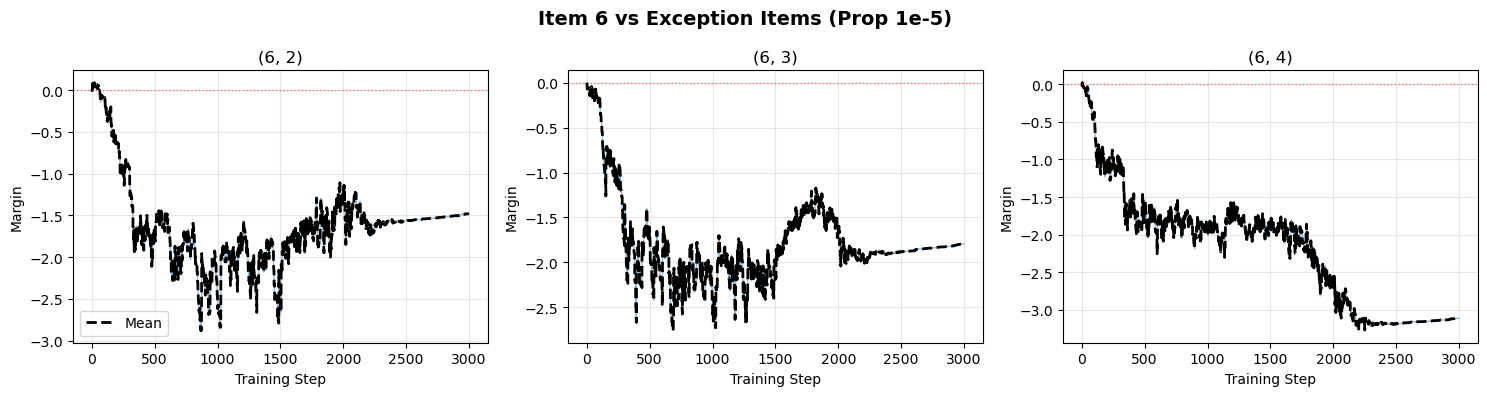

In [ ]:
# Plot each non-exception item vs each exception item
# Exception items: 2, 3, 4 (from p=4, q=2)
# Non-exception items: 0, 1, 5, 6

# Import MarginExtractor from parent directory
import sys
import os
import numpy as np

# Get the parent directory (where csv_margin.py should be)
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# If csv_margin.py is not in parent_dir, try current directory or set explicit path
if not os.path.exists(os.path.join(parent_dir, 'csv_margin.py')):
    # Check if it's in the current directory
    if os.path.exists(os.path.join(current_dir, 'csv_margin.py')):
        parent_dir = current_dir
    else:
        # Explicitly set to the Nelli Reimplementation directory
        parent_dir = r'Z:\Luke\Nelli Reimplementation'

print(f"Current directory: {current_dir}")
print(f"Using directory: {parent_dir}")
print(f"csv_margin.py exists: {os.path.exists(os.path.join(parent_dir, 'csv_margin.py'))}")

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from csv_margin import MarginExtractor
import pandas as pd

# Load the CSV file that was already created
csv_filename = "conjunctive_lazy_rich.csv"
df = pd.read_csv(csv_filename)

# Reconstruct training_progress from CSV (same as Cell 27)
t_col = 'time_step'
i_col = 'i'
j_col = 'j'

margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
csv_seeds_n = len(margin_cols)
csv_time_steps = df[t_col].max() + 1
csv_items_n = max(df[i_col].max(), df[j_col].max()) + 1

# Initialize training_progress array from CSV
training_progress_from_csv = np.zeros((csv_seeds_n, csv_time_steps, csv_items_n, csv_items_n))

# Fill the array
for idx, row in df.iterrows():
    t = int(row[t_col])
    i = int(row[i_col])
    j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress_from_csv[s, t, i, j] = row[col]

# Create a mock results dict for MarginExtractor
results_from_csv = {
    "train": {
        "training_progress": training_progress_from_csv
    }
}

# Create MarginExtractor from CSV data
extractor = MarginExtractor(results_from_csv)
print(f"Loaded data from CSV: {csv_seeds_n} seeds, {csv_time_steps} timesteps, {csv_items_n} items")

# Define exception and non-exception items
p, q = 4, 2
exception_items = list(range(min(p, q), max(p, q) + 1))  # [2, 3, 4]
all_items = list(range(items_n))
non_exception_items = [i for i in all_items if i not in exception_items]

print(f"Exception items: {exception_items}")
print(f"Non-exception items: {non_exception_items}")

# Plot each non-exception item against each exception item
for non_exc in non_exception_items:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Item {non_exc} vs Exception Items (Prop 1e-5)", fontsize=14, fontweight='bold')
    
    for idx, exc in enumerate(exception_items):
        ax = axes[idx]
        
        # Plot margin over time for each seed
        for seed in range(seeds_n):
            # Get margin for (non_exc, exc)
            margin_data = extractor.training_progress[seed, :, non_exc, exc]
            ax.plot(margin_data, alpha=0.5, linewidth=1)
        
        # Calculate mean and plot
        mean_margin = extractor.training_progress[:, :, non_exc, exc].mean(axis=0)
        ax.plot(mean_margin, color='black', linewidth=2, label='Mean', linestyle='--')
        
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Margin')
        ax.set_title(f'({non_exc}, {exc})')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='red', linestyle=':', linewidth=1, alpha=0.5)
        
    axes[0].legend()
    plt.tight_layout()
    plt.show()


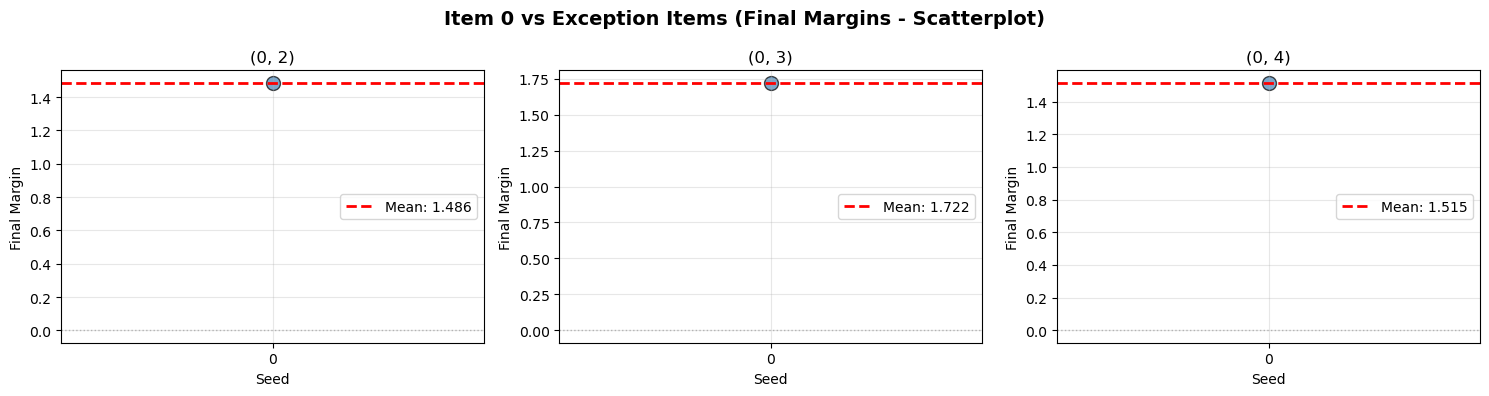

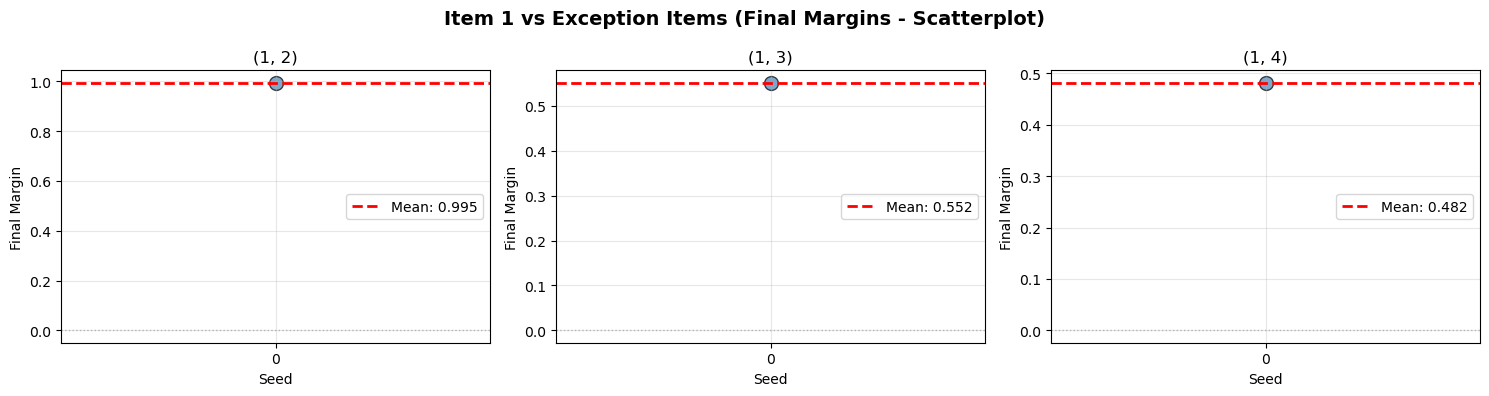

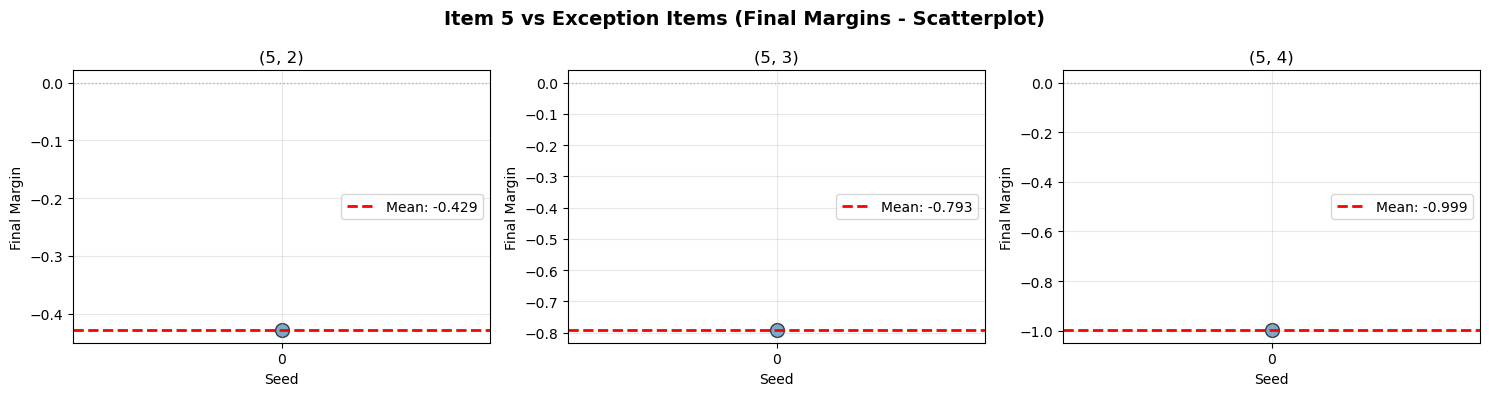

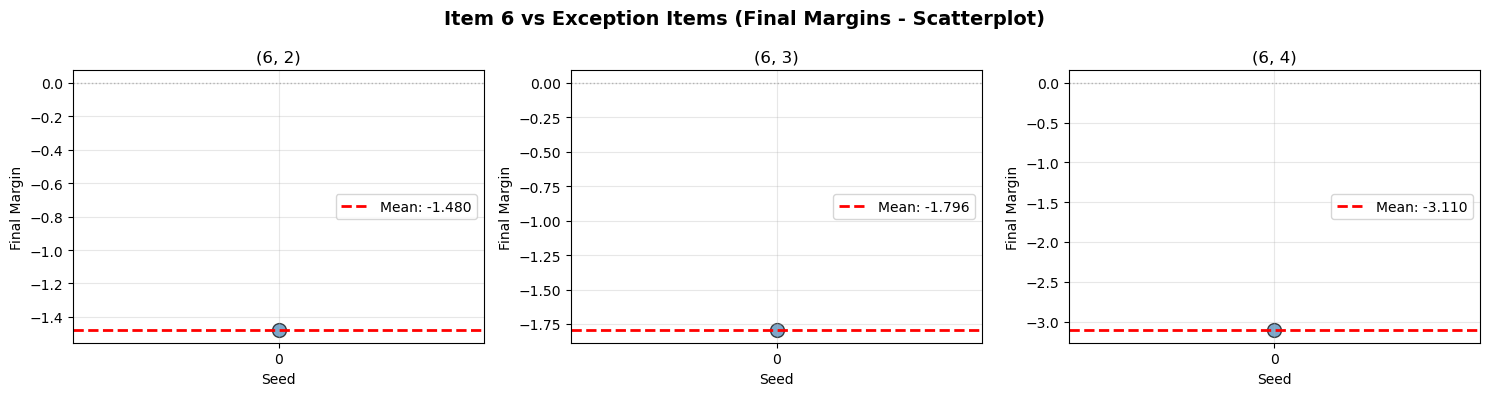

In [ ]:
# Scatterplot version - showing final margins for non-exception vs exception items
# Reuse the same exception/non-exception item definitions

# Get final timestep margins
final_timestep = extractor.time_steps - 1

for non_exc in non_exception_items:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Item {non_exc} vs Exception Items (Final Margins - Scatterplot)", fontsize=14, fontweight='bold')
    
    for idx, exc in enumerate(exception_items):
        ax = axes[idx]
        
        # Get final margins for all seeds for pair (non_exc, exc)
        final_margins = extractor.training_progress[:, final_timestep, non_exc, exc]
        
        # Create scatter plot with seed indices on x-axis
        seeds = np.arange(csv_seeds_n)
        ax.scatter(seeds, final_margins, s=100, alpha=0.7, c='steelblue', edgecolors='black', linewidth=1)
        
        # Add mean line
        mean_margin = final_margins.mean()
        ax.axhline(y=mean_margin, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_margin:.3f}')
        
        # Add zero reference line
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        
        ax.set_xlabel('Seed')
        ax.set_ylabel('Final Margin')
        ax.set_title(f'({non_exc}, {exc})')
        ax.set_xticks(seeds)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
    plt.tight_layout()
    plt.show()


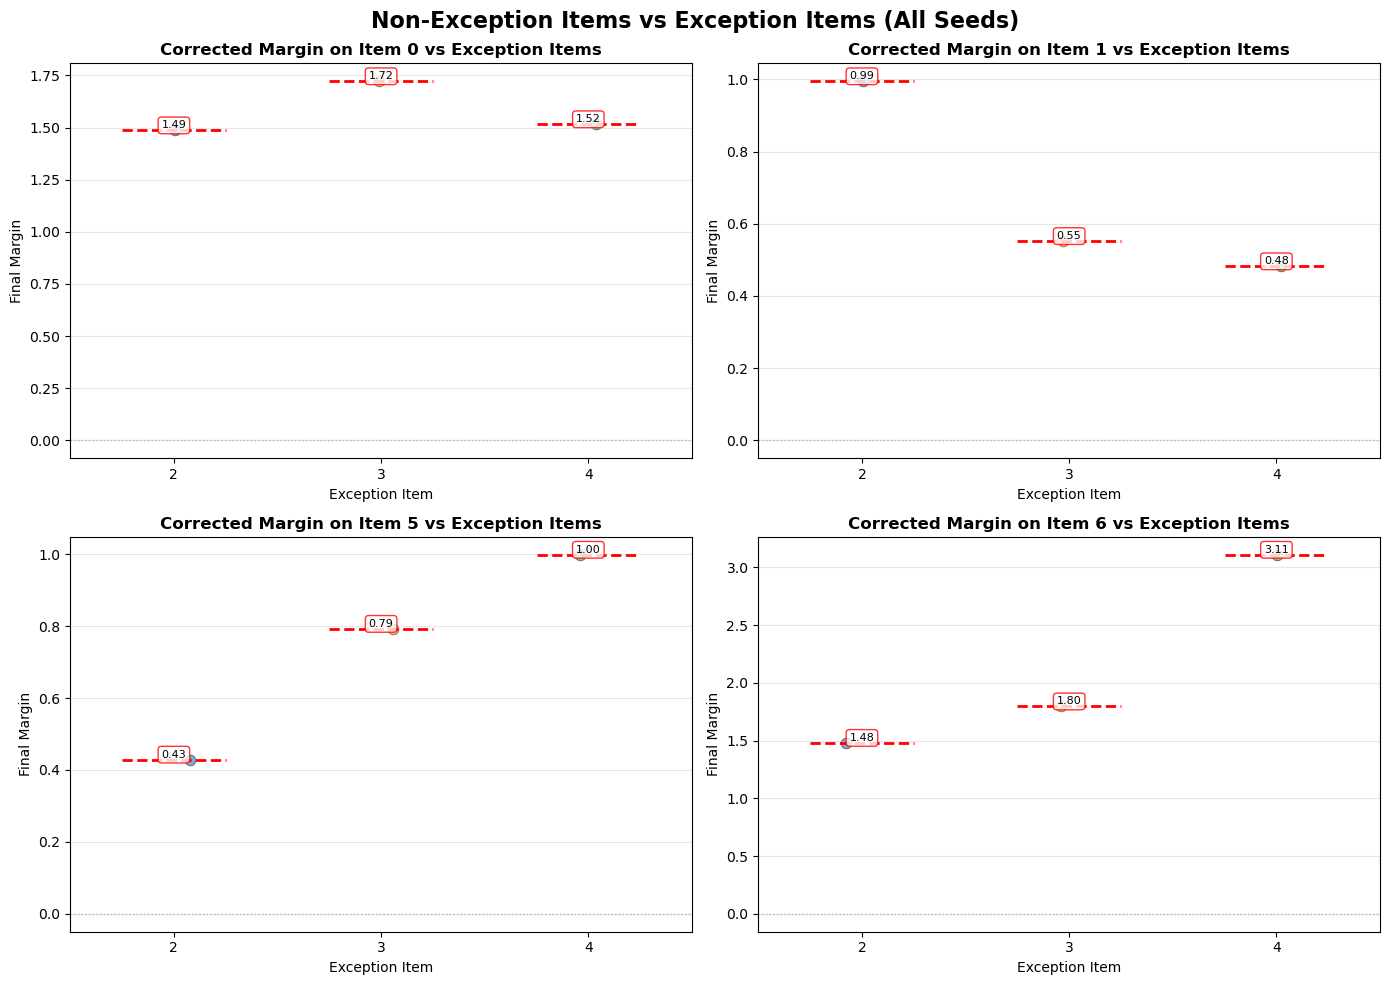

In [ ]:
# Combined scatter plot: all non-exception items vs exception items in one figure
# X-axis: exception item index (2, 3, 4)
# Y-axis: final margin values (one point per seed)

import numpy as np
import matplotlib.pyplot as plt

# Get final timestep margins
final_timestep = extractor.time_steps - 1
rng = np.random.default_rng(0)

# Create a 2x2 subplot grid for all non-exception items
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to easily iterate

fig.suptitle('Non-Exception Items vs Exception Items (All Seeds)', fontsize=16, fontweight='bold')

# Create a plot for each non-exception item
for idx, non_exc_item in enumerate(non_exception_items):
    ax = axes[idx]
    
    for exc in exception_items:
        # Get final margins for all seeds for pair (non_exc_item, exc)
        final_margins = extractor.training_progress[:, final_timestep, non_exc_item, exc]
        
        # Correct margins: multiply by -1 if i > j
        if non_exc_item > exc:
            final_margins = -1 * final_margins
        
        # Add jitter to x-coordinates for visibility
        x = rng.normal(loc=exc, scale=0.06, size=final_margins.size)
        ax.scatter(x, final_margins, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        # Add mean line with label
        mean_margin = final_margins.mean()
        ax.hlines(mean_margin, exc - 0.25, exc + 0.25, colors='red', linestyles='--', linewidth=2)
        ax.text(exc, mean_margin, f'{mean_margin:.2f}', ha='center', va='bottom', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8))
    
    ax.set_xticks(exception_items)
    ax.set_xticklabels([str(e) for e in exception_items])
    ax.set_xlabel('Exception Item')
    ax.set_ylabel('Final Margin')
    ax.set_title(f'Corrected Margin on Item {non_exc_item} vs Exception Items', fontweight='bold')
    ax.axhline(0, color='gray', linewidth=1, linestyle=':', alpha=0.5)
    ax.set_xlim(min(exception_items) - 0.5, max(exception_items) + 0.5)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


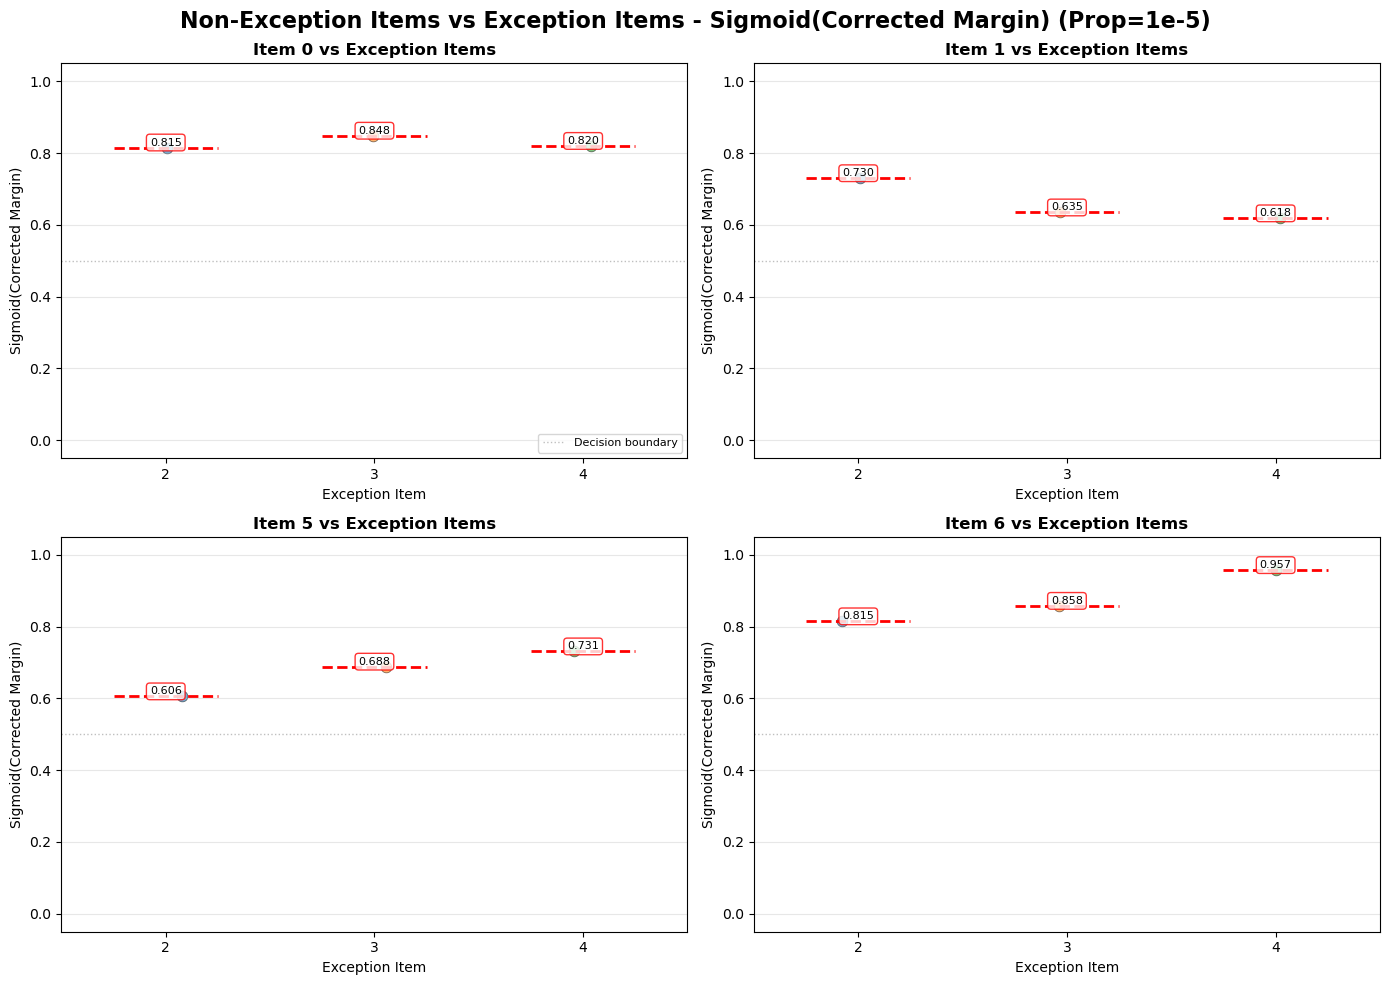

In [ ]:
# Combined scatter plot with SIGMOID(corrected margins)
# X-axis: exception item index (2, 3, 4)
# Y-axis: sigmoid of final margin values (one point per seed)

import numpy as np
import matplotlib.pyplot as plt

# Get final timestep margins
final_timestep = extractor.time_steps - 1
rng = np.random.default_rng(0)

# Create a 2x2 subplot grid for all non-exception items
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to easily iterate

fig.suptitle('Non-Exception Items vs Exception Items - Sigmoid(Corrected Margin) (Prop=1e-5)', fontsize=16, fontweight='bold')

# Create a plot for each non-exception item
for idx, non_exc_item in enumerate(non_exception_items):
    ax = axes[idx]
    
    for exc in exception_items:
        # Get final margins for all seeds for pair (non_exc_item, exc)
        final_margins = extractor.training_progress[:, final_timestep, non_exc_item, exc]
        
        # Correct margins: multiply by -1 if i > j
        if non_exc_item > exc:
            final_margins = -1 * final_margins
        
        # Apply sigmoid transformation
        final_margins_sigmoid = 1 / (1 + np.exp(-final_margins))
        
        # Add jitter to x-coordinates for visibility
        x = rng.normal(loc=exc, scale=0.06, size=final_margins_sigmoid.size)
        ax.scatter(x, final_margins_sigmoid, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        # Add mean line with label
        mean_margin = final_margins_sigmoid.mean()
        ax.hlines(mean_margin, exc - 0.25, exc + 0.25, colors='red', linestyles='--', linewidth=2)
        ax.text(exc, mean_margin, f'{mean_margin:.3f}', ha='center', va='bottom', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8))
    
    ax.set_xticks(exception_items)
    ax.set_xticklabels([str(e) for e in exception_items])
    ax.set_xlabel('Exception Item')
    ax.set_ylabel('Sigmoid(Corrected Margin)')
    ax.set_title(f'Item {non_exc_item} vs Exception Items', fontweight='bold')
    ax.axhline(0.5, color='gray', linewidth=1, linestyle=':', alpha=0.5, label='Decision boundary')
    ax.set_xlim(min(exception_items) - 0.5, max(exception_items) + 0.5)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3, axis='y')
    if idx == 0:
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()


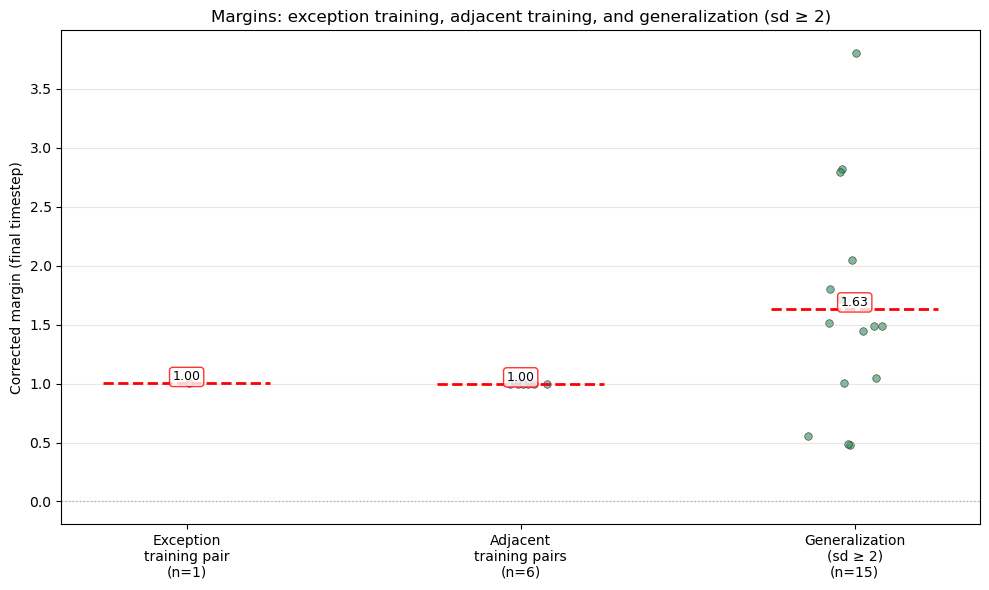

In [ ]:
# Margins for exception training pair, adjacent training pairs, and generalization pairs (sd ≥ 2)

# Build extractor from CSV to make this cell self-contained
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Ensure we can import MarginExtractor
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
from csv_margin import MarginExtractor

# Load CSV written earlier in the notebook
csv_filename = "conjunctive_lazy_rich.csv"
df = pd.read_csv(csv_filename)

# Reconstruct training_progress from the CSV (same logic as earlier)
t_col, i_col, j_col = 'time_step', 'i', 'j'
margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
csv_seeds_n = len(margin_cols)
csv_time_steps = df[t_col].max() + 1
csv_items_n = max(df[i_col].max(), df[j_col].max()) + 1

training_progress = np.zeros((csv_seeds_n, csv_time_steps, csv_items_n, csv_items_n))
for _, row in df.iterrows():
    t = int(row[t_col]); i = int(row[i_col]); j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress[s, t, i, j] = row[col]

results_from_csv = {"train": {"training_progress": training_progress}}
extractor = MarginExtractor(results_from_csv)

# Exception definition
p, q = 4, 2

# Ensure we have the final timestep and items count
final_timestep = extractor.time_steps - 1
items_n = extractor.items_n if hasattr(extractor, 'items_n') else extractor.training_progress.shape[2]

# Use unordered pairs by taking only i < j and define categories by symbolic distance (sd = |i - j|)
exc_unordered = (min(p, q), max(p, q))  # the single exception training pair (unordered)

training_pairs = [(i, j) for i in range(items_n) for j in range(i + 1, items_n)
                  if abs(i - j) == 1 and (i, j) != exc_unordered]

exception_pairs = [exc_unordered]

generalization_pairs = [(i, j) for i in range(items_n) for j in range(i + 1, items_n)
                        if abs(i - j) >= 2]

# Helper to get corrected margins across seeds for a single (i, j) with i < j
# Flip the exception pair so it aligns with the "corrected" convention used elsewhere

def corrected_seed_margins(i, j):
    vals = extractor.training_progress[:, final_timestep, i, j]
    if (i, j) == exc_unordered:
        vals = -vals
    return vals

# Collect margins for a set of pairs (concatenate all seeds across all pairs)

def collect_margins(pairs):
    if len(pairs) == 0:
        return np.array([])
    all_vals = [corrected_seed_margins(i, j) for (i, j) in pairs]
    return np.concatenate(all_vals, axis=0)

exception_margins = collect_margins(exception_pairs)
training_margins = collect_margins(training_pairs)
generalization_margins = collect_margins(generalization_pairs)

# Jittered scatter per category with mean lines
rng = np.random.default_rng(0)

categories = ["Exception\ntraining pair", "Adjacent\ntraining pairs", "Generalization\n(sd ≥ 2)"]
values = [exception_margins, training_margins, generalization_margins]
colors = ['crimson', 'steelblue', 'seagreen']

plt.figure(figsize=(10, 6))
for idx, (vals, color) in enumerate(zip(values, colors)):
    if vals.size == 0:
        continue
    x = rng.normal(loc=idx, scale=0.06, size=vals.size)
    plt.scatter(x, vals, alpha=0.6, s=30, edgecolors='black', linewidth=0.5, color=color)
    mean_val = vals.mean()
    plt.hlines(mean_val, idx - 0.25, idx + 0.25, colors='red', linestyles='--', linewidth=2)
    plt.text(idx, mean_val, f"{mean_val:.2f}", ha='center', va='bottom', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.25', facecolor='white', edgecolor='red', alpha=0.8))

plt.xticks(range(len(categories)), [f"{label}\n(n={len(v)})" for label, v in zip(categories, values)])
plt.ylabel('Corrected margin (final timestep)')
plt.title('Margins: exception training, adjacent training, and generalization (sd ≥ 2)')
plt.axhline(0, color='gray', linewidth=1, linestyle=':', alpha=0.5)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


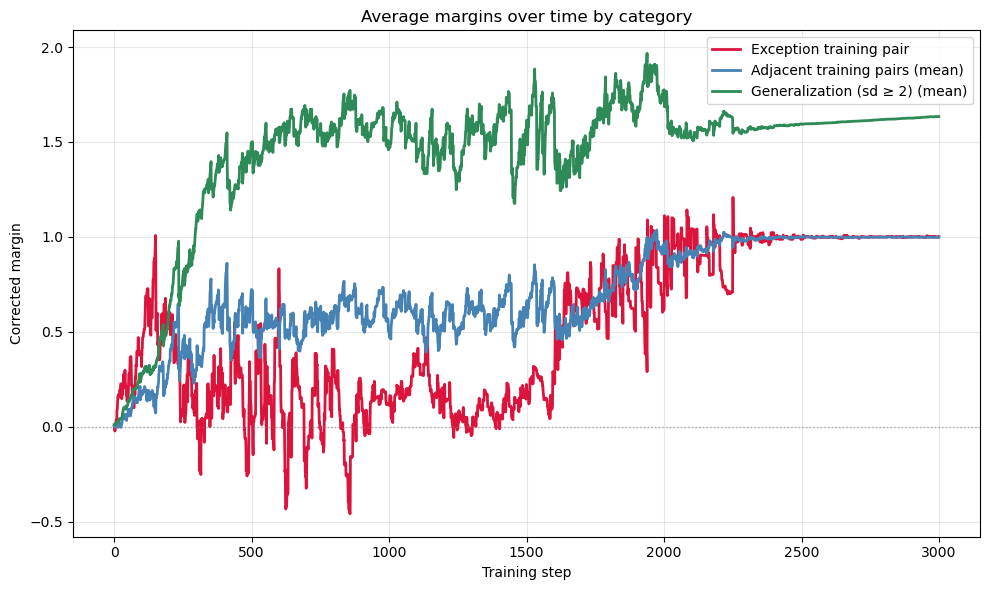

In [ ]:
# Average category margins over time: exception training, adjacent training, generalization (sd ≥ 2)
import numpy as np
import matplotlib.pyplot as plt

# Assume extractor, p, q exist from previous cell
items_n = extractor.items_n if hasattr(extractor, 'items_n') else extractor.training_progress.shape[2]
time_steps = extractor.time_steps
seeds_n = extractor.seeds_n

# Define unordered exception pair and category sets using i < j canonical orientation
exc_unordered = (min(p, q), max(p, q))
training_pairs = [(i, j) for i in range(items_n) for j in range(i + 1, items_n)
                  if abs(i - j) == 1 and (i, j) != exc_unordered]
exception_pairs = [exc_unordered]
generalization_pairs = [(i, j) for i in range(items_n) for j in range(i + 1, items_n)
                        if abs(i - j) >= 2]

# Helpers to gather corrected margins at time t for a category

def corrected_margins_at_t(i, j, t):
    vals = extractor.training_progress[:, t, i, j]
    # Flip the exception pair so it aligns with the "corrected" convention
    if (i, j) == exc_unordered:
        vals = -vals
    return vals


def category_mean_series(pairs):
    means = np.zeros(time_steps)
    if len(pairs) == 0:
        return means
    for t in range(time_steps):
        all_vals_t = []
        for (i, j) in pairs:
            all_vals_t.append(corrected_margins_at_t(i, j, t))  # shape: (seeds,)
        cat_vals_t = np.concatenate(all_vals_t, axis=0)  # concat over pairs and seeds
        means[t] = cat_vals_t.mean()
    return means

exc_series = category_mean_series(exception_pairs)
train_series = category_mean_series(training_pairs)
gen_series = category_mean_series(generalization_pairs)

plt.figure(figsize=(10, 6))
plt.plot(exc_series, label='Exception training pair', color='crimson', linewidth=2)
plt.plot(train_series, label='Adjacent training pairs (mean)', color='steelblue', linewidth=2)
plt.plot(gen_series, label='Generalization (sd ≥ 2) (mean)', color='seagreen', linewidth=2)
plt.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.6)
plt.xlabel('Training step')
plt.ylabel('Corrected margin')
plt.title('Average margins over time by category')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


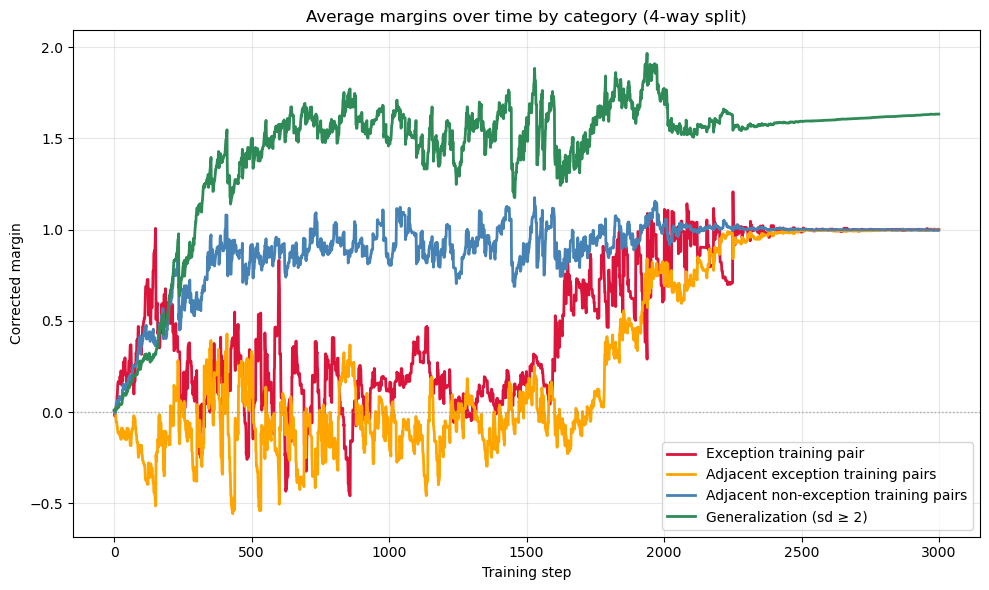

In [ ]:
# Average category margins over time (4 categories):
# 1) Exception training pair
# 2) Adjacent exception training pairs (within exception band)
# 3) Adjacent non-exception training pairs (outside exception band)
# 4) Generalization pairs (sd ≥ 2)
import numpy as np
import matplotlib.pyplot as plt

# Assume extractor, p, q exist from previous cell
items_n = extractor.items_n if hasattr(extractor, 'items_n') else extractor.training_progress.shape[2]
time_steps = extractor.time_steps

exc_unordered = (min(p, q), max(p, q))
exception_items = list(range(min(p, q), max(p, q) + 1))

# Build categories using canonical orientation i < j
exception_pair = [exc_unordered]

adjacent_exception_pairs = [
    (i, j)
    for i in range(items_n)
    for j in range(i + 1, items_n)
    if abs(i - j) == 1 and (i in exception_items and j in exception_items)
]

adjacent_nonexception_pairs = [
    (i, j)
    for i in range(items_n)
    for j in range(i + 1, items_n)
    if abs(i - j) == 1 and not (i in exception_items and j in exception_items)
]

generalization_pairs = [
    (i, j)
    for i in range(items_n)
    for j in range(i + 1, items_n)
    if abs(i - j) >= 2
]

# Helpers

def corrected_margins_at_t(i, j, t):
    vals = extractor.training_progress[:, t, i, j]
    # Flip the exception pair to align with the "corrected" convention
    if (i, j) == exc_unordered:
        vals = -vals
    return vals


def category_mean_series(pairs):
    means = np.zeros(time_steps)
    if len(pairs) == 0:
        return means
    for t in range(time_steps):
        all_vals_t = [corrected_margins_at_t(i, j, t) for (i, j) in pairs]
        cat_vals_t = np.concatenate(all_vals_t, axis=0)
        means[t] = cat_vals_t.mean()
    return means

exc_series = category_mean_series(exception_pair)
adj_exc_series = category_mean_series(adjacent_exception_pairs)
adj_nonexc_series = category_mean_series(adjacent_nonexception_pairs)
gen_series = category_mean_series(generalization_pairs)

plt.figure(figsize=(10, 6))
plt.plot(exc_series, label='Exception training pair', color='crimson', linewidth=2)
plt.plot(adj_exc_series, label='Adjacent exception training pairs', color='orange', linewidth=2)
plt.plot(adj_nonexc_series, label='Adjacent non-exception training pairs', color='steelblue', linewidth=2)
plt.plot(gen_series, label='Generalization (sd ≥ 2)', color='seagreen', linewidth=2)
plt.axhline(0, color='gray', linestyle=':', linewidth=1, alpha=0.6)
plt.xlabel('Training step')
plt.ylabel('Corrected margin')
plt.title('Average margins over time by category (4-way split)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
print("adjacent_nonexception_pairs:", adjacent_nonexception_pairs)
print("adjacent_exception_pairs:", adjacent_exception_pairs)
print("exception_pair:", exception_pair)
print("generalization_pairs:", generalization_pairs)

adjacent_nonexception_pairs: [(0, 1), (1, 2), (4, 5), (5, 6)]
adjacent_exception_pairs: [(2, 3), (3, 4)]
exception_pair: [(2, 4)]
generalization_pairs: [(0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 3), (1, 4), (1, 5), (1, 6), (2, 4), (2, 5), (2, 6), (3, 5), (3, 6), (4, 6)]


# Load CSVs for Respresentations

In [ ]:
import pandas as pd

def load_layer_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression='gzip')
    seed_cols = [c for c in df.columns if c.startswith('seed_')]
    time_steps = int(df['time_step'].max()) + 1
    items_n_inferred = int(df['item'].max()) + 1
    units = int(df['unit'].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, time_steps, items_n_inferred, units))
    for _, row in df.iterrows():
        t = int(row['time_step']); i = int(row['item']); u = int(row['unit'])
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, t, i, u] = row[sc]
    return arr  # shape: (seeds, time, items, units)

In [ ]:
# Neural Knowledge Assembly-style visualization adapted to this network
# - Top row: Euclidean distance matrices of hidden layer h1s at 3 training positions
# - Bottom row: 2D MDS embeddings at the same positions

import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import euclidean_distances
import pandas as pd
from helpers import rotate
from plotting import mds_plot

# Local CSV.GZ loader for h1s/h2s saved earlier in this notebook
def load_layer_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression='gzip')
    seed_cols = [c for c in df.columns if c.startswith('seed_')]
    time_steps = int(df['time_step'].max()) + 1
    items_n = int(df['item'].max()) + 1
    units = int(df['unit'].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, time_steps, items_n, units))
    for _, row in df.iterrows():
        t = int(row['time_step']); i = int(row['item']); u = int(row['unit'])
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, t, i, u] = row[sc]
    return arr

# Local safe matrix plot that works for odd items_n (do not rely on plotting.matrix_plot)
def matrix_plot_safe(data, ax, items_n, vmin=None, vmax=None):
    if vmin is None:
        im = ax.imshow(data, cmap=plt.cm.magma)
    else:
        im = ax.imshow(data, cmap=plt.cm.magma, vmin=vmin, vmax=vmax)
    ax.set_xticks(range(items_n))
    ax.set_yticks(range(items_n))
    if items_n % 2 == 0:
        labels = list(range(1, items_n // 2 + 1)) * 2
    else:
        labels = list(range(1, items_n + 1))
    ax.set_xticklabels(labels, va='center', fontsize=10, fontweight="bold")
    ax.set_yticklabels(labels, ha='center', fontsize=10, fontweight="bold")
    ax.tick_params(left=False, bottom=False)
    for pos in ["top", "right", "bottom", "left"]:
        ax.spines[pos].set_linewidth(1)
        ax.spines[pos].set_color([0.5] * 3)
    return im

# Load h1s from gzipped CSV written by the CSV export cell
csv_gz_h1_path = "conjunctive_lazy_rich_h1s.csv.gz"
h1s_loaded = load_layer_from_csv_gz(csv_gz_h1_path)
all_h1s = h1s_loaded.mean(axis=0)  # (time_steps, items_n, h1_size)
items_n = all_h1s.shape[1]
steps_after_training = all_h1s.shape[0] - 1
mds_seed = 0

# Load h2s from gzipped CSV written by the CSV export cell
csv_gz_h2_path = "conjunctive_lazy_rich_h2s.csv.gz"
h2s_loaded = load_layer_from_csv_gz(csv_gz_h2_path)
all_h2s = h2s_loaded.mean(axis=0)  # (time_steps, items_n, h2_size)
items_n = all_h2s.shape[1]
steps_after_training = all_h2s.shape[0] - 1
mds_seed = 0

# Plot H1s

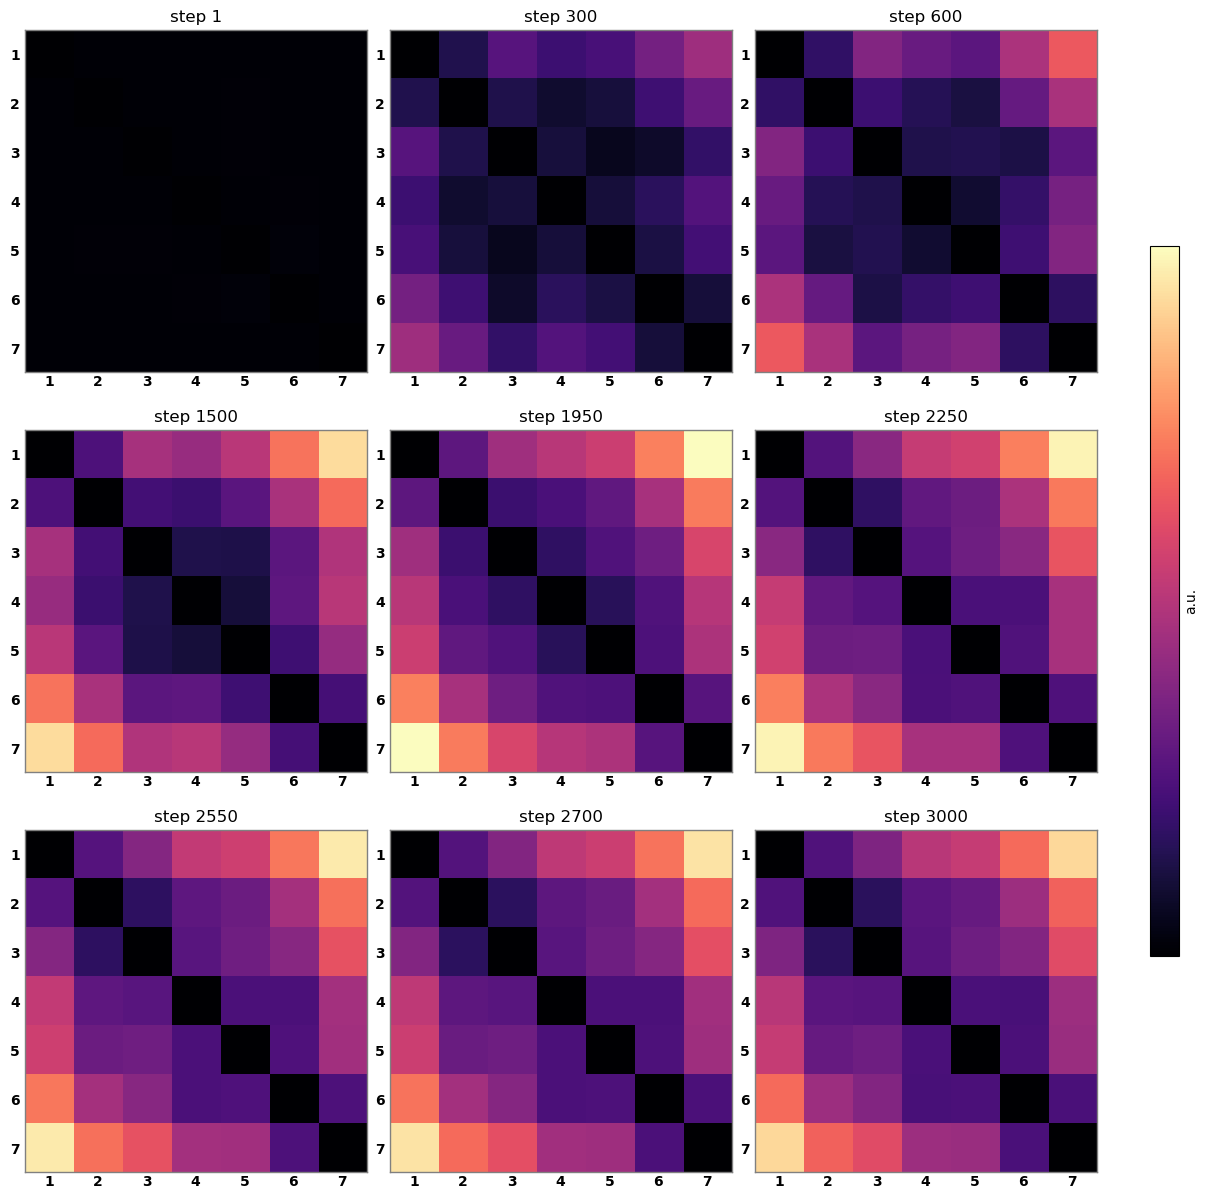

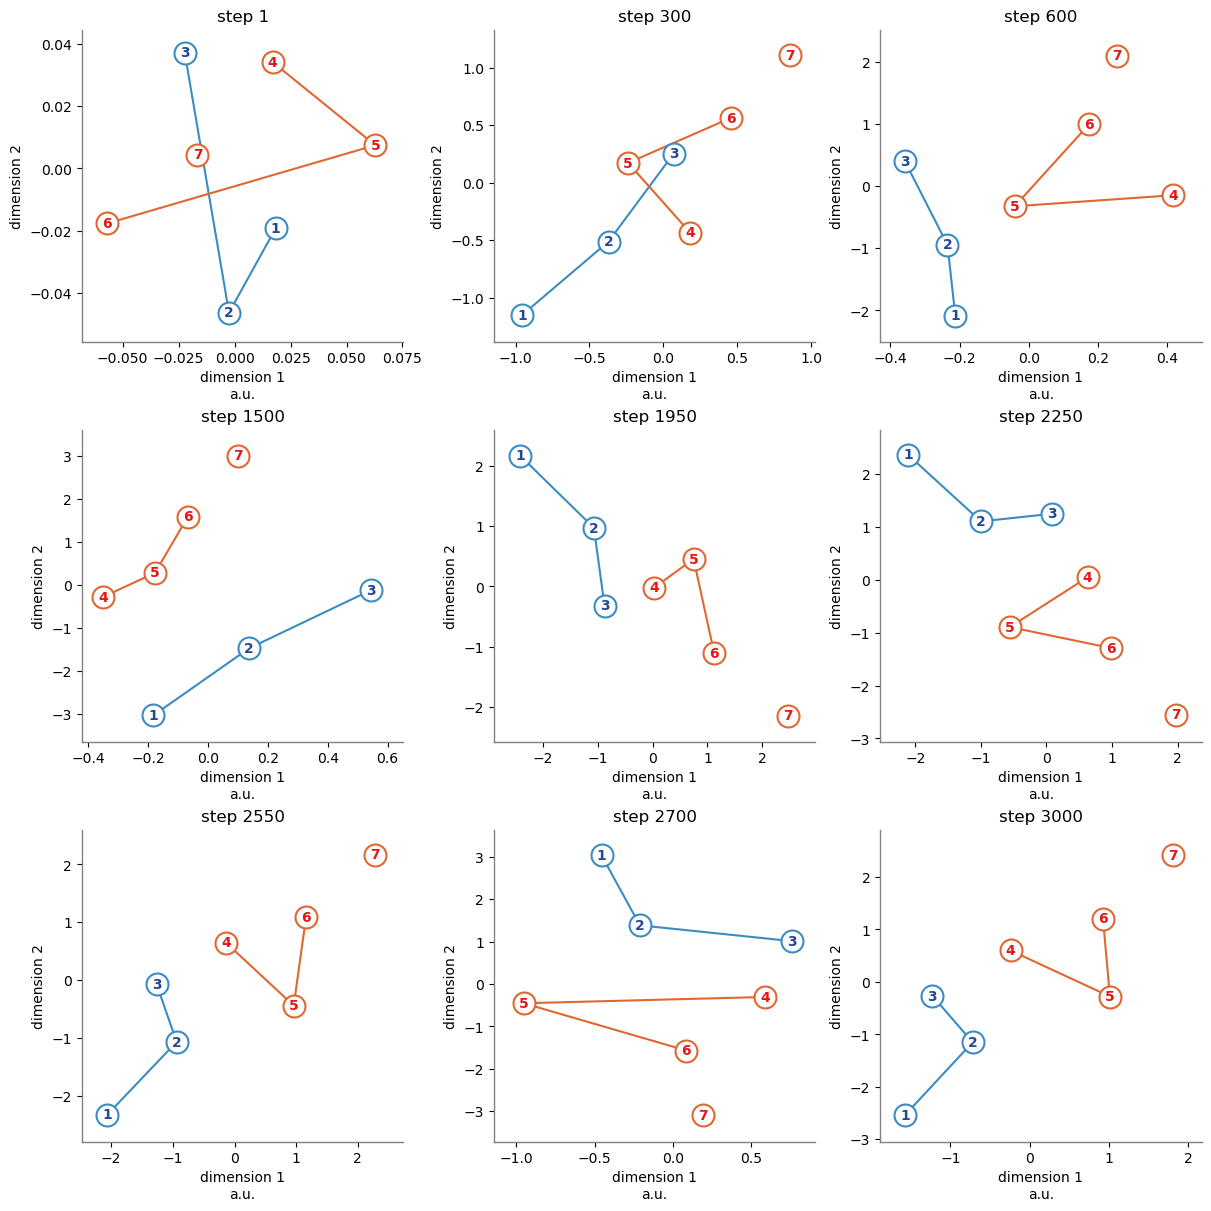

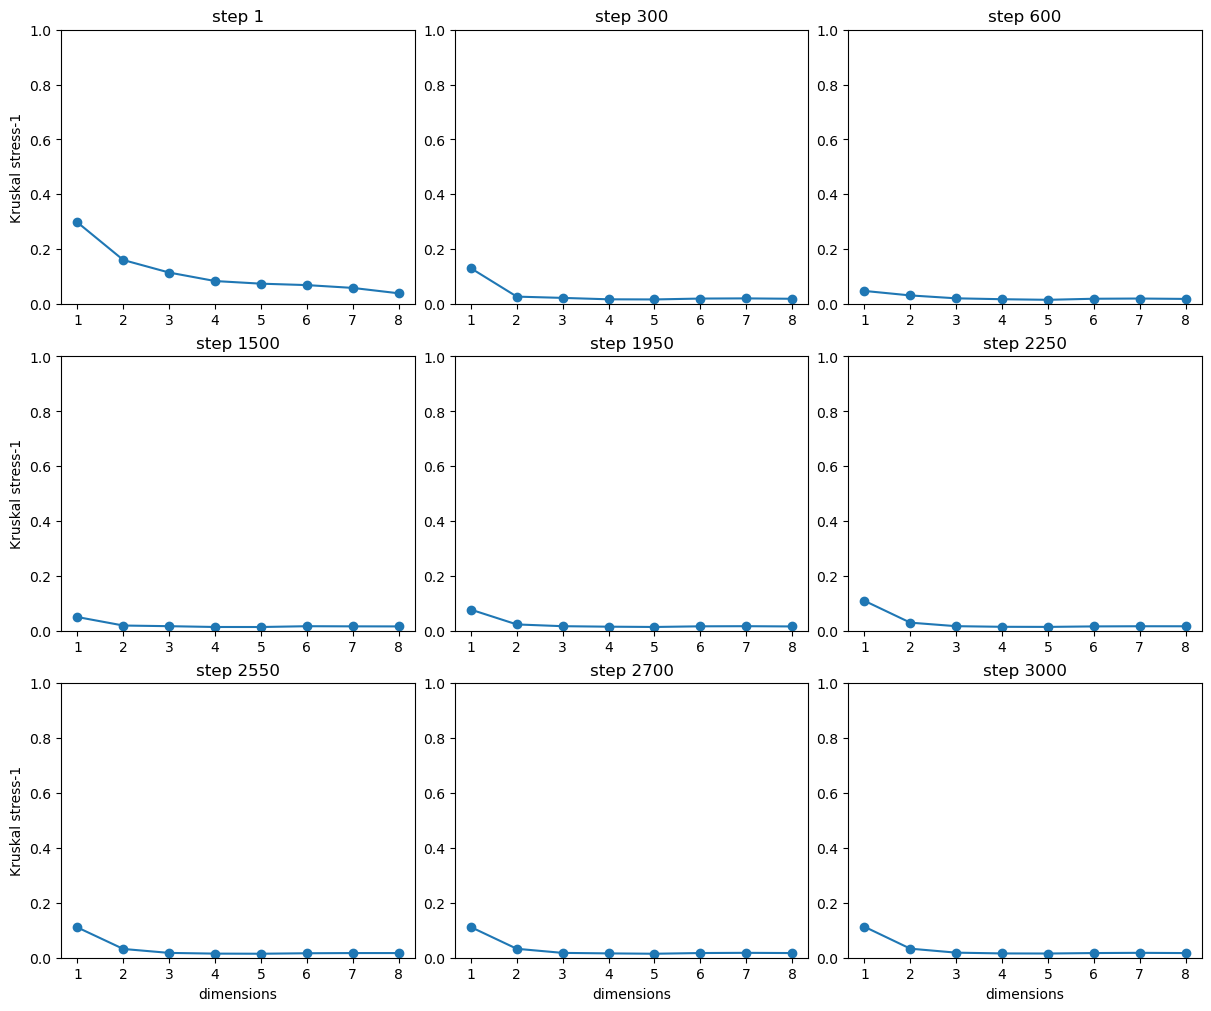

In [ ]:
# Choose nine positions across training
positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]

fig1, axs1 = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig1.patch.set_facecolor('white')

fig2, axs2 = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig2.patch.set_facecolor('white')

# Determine vmax across selected time slices
vmax = 0.0
for i in range(len(positions)):
    t_idx = max(0, int(positions[i] * steps_after_training))
    h1s = all_h1s[t_idx]
    vmax_ = float(np.round(np.max(euclidean_distances(h1s)), 1))
    if vmax_ > vmax:
        vmax = vmax_

# Distance matrices → 3x3 grid (fig1)
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    t_idx = max(0, int(p * steps_after_training))
    dists = euclidean_distances(all_h1s[t_idx])
    im = matrix_plot_safe(dists, axs1[r, c], items_n, 0., vmax)
    axs1[r, c].set_title(f"step {t_idx+1}")

cbar = fig1.colorbar(im, ax=axs1, shrink=.6, aspect=25)
cbar.set_ticks([])
cbar.ax.set_ylabel("a.u.")

# MDS embeddings → 3x3 grid (fig2)
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    t_idx = max(0, int(p * steps_after_training))
    dists = euclidean_distances(all_h1s[t_idx])
    mds = manifold.MDS(
        n_components=2,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=mds_seed,
        n_init=4,                     # keep behavior stable; silences FutureWarning
        normalized_stress="auto",
    )
    d1, d2 = mds.fit(dists).embedding_.T

    if idx % 3 == 0:
        rotate(d1, d2, 250.)
    elif idx % 3 == 1:
        rotate(d1, d2, 230.)
    else:
        rotate(d1, d2, 260.)

    mds_plot((d1, d2), axs2[r, c], items_n)
    axs2[r, c].set_title(f"step {t_idx+1}")

    for pos in ["left", "bottom"]:
        axs2[r, c].spines[pos].set_linewidth(1)
        axs2[r, c].spines[pos].set_color([0.5]*3)

    axs2[r, c].set_xlabel("dimension 1\na.u.")
    axs2[r, c].set_ylabel("dimension 2")

plt.show()

# Kruskal stress vs dimensions for the same positions (h1)
max_dims = 8
fig_stress, axs_stress = plt.subplots(3, 3, figsize=(12., 10.), constrained_layout=True)
fig_stress.patch.set_facecolor('white')
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    t_idx = max(0, int(p * steps_after_training))
    D = euclidean_distances(all_h1s[t_idx])
    denom = np.sum(D**2)
    stresses = []
    for k in range(1, max_dims + 1):
        m = manifold.MDS(n_components=k, dissimilarity="precomputed", random_state=mds_seed, n_init=4, normalized_stress="auto")
        m.fit(D)
        stress_raw = getattr(m, "stress_", None)
        if stress_raw is None or denom == 0:
            stresses.append(np.nan)
        else:
            stresses.append(np.sqrt(stress_raw / denom))  # Kruskal stress-1
    axs_stress[r, c].plot(range(1, max_dims + 1), stresses, marker='o')
    axs_stress[r, c].set_title(f"step {t_idx+1}")
    if r == 2:
        axs_stress[r, c].set_xlabel("dimensions")
    if c == 0:
        axs_stress[r, c].set_ylabel("Kruskal stress-1")
    axs_stress[r, c].set_ylim(0.0, 1.0)
plt.show()

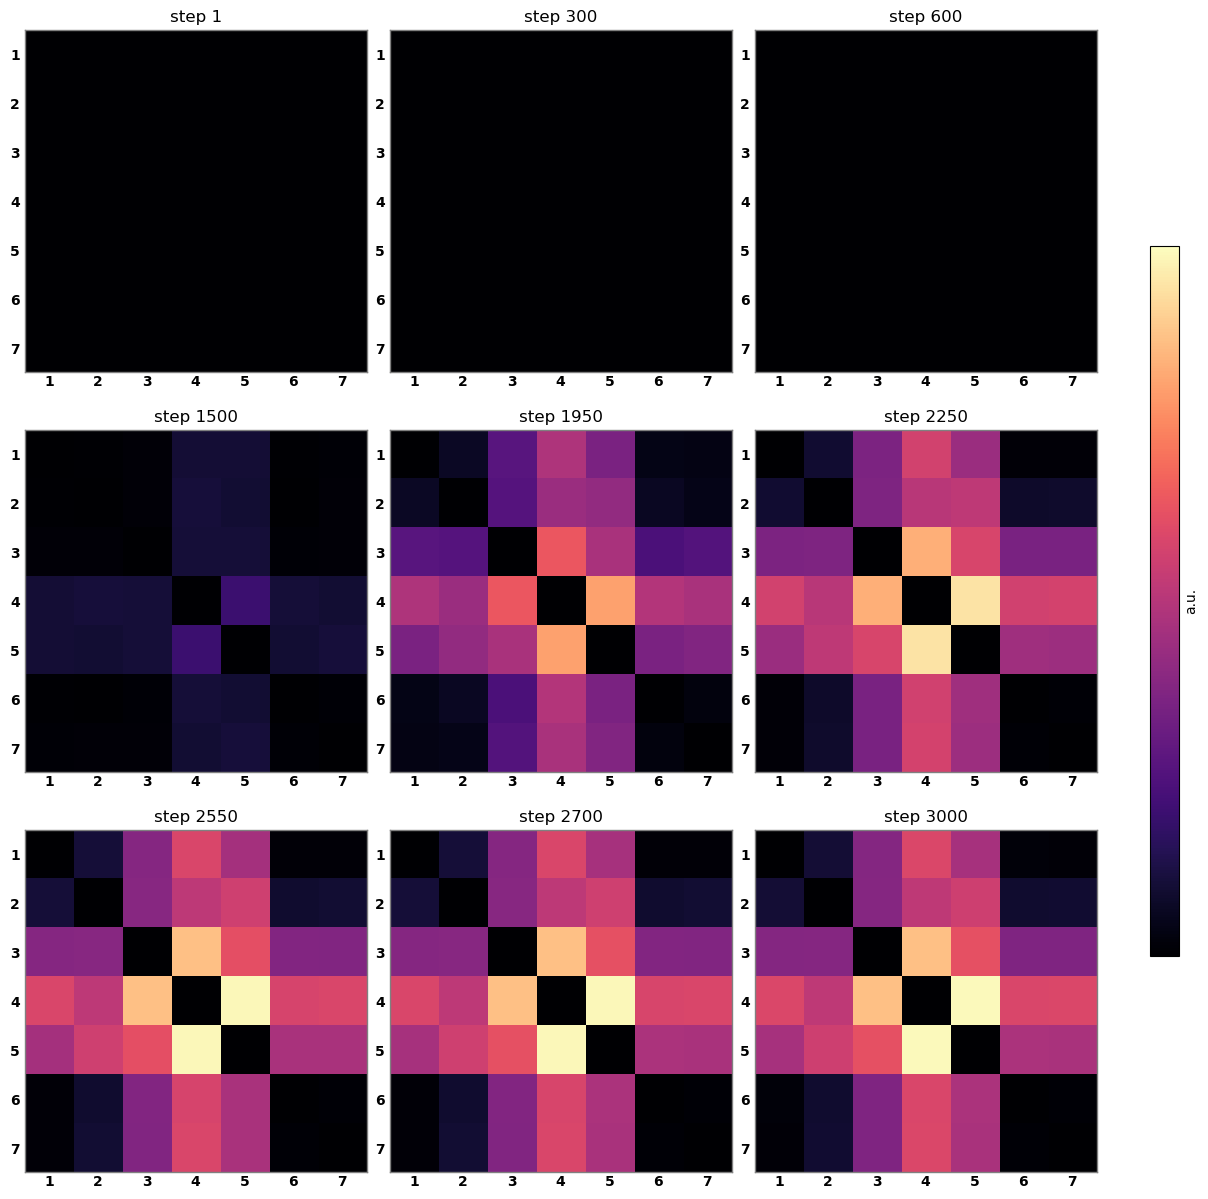

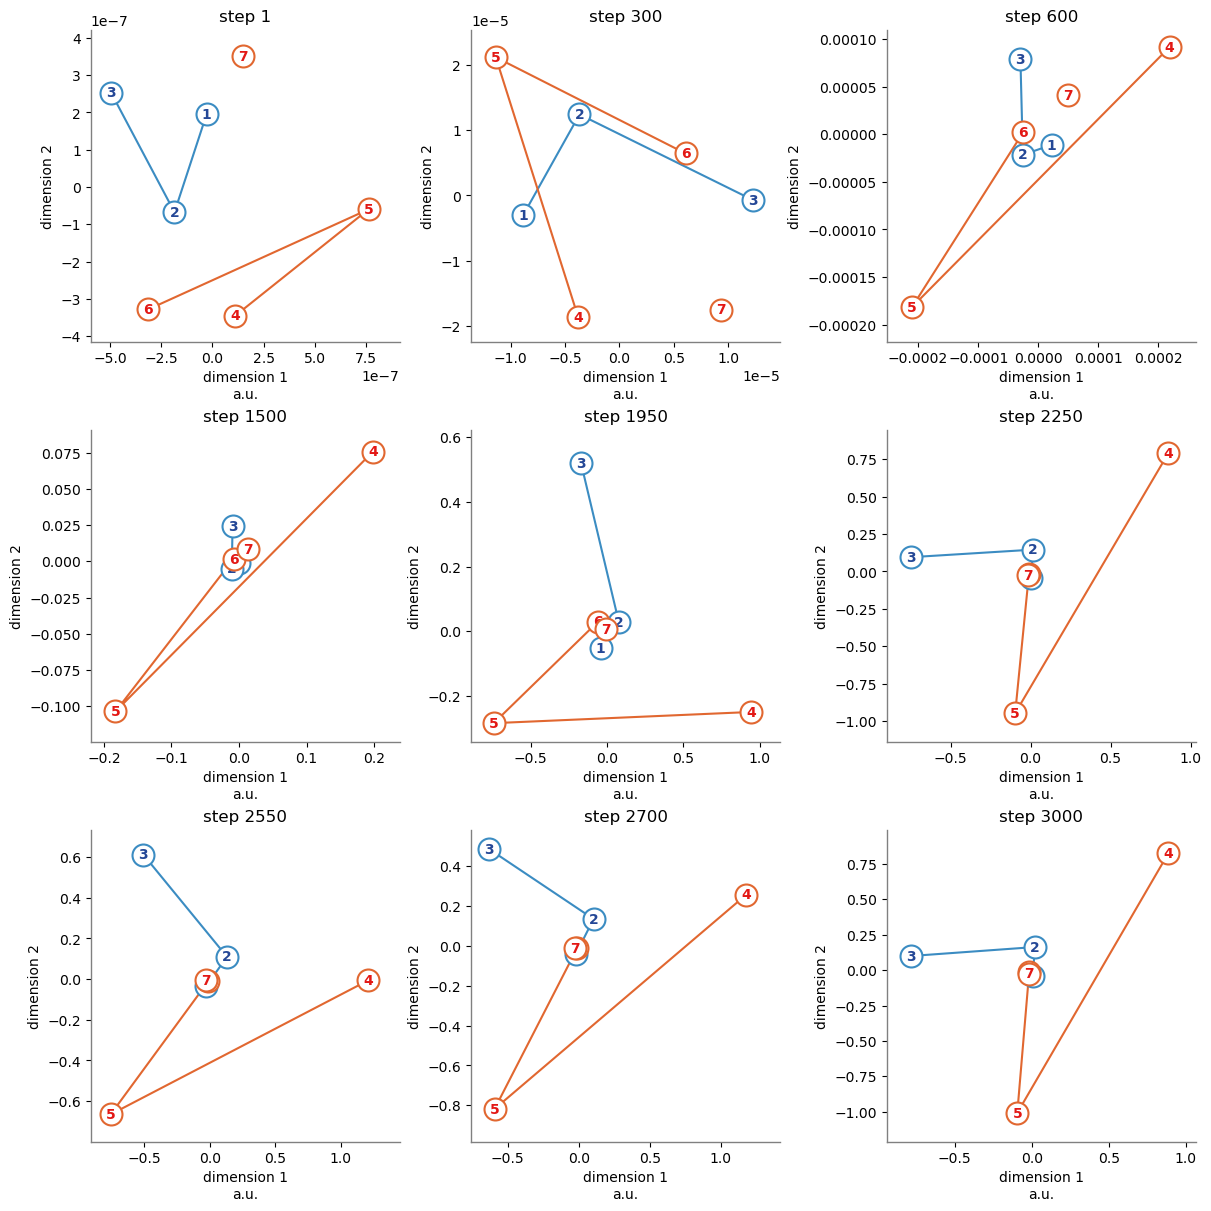

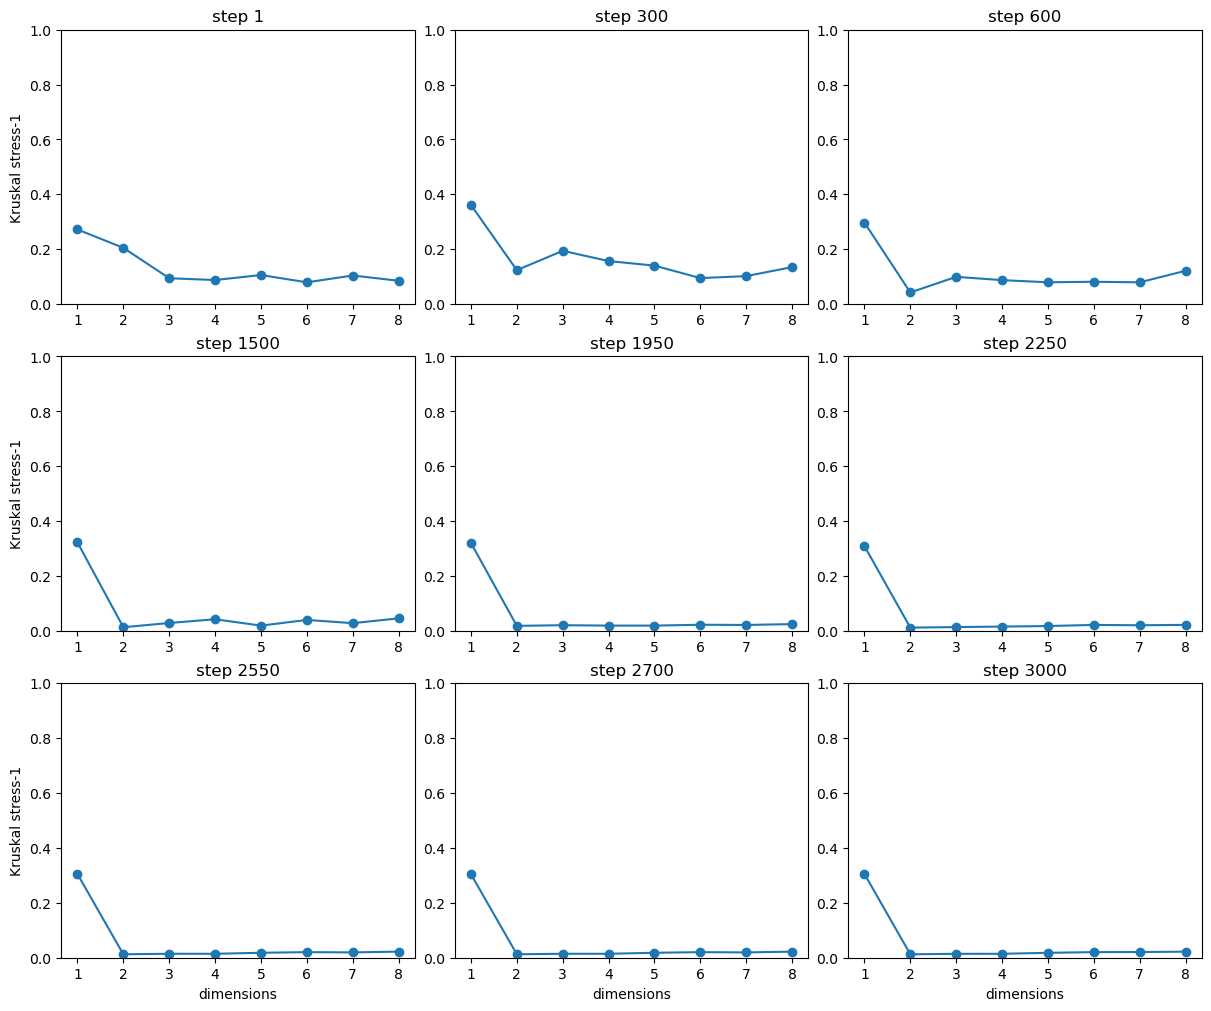

In [ ]:
#### Plot H2

# Choose nine positions across training
positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]

fig1, axs1 = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig1.patch.set_facecolor('white')

fig2, axs2 = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig2.patch.set_facecolor('white')

# Determine vmax across selected time slices
vmax = 0.0
for i in range(len(positions)):
    t_idx = max(0, int(positions[i] * steps_after_training))
    h2s = all_h2s[t_idx]
    vmax_ = float(np.round(np.max(euclidean_distances(h2s)), 1))
    if vmax_ > vmax:
        vmax = vmax_

# Distance matrices → 3x3 grid (fig1)
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    t_idx = max(0, int(p * steps_after_training))
    dists = euclidean_distances(all_h2s[t_idx])
    im = matrix_plot_safe(dists, axs1[r, c], items_n, 0., vmax)
    axs1[r, c].set_title(f"step {t_idx+1}")

cbar = fig1.colorbar(im, ax=axs1, shrink=.6, aspect=25)
cbar.set_ticks([])
cbar.ax.set_ylabel("a.u.")

# MDS embeddings → 3x3 grid (fig2)
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    t_idx = max(0, int(p * steps_after_training))
    dists = euclidean_distances(all_h2s[t_idx])
    mds = manifold.MDS(
        n_components=2,
        eps=1e-9,
        dissimilarity="precomputed",
        random_state=mds_seed,
        n_init=4,                     # keep behavior stable; silences FutureWarning
        normalized_stress="auto",
    )
    d1, d2 = mds.fit(dists).embedding_.T

    if idx % 3 == 0:
        rotate(d1, d2, 250.)
    elif idx % 3 == 1:
        rotate(d1, d2, 230.)
    else:
        rotate(d1, d2, 260.)

    mds_plot((d1, d2), axs2[r, c], items_n)
    axs2[r, c].set_title(f"step {t_idx+1}")

    for pos in ["left", "bottom"]:
        axs2[r, c].spines[pos].set_linewidth(1)
        axs2[r, c].spines[pos].set_color([0.5]*3)

    axs2[r, c].set_xlabel("dimension 1\na.u.")
    axs2[r, c].set_ylabel("dimension 2")

plt.show()

# Kruskal stress vs dimensions for the same positions (h2)
max_dims = 8
fig_stress_h2, axs_stress_h2 = plt.subplots(3, 3, figsize=(12., 10.), constrained_layout=True)
fig_stress_h2.patch.set_facecolor('white')
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    t_idx = max(0, int(p * steps_after_training))
    D = euclidean_distances(all_h2s[t_idx])
    denom = np.sum(D**2)
    stresses = []
    for k in range(1, max_dims + 1):
        m = manifold.MDS(n_components=k, dissimilarity="precomputed", random_state=mds_seed, n_init=4, normalized_stress="auto")
        m.fit(D)
        stress_raw = getattr(m, "stress_", None)
        if stress_raw is None or denom == 0:
            stresses.append(np.nan)
        else:
            stresses.append(np.sqrt(stress_raw / denom))  # Kruskal stress-1
    axs_stress_h2[r, c].plot(range(1, max_dims + 1), stresses, marker='o')
    axs_stress_h2[r, c].set_title(f"step {t_idx+1}")
    if r == 2:
        axs_stress_h2[r, c].set_xlabel("dimensions")
    if c == 0:
        axs_stress_h2[r, c].set_ylabel("Kruskal stress-1")
    axs_stress_h2[r, c].set_ylim(0.0, 1.0)
plt.show()


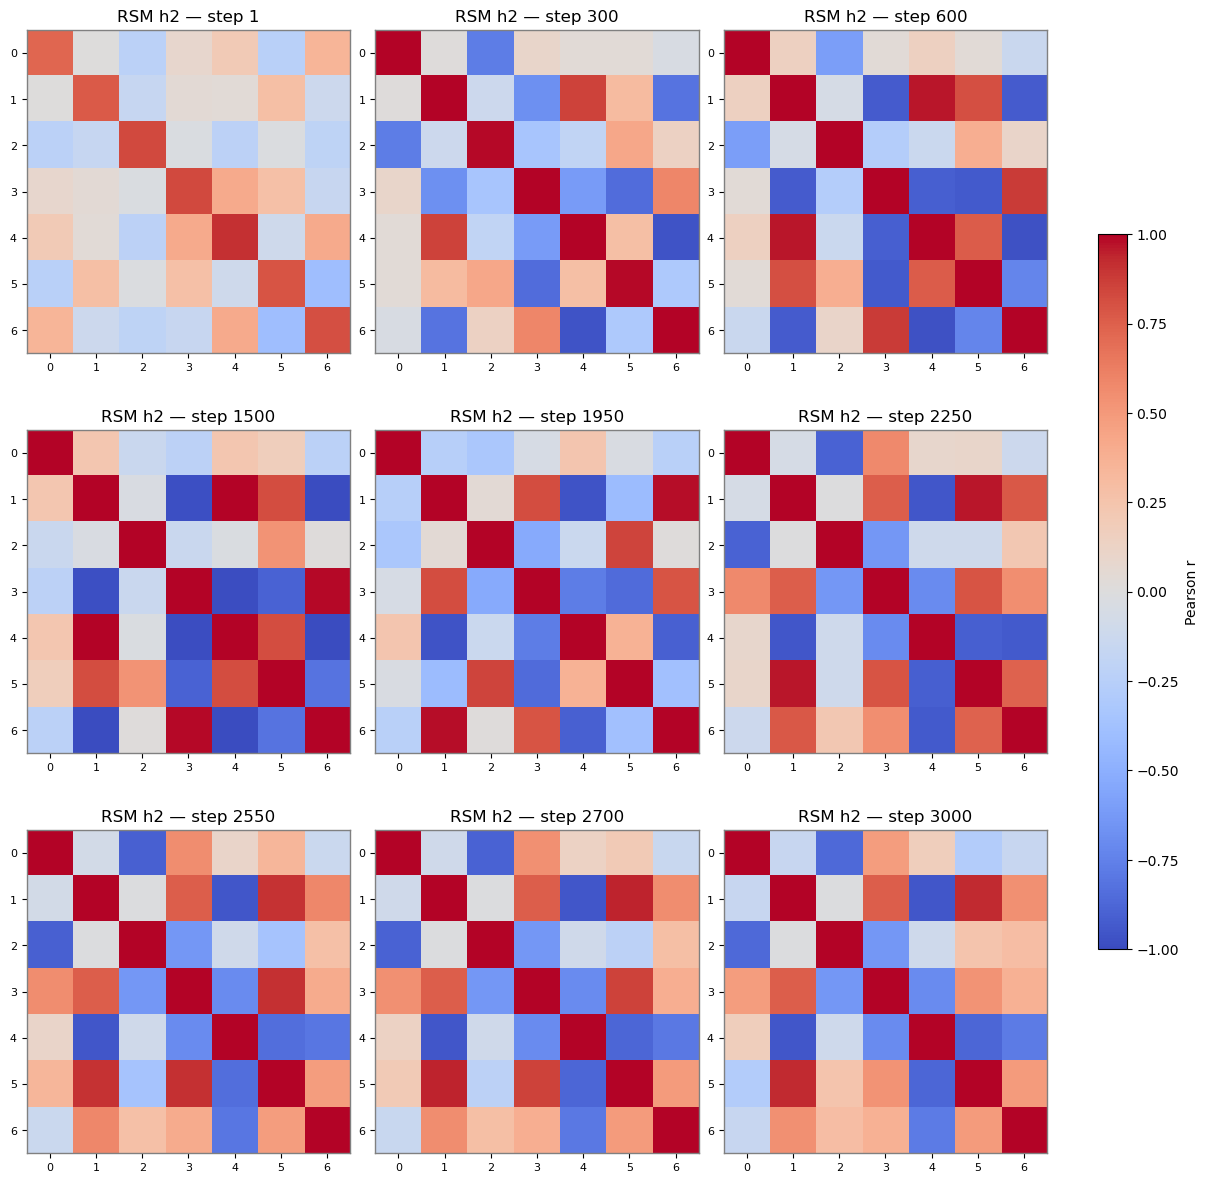

In [ ]:
# Representational Similarity Matrices (RSM) for h2 with normalization (Pearson correlation)
import numpy as np
import matplotlib.pyplot as plt

# Unwrap results and check availability
if isinstance(results, tuple):
    results = results[1]
train_dict = results.get("train", {}) if isinstance(results, dict) else {}
if "h2s" not in train_dict or train_dict["h2s"] is None:
    print("No h2s found in results['train'].")
else:
    # h2s shape: (seeds_n, time_steps, items_n, h2_size)
    H2 = train_dict["h2s"]
    H2_avg = np.nan_to_num(H2.mean(axis=0), nan=0.0, posinf=0.0, neginf=0.0)  # (time_steps, items_n, h2_size)
    time_steps, items_n_inferred, h2_size = H2_avg.shape

    # Positions to display
    positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]
    steps_after_training = time_steps - 1

    fig, axs = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
    fig.patch.set_facecolor('white')

    im = None
    for idx, p in enumerate(positions):
        r, c = divmod(idx, 3)
        t_idx = max(0, int(p * steps_after_training))
        X = H2_avg[t_idx]  # (items_n, h2_size)
        # Normalize each item's vector (z-score across features) for Pearson correlation
        X = X - X.mean(axis=1, keepdims=True)
        denom = X.std(axis=1, keepdims=True) + 1e-8
        Xn = X / denom
        # Pearson similarity between items (i by j)
        sim = (Xn @ Xn.T) / Xn.shape[1]
        sim = np.clip(sim, -1.0, 1.0)
        # Handle any numerical NaNs
        sim = np.nan_to_num(sim, nan=0.0, posinf=0.0, neginf=0.0)

        ax = axs[r, c]
        im = ax.imshow(sim, vmin=-1, vmax=1, cmap='coolwarm')
        ax.set_title(f"RSM h2 — step {t_idx+1}")
        ax.set_xticks(range(items_n_inferred))
        ax.set_yticks(range(items_n_inferred))
        ax.set_xticklabels([str(i) for i in range(items_n_inferred)])
        ax.set_yticklabels([str(i) for i in range(items_n_inferred)])
        ax.tick_params(axis='both', labelsize=8)
        for pos in ["top", "right", "bottom", "left"]:
            ax.spines[pos].set_linewidth(1)
            ax.spines[pos].set_color([0.5] * 3)

    cbar = fig.colorbar(im, ax=axs, shrink=.6, aspect=25)
    cbar.set_label('Pearson r')
    plt.show()


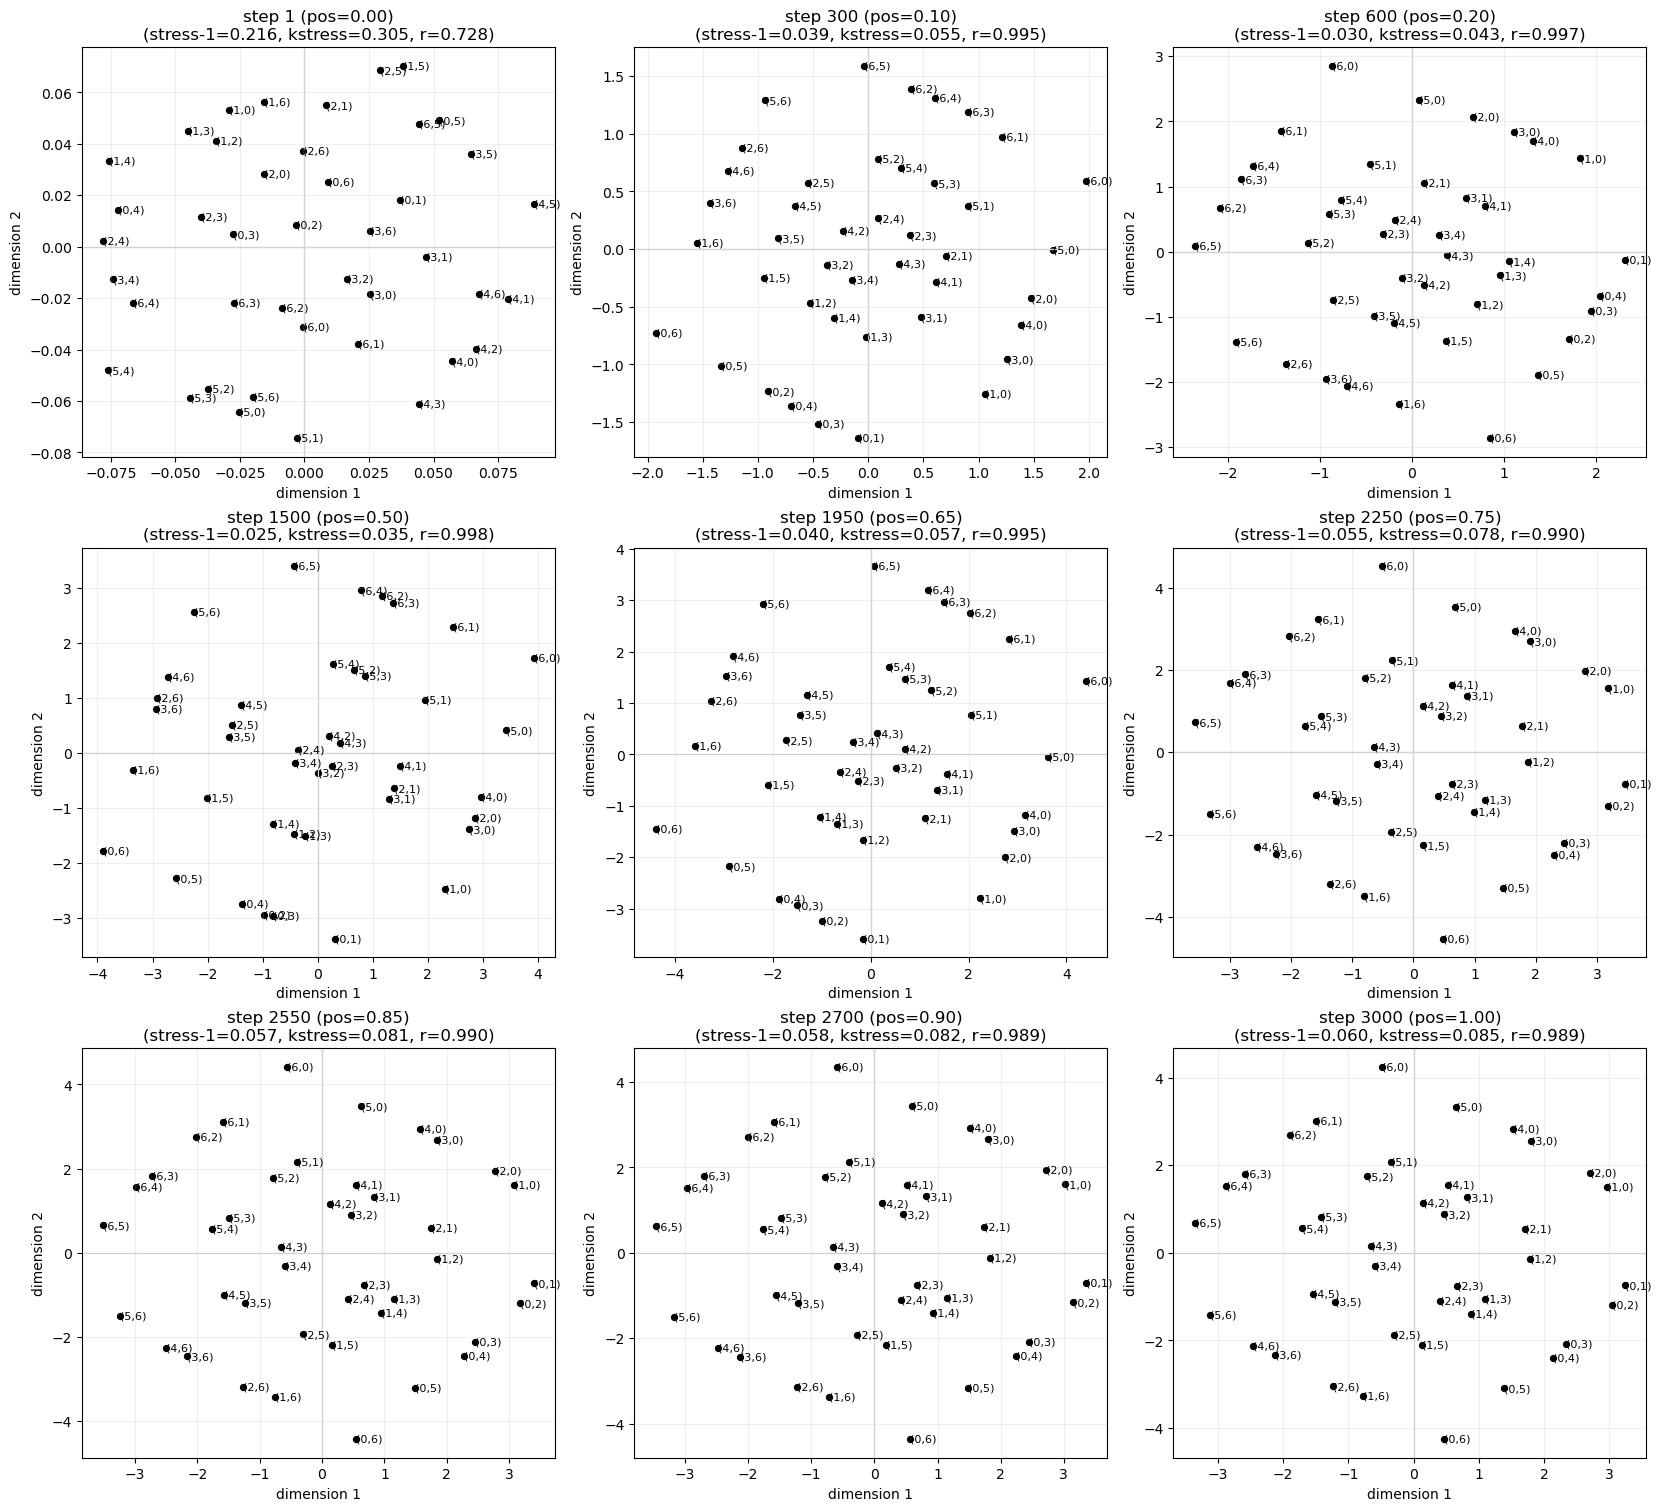

In [ ]:
# MDS of all ordered pairs (h1, from CSV) at all requested steps, with Kruskal stress-1 and (raw) Kruskal stress
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from scipy.stats import pearsonr
import pandas as pd

# Use CSV-loaded h1 data if available; else load from gz in this folder
if 'all_h1s' in globals():
    H1_avg = all_h1s  # shape: (time_steps, items_n, h1_size) already averaged across seeds
else:
    def load_h1_mean_from_csv_gz(csv_gz_path):
        df = pd.read_csv(csv_gz_path, compression='gzip')
        seed_cols = [c for c in df.columns if c.startswith('seed_')]
        # Mean across seeds per (time_step, item, unit)
        grouped = df.groupby(['time_step', 'item', 'unit'])[seed_cols].mean()
        mean_series = grouped.mean(axis=1)  # average across seed columns
        time_steps = int(df['time_step'].max()) + 1
        items_n_inferred = int(df['item'].max()) + 1
        units = int(df['unit'].max()) + 1
        arr = np.zeros((time_steps, items_n_inferred, units))
        for (t, i, u), val in mean_series.items():
            arr[int(t), int(i), int(u)] = float(val)
        return arr
    # Try local gz produced earlier in this notebook
    H1_avg = load_h1_mean_from_csv_gz('conjunctive_lazy_rich_h1s.csv.gz')

time_steps, items_n_inferred, h1_size = H1_avg.shape

# Positions to display, used previously
positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]
steps_after_training = time_steps - 1
step_idxs = [max(0, int(p * steps_after_training)) for p in positions]

# Utility to build all concatenated ordered pairs (i!=j)
def build_pairs(X_items):
    vecs, labels, pairs = [], [], []
    for i in range(items_n_inferred):
        for j in range(items_n_inferred):
            if i == j:
                continue
            v = np.concatenate([X_items[i], X_items[j]], axis=0)
            vecs.append(v)
            labels.append(f"({i},{j})")
            pairs.append((i, j))
    V = np.asarray(vecs)
    # mean-center features in each matrix for each step, stabilizes MDS
    V = V - V.mean(axis=0, keepdims=True)
    return V, labels, pairs

# Fit 2D metric MDS on each distance matrix; report Kruskal stress-1 and Kruskal stress (raw)
def fit_mds_with_stress(D, seed):
    mds = manifold.MDS(
        n_components=2,
        dissimilarity='precomputed',
        random_state=seed,
        n_init=4,
        normalized_stress='auto',
    )
    fit_result = mds.fit(D)
    coords = fit_result.embedding_
    stress_raw = getattr(mds, 'stress_', None)
    denom = float(np.sum(D ** 2))
    # Kruskal's stress-1 as in sklearn docs: sqrt( sum((d_ij - d̂_ij)^2) / sum(d_ij^2) )
    stress1 = np.sqrt(stress_raw / denom) if (stress_raw is not None and denom > 0) else np.nan

    # Compute the reconstructed distances
    Dr = euclidean_distances(coords)
    # Use only upper triangle (excluding diagonal)
    orig = D[np.triu_indices_from(D, k=1)]
    rec = Dr[np.triu_indices_from(Dr, k=1)]
    # Kruskal's raw stress
    kruskal_stress = np.sqrt(np.sum((orig - rec) ** 2) / np.sum(orig ** 2)) if np.sum(orig ** 2) > 0 else np.nan

    # For reporting: also include Pearson r between dist matrices
    if len(orig) > 1:
        r, _ = pearsonr(orig, rec)
    else:
        r = np.nan

    return coords, stress1, kruskal_stress, r

seed = mds_seed if 'mds_seed' in globals() else 0

nsteps = len(step_idxs)
ncols = 3
nrows = int(np.ceil(nsteps / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(5.5*ncols, 5*nrows), constrained_layout=True)

for pidx, (pos, step_idx) in enumerate(zip(positions, step_idxs)):
    V, labels, pairs = build_pairs(H1_avg[step_idx])
    D = euclidean_distances(V)
    coords, stress1, kst, r = fit_mds_with_stress(D, seed)
    r_ax = pidx // ncols
    c_ax = pidx % ncols
    ax = axs[r_ax, c_ax] if nrows > 1 else axs[c_ax]
    ax.scatter(coords[:, 0], coords[:, 1], s=18, color='k')
    for i, lab in enumerate(labels):
        ax.text(coords[i, 0], coords[i, 1], lab, fontsize=8, ha='left', va='center')
    ax.axhline(0, color='lightgray', linewidth=1)
    ax.axvline(0, color='lightgray', linewidth=1)
    ax.grid(True, alpha=0.2)
    ax.set_title(
        f"step {step_idx+1} (pos={pos:.2f})\n"
        f"(stress-1={stress1:.3f}, kstress={kst:.3f}, r={r:.3f})"
    )
    ax.set_xlabel('dimension 1')
    ax.set_ylabel('dimension 2')

# Remove any excess unused subplots
for k in range(nsteps, nrows*ncols):
    fig.delaxes(axs.flatten()[k])

plt.show()


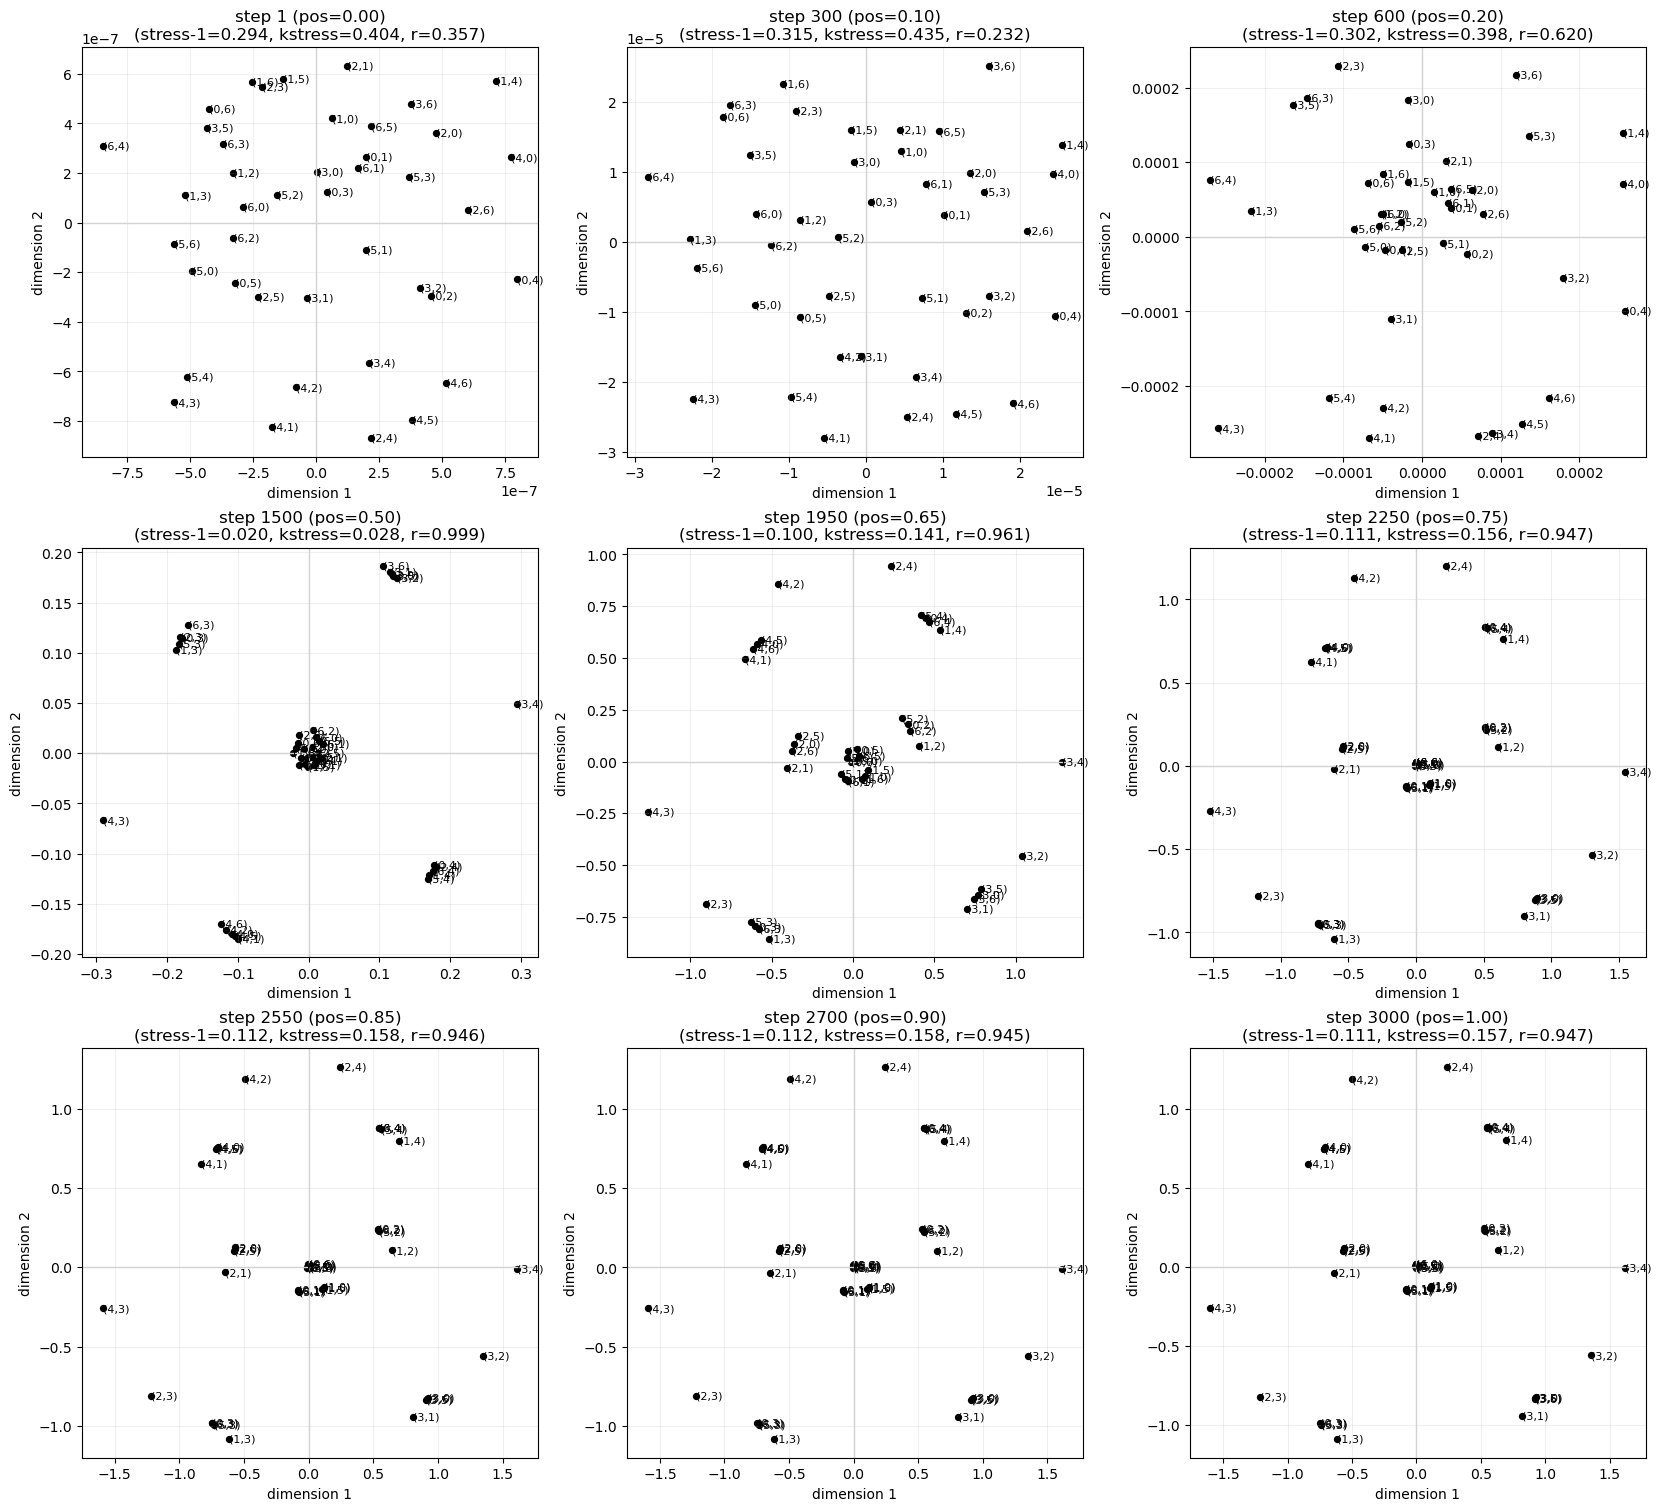

In [ ]:
# MDS of all ordered pairs (h2, from CSV) at all requested steps, with Kruskal stress-1 and (raw) Kruskal stress
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from scipy.stats import pearsonr
import pandas as pd

# Use CSV-loaded h2 data if available; else load from gz in this folder
if 'all_h2s' in globals():
    H2_avg = all_h2s  # shape: (time_steps, items_n, h2_size) already averaged across seeds
else:
    def load_h2_mean_from_csv_gz(csv_gz_path):
        df = pd.read_csv(csv_gz_path, compression='gzip')
        seed_cols = [c for c in df.columns if c.startswith('seed_')]
        # Mean across seeds per (time_step, item, unit)
        grouped = df.groupby(['time_step', 'item', 'unit'])[seed_cols].mean()
        mean_series = grouped.mean(axis=1)  # average across seed columns
        time_steps = int(df['time_step'].max()) + 1
        items_n_inferred = int(df['item'].max()) + 1
        units = int(df['unit'].max()) + 1
        arr = np.zeros((time_steps, items_n_inferred, units))
        for (t, i, u), val in mean_series.items():
            arr[int(t), int(i), int(u)] = float(val)
        return arr
    # Try local gz produced earlier in this notebook
    H2_avg = load_h2_mean_from_csv_gz('conjunctive_lazy_rich_h2s.csv.gz')

time_steps, items_n_inferred, h2_size = H2_avg.shape

# Positions to display, used previously
positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]
steps_after_training = time_steps - 1
step_idxs = [max(0, int(p * steps_after_training)) for p in positions]

# Utility to build all concatenated ordered pairs (i!=j)
def build_pairs(X_items):
    vecs, labels, pairs = [], [], []
    for i in range(items_n_inferred):
        for j in range(items_n_inferred):
            if i == j:
                continue
            v = np.concatenate([X_items[i], X_items[j]], axis=0)
            vecs.append(v)
            labels.append(f"({i},{j})")
            pairs.append((i, j))
    V = np.asarray(vecs)
    # mean-center features in each matrix for each step, stabilizes MDS
    V = V - V.mean(axis=0, keepdims=True)
    return V, labels, pairs

# Fit 2D metric MDS on each distance matrix; report Kruskal stress-1 and Kruskal stress (raw)
def fit_mds_with_stress(D, seed):
    mds = manifold.MDS(
        n_components=2,
        dissimilarity='precomputed',
        random_state=seed,
        n_init=4,
        normalized_stress='auto',
    )
    fit_result = mds.fit(D)
    coords = fit_result.embedding_
    stress_raw = getattr(mds, 'stress_', None)
    denom = float(np.sum(D ** 2))
    # Kruskal's stress-1 as in sklearn docs: sqrt( sum((d_ij - d̂_ij)^2) / sum(d_ij^2) )
    stress1 = np.sqrt(stress_raw / denom) if (stress_raw is not None and denom > 0) else np.nan

    # Compute the reconstructed distances
    Dr = euclidean_distances(coords)
    # Use only upper triangle (excluding diagonal)
    orig = D[np.triu_indices_from(D, k=1)]
    rec = Dr[np.triu_indices_from(Dr, k=1)]
    # Kruskal's raw stress
    kruskal_stress = np.sqrt(np.sum((orig - rec) ** 2) / np.sum(orig ** 2)) if np.sum(orig ** 2) > 0 else np.nan

    # For reporting: also include Pearson r between dist matrices
    if len(orig) > 1:
        r, _ = pearsonr(orig, rec)
    else:
        r = np.nan

    return coords, stress1, kruskal_stress, r

seed = mds_seed if 'mds_seed' in globals() else 0

nsteps = len(step_idxs)
ncols = 3
nrows = int(np.ceil(nsteps / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(5.5*ncols, 5*nrows), constrained_layout=True)

for pidx, (pos, step_idx) in enumerate(zip(positions, step_idxs)):
    V, labels, pairs = build_pairs(H2_avg[step_idx])
    D = euclidean_distances(V)
    coords, stress1, kst, r = fit_mds_with_stress(D, seed)
    r_ax = pidx // ncols
    c_ax = pidx % ncols
    ax = axs[r_ax, c_ax] if nrows > 1 else axs[c_ax]
    ax.scatter(coords[:, 0], coords[:, 1], s=18, color='k')
    for i, lab in enumerate(labels):
        ax.text(coords[i, 0], coords[i, 1], lab, fontsize=8, ha='left', va='center')
    ax.axhline(0, color='lightgray', linewidth=1)
    ax.axvline(0, color='lightgray', linewidth=1)
    ax.grid(True, alpha=0.2)
    ax.set_title(
        f"step {step_idx+1} (pos={pos:.2f})\n"
        f"(stress-1={stress1:.3f}, kstress={kst:.3f}, r={r:.3f})"
    )
    ax.set_xlabel('dimension 1')
    ax.set_ylabel('dimension 2')

# Remove any excess unused subplots
for k in range(nsteps, nrows*ncols):
    fig.delaxes(axs.flatten()[k])

plt.show()


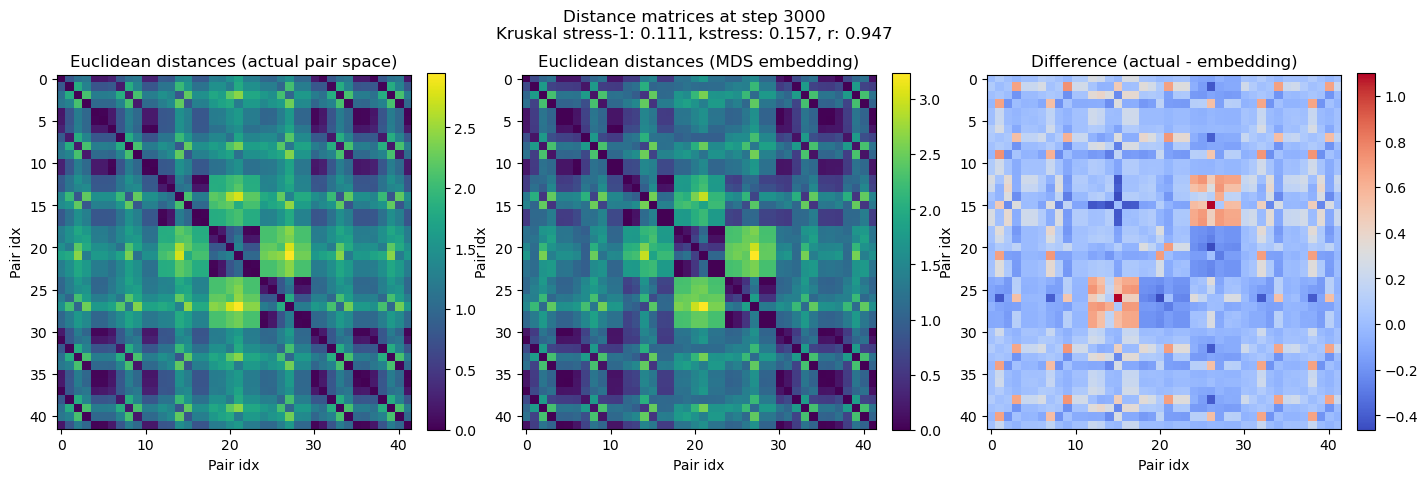

In [ ]:
# For the most recent MDS step, compute and display the distance matrices in the actual space and the embedding (MDS) space,
# and also plot the difference between the two.

# We'll use the latest position in the previous loop, i.e., last pos and last step_idx
step_idx = step_idxs[-1]
V, labels, pairs = build_pairs(H2_avg[step_idx])
D_actual = euclidean_distances(V)

# Fit MDS to get embedding
coords, stress1, kst, r = fit_mds_with_stress(D_actual, seed)
D_embedded = euclidean_distances(coords)

# Compute the difference matrix (actual - embedded)
D_diff = D_actual - D_embedded

# Show as heatmaps side by side for visual comparison, with a third panel for the difference
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

# Actual distances
im0 = axs[0].imshow(D_actual, cmap="viridis")
axs[0].set_title("Euclidean distances (actual pair space)")
axs[0].set_xlabel("Pair idx")
axs[0].set_ylabel("Pair idx")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# Embedded distances
im1 = axs[1].imshow(D_embedded, cmap="viridis")
axs[1].set_title("Euclidean distances (MDS embedding)")
axs[1].set_xlabel("Pair idx")
axs[1].set_ylabel("Pair idx")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# Difference
im2 = axs[2].imshow(D_diff, cmap="coolwarm")
axs[2].set_title("Difference (actual - embedding)")
axs[2].set_xlabel("Pair idx")
axs[2].set_ylabel("Pair idx")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

plt.suptitle(
    f"Distance matrices at step {step_idx+1}\n"
    f"Kruskal stress-1: {stress1:.3f}, kstress: {kst:.3f}, r: {r:.3f}"
)
plt.show()

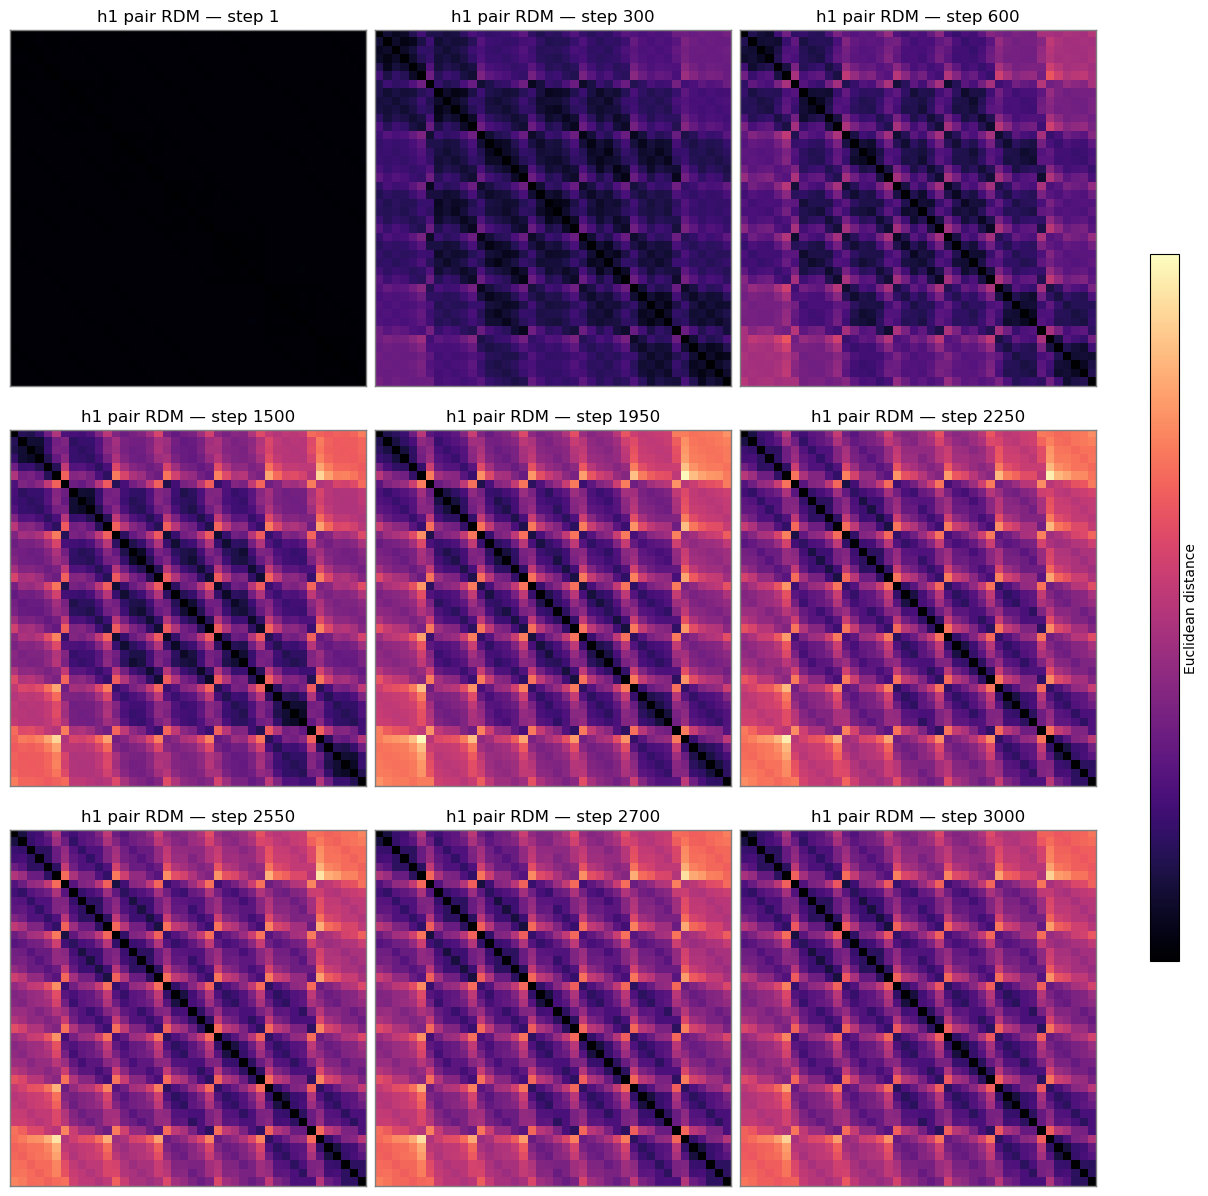

x-axis pairings for the h1 pair RDMs (plot order):

0: (0,1)
1: (0,2)
2: (0,3)
3: (0,4)
4: (0,5)
5: (0,6)
6: (1,0)
7: (1,2)
8: (1,3)
9: (1,4)
10: (1,5)
11: (1,6)
12: (2,0)
13: (2,1)
14: (2,3)
15: (2,4)
16: (2,5)
17: (2,6)
18: (3,0)
19: (3,1)
20: (3,2)
21: (3,4)
22: (3,5)
23: (3,6)
24: (4,0)
25: (4,1)
26: (4,2)
27: (4,3)
28: (4,5)
29: (4,6)
30: (5,0)
31: (5,1)
32: (5,2)
33: (5,3)
34: (5,4)
35: (5,6)
36: (6,0)
37: (6,1)
38: (6,2)
39: (6,3)
40: (6,4)
41: (6,5)


In [ ]:
# Pair RDMs (Euclidean) for h1 pair embeddings across nine positions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances

def load_layer_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression='gzip')
    seed_cols = [c for c in df.columns if c.startswith('seed_')]
    time_steps = int(df['time_step'].max()) + 1
    items_n = int(df['item'].max()) + 1
    units = int(df['unit'].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, time_steps, items_n, units))
    for _, row in df.iterrows():
        t = int(row['time_step']); i = int(row['item']); u = int(row['unit'])
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, t, i, u] = row[sc]
    return arr  # (seeds, time, items, units)

def build_pair_vectors(X_items):
    # Ordered pairs (i != j), feature = concat(X[i], X[j])
    vecs, labels = [], []
    n = X_items.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            v = np.concatenate([X_items[i], X_items[j]], axis=0)
            vecs.append(v)
            labels.append(f"({i},{j})")
    V = np.asarray(vecs)
    V = np.nan_to_num(V, nan=0.0, posinf=0.0, neginf=0.0)
    V = V - V.mean(axis=0, keepdims=True)
    return V, labels

# Load h1s from gzipped CSV and average across seeds
csv_gz_h1_path = "conjunctive_lazy_rich_h1s.csv.gz"
H1 = load_layer_from_csv_gz(csv_gz_h1_path).mean(axis=0)  # (time, items, h1)
items_n = H1.shape[1]
steps_after = H1.shape[0] - 1

# Same nine positions as above
positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]

# Find shared vmax across selected steps for consistent color scale
vmax = 0.0
for p in positions:
    t_idx = max(0, int(p * steps_after))
    X_items = np.nan_to_num(H1[t_idx], nan=0.0, posinf=0.0, neginf=0.0)
    V, _ = build_pair_vectors(X_items)
    D = euclidean_distances(V)
    vmax = max(vmax, float(np.ceil(np.max(D) * 10) / 10.0))
if vmax == 0.0:
    vmax = 1.0

fig, axs = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig.patch.set_facecolor('white')

for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    t_idx = max(0, int(p * steps_after))
    X_items = np.nan_to_num(H1[t_idx], nan=0.0, posinf=0.0, neginf=0.0)
    V, labels = build_pair_vectors(X_items)
    D = euclidean_distances(V)  # RDM of pairs

    ax = axs[r, c]
    im = ax.imshow(D, cmap=plt.cm.magma, vmin=0.0, vmax=vmax, interpolation='nearest')
    ax.set_title(f"h1 pair RDM — step {t_idx+1}")
    # Too many pairs to label ticks cleanly; hide ticks for readability
    ax.set_xticks([])
    ax.set_yticks([])
    for pos in ["top", "right", "bottom", "left"]:
        ax.spines[pos].set_linewidth(1)
        ax.spines[pos].set_color([0.5]*3)

cbar = fig.colorbar(im, ax=axs, shrink=.6, aspect=25)
cbar.set_ticks([])
cbar.ax.set_ylabel("Euclidean distance")
plt.show()

# Write out the x axes pairings (labels) used in the RDM plots above.
print("x-axis pairings for the h1 pair RDMs (plot order):\n")
for idx, label in enumerate(labels):
    print(f"{idx}: {label}")


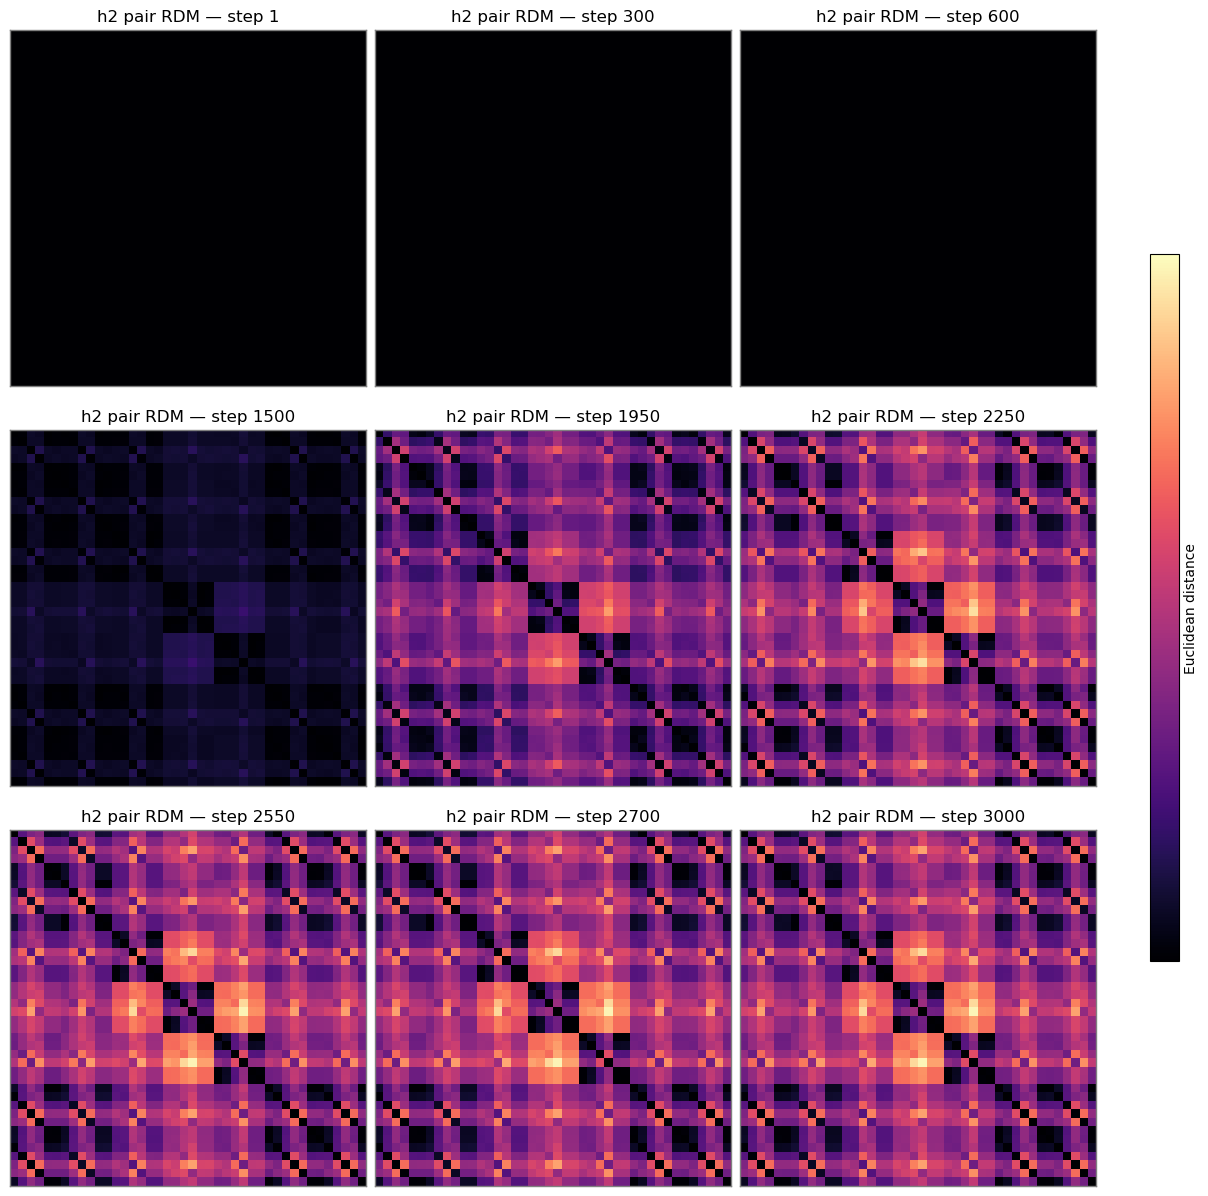

x-axis pairings for the h2 pair RDMs (plot order):

0: (0,1)
1: (0,2)
2: (0,3)
3: (0,4)
4: (0,5)
5: (0,6)
6: (1,0)
7: (1,2)
8: (1,3)
9: (1,4)
10: (1,5)
11: (1,6)
12: (2,0)
13: (2,1)
14: (2,3)
15: (2,4)
16: (2,5)
17: (2,6)
18: (3,0)
19: (3,1)
20: (3,2)
21: (3,4)
22: (3,5)
23: (3,6)
24: (4,0)
25: (4,1)
26: (4,2)
27: (4,3)
28: (4,5)
29: (4,6)
30: (5,0)
31: (5,1)
32: (5,2)
33: (5,3)
34: (5,4)
35: (5,6)
36: (6,0)
37: (6,1)
38: (6,2)
39: (6,3)
40: (6,4)
41: (6,5)


In [ ]:
# Pair RDMs (Euclidean) for h2 pair embeddings across nine positions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import euclidean_distances

def load_layer_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression='gzip')
    seed_cols = [c for c in df.columns if c.startswith('seed_')]
    time_steps = int(df['time_step'].max()) + 1
    items_n = int(df['item'].max()) + 1
    units = int(df['unit'].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, time_steps, items_n, units))
    for _, row in df.iterrows():
        t = int(row['time_step']); i = int(row['item']); u = int(row['unit'])
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, t, i, u] = row[sc]
    return arr  # (seeds, time, items, units)

def build_pair_vectors(X_items):
    # Ordered pairs (i != j), feature = concat(X[i], X[j])
    vecs, labels = [], []
    n = X_items.shape[0]
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            v = np.concatenate([X_items[i], X_items[j]], axis=0)
            vecs.append(v)
            labels.append(f"({i},{j})")
    V = np.asarray(vecs)
    V = np.nan_to_num(V, nan=0.0, posinf=0.0, neginf=0.0)
    V = V - V.mean(axis=0, keepdims=True)
    return V, labels

# Load h2s from gzipped CSV and average across seeds
csv_gz_h2_path = "conjunctive_lazy_rich_h2s.csv.gz"
H2 = load_layer_from_csv_gz(csv_gz_h2_path).mean(axis=0)  # (time, items, h2)
items_n = H2.shape[1]
steps_after = H2.shape[0] - 1

# Same nine positions as above
positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]

# Find shared vmax across selected steps for consistent color scale
vmax = 0.0
for p in positions:
    t_idx = max(0, int(p * steps_after))
    X_items = np.nan_to_num(H2[t_idx], nan=0.0, posinf=0.0, neginf=0.0)
    V, _ = build_pair_vectors(X_items)
    D = euclidean_distances(V)
    vmax = max(vmax, float(np.ceil(np.max(D) * 10) / 10.0))
if vmax == 0.0:
    vmax = 1.0

fig, axs = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig.patch.set_facecolor('white')

for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    t_idx = max(0, int(p * steps_after))
    X_items = np.nan_to_num(H2[t_idx], nan=0.0, posinf=0.0, neginf=0.0)
    V, labels = build_pair_vectors(X_items)
    D = euclidean_distances(V)  # RDM of pairs

    ax = axs[r, c]
    im = ax.imshow(D, cmap=plt.cm.magma, vmin=0.0, vmax=vmax, interpolation='nearest')
    ax.set_title(f"h2 pair RDM — step {t_idx+1}")
    # Too many pairs to label ticks cleanly; hide ticks for readability
    ax.set_xticks([])
    ax.set_yticks([])
    for pos in ["top", "right", "bottom", "left"]:
        ax.spines[pos].set_linewidth(1)
        ax.spines[pos].set_color([0.5]*3)

cbar = fig.colorbar(im, ax=axs, shrink=.6, aspect=25)
cbar.set_ticks([])
cbar.ax.set_ylabel("Euclidean distance")
plt.show()

# Write out the x axes pairings (labels) used in the RDM plots above.
print("x-axis pairings for the h2 pair RDMs (plot order):\n")
for idx, label in enumerate(labels):
    print(f"{idx}: {label}")


In [ ]:
# For the highest values in the difference matrix, print the pairs (row, col) and the values.
# Also print exactly what the pairing is in terms of items.

# How many to print:
top_n = 10

# If labels is not already available, rebuild
if 'labels' not in locals():
    _, labels, _ = build_pairs(H2_avg[step_idx])

# Get the indices of the largest absolute differences (excluding diagonal)
D_diff_no_diag = D_diff.copy()
np.fill_diagonal(D_diff_no_diag, 0)  # so diag is not included in top abs

flat_indices = np.abs(D_diff_no_diag).ravel().argsort()[::-1]  # descending
rows, cols = np.unravel_index(flat_indices, D_diff.shape)

printed = 0
seen = set()
print("Top differences between actual and embedded distances:")
for r, c in zip(rows, cols):
    if r == c:
        continue  # skip diagonal
    # Show each unordered pair just once:
    if (c, r) in seen or (r, c) in seen: 
        continue
    # Try to retrieve the actual underlying items for these rows and cols, using the pair labels
    label_r = labels[r] if r < len(labels) else f"({r} out of bounds)"
    label_c = labels[c] if c < len(labels) else f"({c} out of bounds)"
    print(
        f"Pair ({r}, {c}): {D_diff[r, c]:.5f} | actual={D_actual[r, c]:.5f} | embedded={D_embedded[r, c]:.5f}\n"
        f"    Pairing: {label_r} vs {label_c}"
    )
    seen.add((r, c))
    printed += 1
    if printed >= top_n:
        break



Top differences between actual and embedded distances:
Pair (26, 15): 1.09807 | actual=1.84659 | embedded=0.74852
    Pairing: (4,2) vs (2,4)
Pair (1, 9): 0.73596 | actual=1.32253 | embedded=0.58657
    Pairing: (0,2) vs (1,4)
Pair (9, 38): 0.72558 | actual=1.32006 | embedded=0.59448
    Pairing: (1,4) vs (6,2)
Pair (12, 25): 0.72522 | actual=1.32253 | embedded=0.59731
    Pairing: (2,0) vs (4,1)
Pair (32, 9): 0.71749 | actual=1.31817 | embedded=0.60069
    Pairing: (5,2) vs (1,4)
Pair (13, 27): 0.71526 | actual=1.70384 | embedded=0.98858
    Pairing: (2,1) vs (4,3)
Pair (17, 25): 0.71435 | actual=1.32006 | embedded=0.60570
    Pairing: (2,6) vs (4,1)
Pair (21, 7): 0.71031 | actual=1.70384 | embedded=0.99353
    Pairing: (3,4) vs (1,2)
Pair (16, 25): 0.70605 | actual=1.31817 | embedded=0.61212
    Pairing: (2,5) vs (4,1)
Pair (27, 16): 0.70168 | actual=1.79627 | embedded=1.09460
    Pairing: (4,3) vs (2,5)


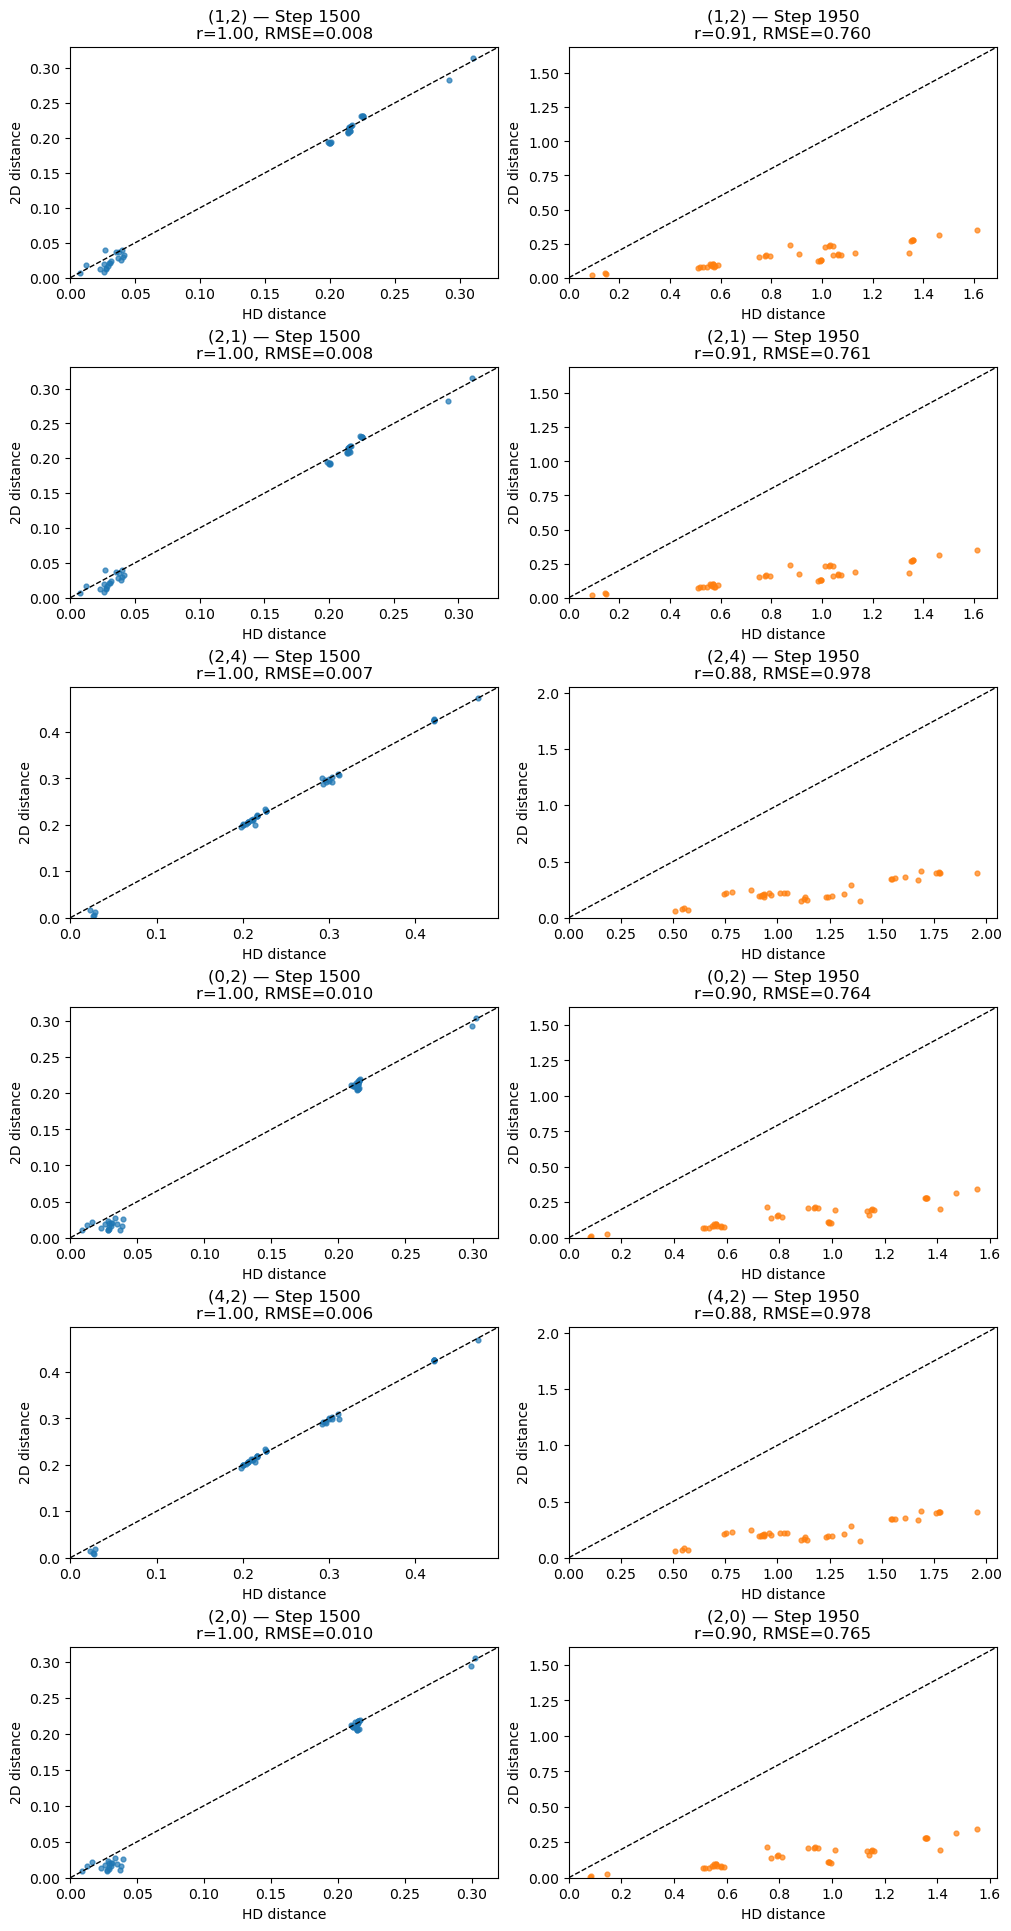

pair_label, 2D_disp, HD_feature_disp
(1,2), 0.101, 0.532
(2,1), 0.101, 0.532
(2,4), 0.091, 0.788
(0,2), 0.086, 0.530
(4,2), 0.086, 0.788
(2,0), 0.086, 0.530


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from scipy.linalg import orthogonal_procrustes
import pandas as pd

# Get H2_avg (time_steps, items_n, h2_size) from CSV if not already present
if 'all_h2s' in globals():
    H2_avg = all_h2s
else:
    def load_h2_mean_from_csv_gz(csv_gz_path):
        df = pd.read_csv(csv_gz_path, compression='gzip')
        seed_cols = [c for c in df.columns if c.startswith('seed_')]
        grouped = df.groupby(['time_step', 'item', 'unit'])[seed_cols].mean()
        mean_series = grouped.mean(axis=1)
        T = int(df['time_step'].max()) + 1
        I = int(df['item'].max()) + 1
        U = int(df['unit'].max()) + 1
        arr = np.zeros((T, I, U))
        for (t, i, u), val in mean_series.items():
            arr[int(t), int(i), int(u)] = float(val)
        return arr
    H2_avg = load_h2_mean_from_csv_gz('conjunctive_lazy_rich_h2s.csv.gz')

time_steps, items_n_inferred, h2_size = H2_avg.shape
step_a = min(1500, time_steps - 1)
step_b = min(1950, time_steps - 1)
seed = mds_seed if 'mds_seed' in globals() else 0

def build_pairs(X_items):
    vecs, labels = [], []
    for i in range(items_n_inferred):
        for j in range(items_n_inferred):
            if i == j:
                continue
            v = np.concatenate([X_items[i], X_items[j]], axis=0)
            vecs.append(v)
            labels.append(f"({i},{j})")
    V = np.asarray(vecs)
    V = V - V.mean(axis=0, keepdims=True)
    return V, labels

Va, la = build_pairs(H2_avg[step_a])
Vb, lb = build_pairs(H2_avg[step_b])
assert la == lb

Da = euclidean_distances(Va)
Db = euclidean_distances(Vb)

# Independent 2D MDS per step
mds = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=seed, n_init=4, normalized_stress='auto')
A = mds.fit(Da).embedding_
B = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=seed, n_init=4, normalized_stress='auto').fit(Db).embedding_

# Procrustes-align B to A to remove rotation/scale/translation
A0 = A - A.mean(axis=0, keepdims=True)
B0 = B - B.mean(axis=0, keepdims=True)
R, _ = orthogonal_procrustes(B0, A0)
BR = B0 @ R
s = (A0 * BR).sum() / (BR * BR).sum()
B_aligned = s * BR + A.mean(axis=0, keepdims=True)

# 2D interpoint distances
da2 = euclidean_distances(A)
db2 = euclidean_distances(B_aligned)

# Top movers by aligned 2D displacement
disp = np.linalg.norm(B_aligned - A, axis=1)
top_k = 6
top_idx = np.argsort(-disp)[:top_k]

# Helper: correlation and RMSE between HD and 2D distances for a focal point p
def fit_quality_for_point(p, D_hd, D_2d):
    mask = np.ones(D_hd.shape[0], dtype=bool)
    mask[p] = False
    x = D_hd[p, mask]
    y = D_2d[p, mask]
    # Guard against all-zeros
    if np.allclose(x.std(), 0) or np.allclose(y.std(), 0):
        r = np.nan
    else:
        r = np.corrcoef(x, y)[0, 1]
    rmse = np.sqrt(np.mean((x - y) ** 2))
    return r, rmse, x, y

# Plot: for each top-moving point, HD vs 2D distances at step A and B
rows = top_k
fig, axes = plt.subplots(rows, 2, figsize=(10, 3.2 * rows), constrained_layout=True)
axes = np.atleast_2d(axes)

for r, p in enumerate(top_idx):
    rA, rmA, xA, yA = fit_quality_for_point(p, Da, da2)
    rB, rmB, xB, yB = fit_quality_for_point(p, Db, db2)

    ax = axes[r, 0]
    ax.scatter(xA, yA, s=12, alpha=0.7)
    lim = [0, max(xA.max(), yA.max()) * 1.05]
    ax.plot(lim, lim, 'k--', lw=1)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_title(f"{la[p]} — Step {step_a}\nr={rA:.2f}, RMSE={rmA:.3f}")
    ax.set_xlabel("HD distance"); ax.set_ylabel("2D distance")

    ax = axes[r, 1]
    ax.scatter(xB, yB, s=12, alpha=0.7, color='C1')
    lim = [0, max(xB.max(), yB.max()) * 1.05]
    ax.plot(lim, lim, 'k--', lw=1)
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_title(f"{la[p]} — Step {step_b}\nr={rB:.2f}, RMSE={rmB:.3f}")
    ax.set_xlabel("HD distance"); ax.set_ylabel("2D distance")

plt.show()

# Optional: table of 2D displacement vs true HD displacement of that point (feature space)
hd_disp = np.linalg.norm(Vb - Va, axis=1)
print("pair_label, 2D_disp, HD_feature_disp")
for p in top_idx:
    print(f"{la[p]}, {disp[p]:.3f}, {hd_disp[p]:.3f}")

In [ ]:
# Save r1s and r2s (all seeds) every 10 steps to CSV and gzip
import csv, gzip, shutil
import numpy as np

if isinstance(results, tuple):
    results = results[1]
train = results.get("train", {})

def save_layer_csv_gz(layer_key, base_filename, step_stride=10):
    arr = train.get(layer_key)
    if arr is None or arr.ndim != 4:
        print(f"{layer_key} missing or wrong shape; expected (seeds, time, items, units).")
        return
    seeds_n, time_steps, items_n, units = arr.shape
    header = ["time_step", "item", "unit"] + [f"seed_{s}" for s in range(seeds_n)] + ["mean_activation", "std_activation"]
    rows = []
    for t in range(0, time_steps, step_stride):
        for i in range(items_n):
            for u in range(units):
                vals = arr[:, t, i, u]
                rows.append([t, i, u] + list(vals) + [float(vals.mean()), float(vals.std())])
    csv_filename = f"{base_filename}.csv"
    with open(csv_filename, "w", newline="") as f:
        w = csv.writer(f); w.writerow(header); w.writerows(rows)
    gz_filename = csv_filename + ".gz"
    with open(csv_filename, "rb") as fin, gzip.open(gz_filename, "wb") as fout:
        shutil.copyfileobj(fin, fout)
    print(f"{layer_key} saved to {csv_filename} (gzipped to {gz_filename})")

save_layer_csv_gz("r1s", "conjunctive_lazy_rich_r1s", step_stride=10)
save_layer_csv_gz("r2s", "conjunctive_lazy_rich_r2s", step_stride=10)

r1s saved to conjunctive_lazy_rich_r1s.csv (gzipped to conjunctive_lazy_rich_r1s.csv.gz)
r2s saved to conjunctive_lazy_rich_r2s.csv (gzipped to conjunctive_lazy_rich_r2s.csv.gz)


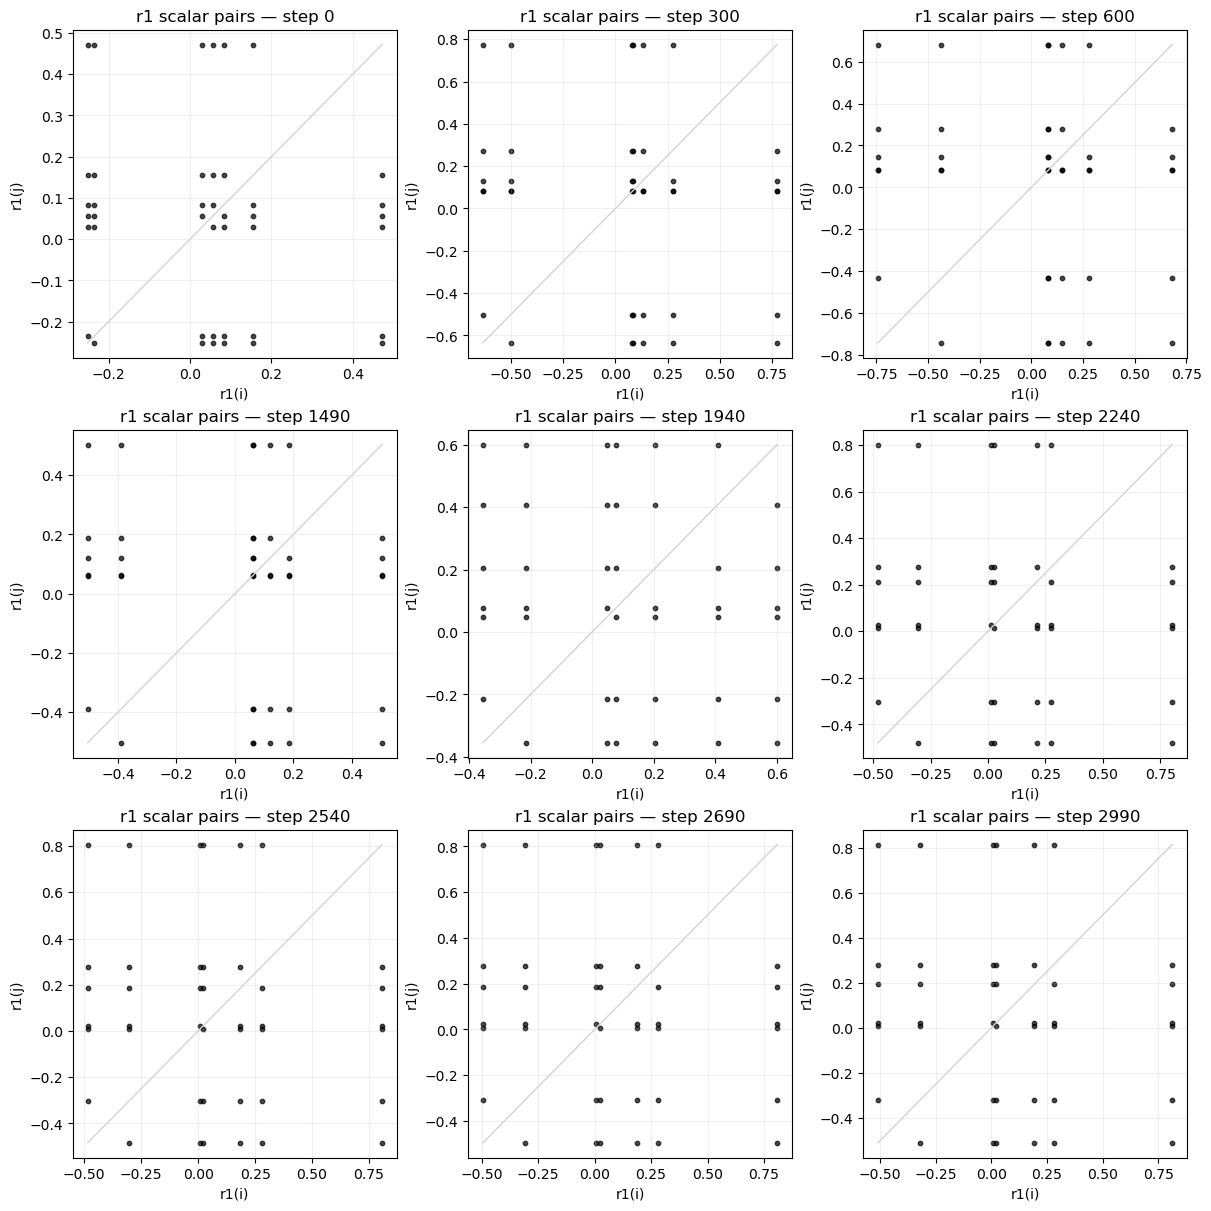

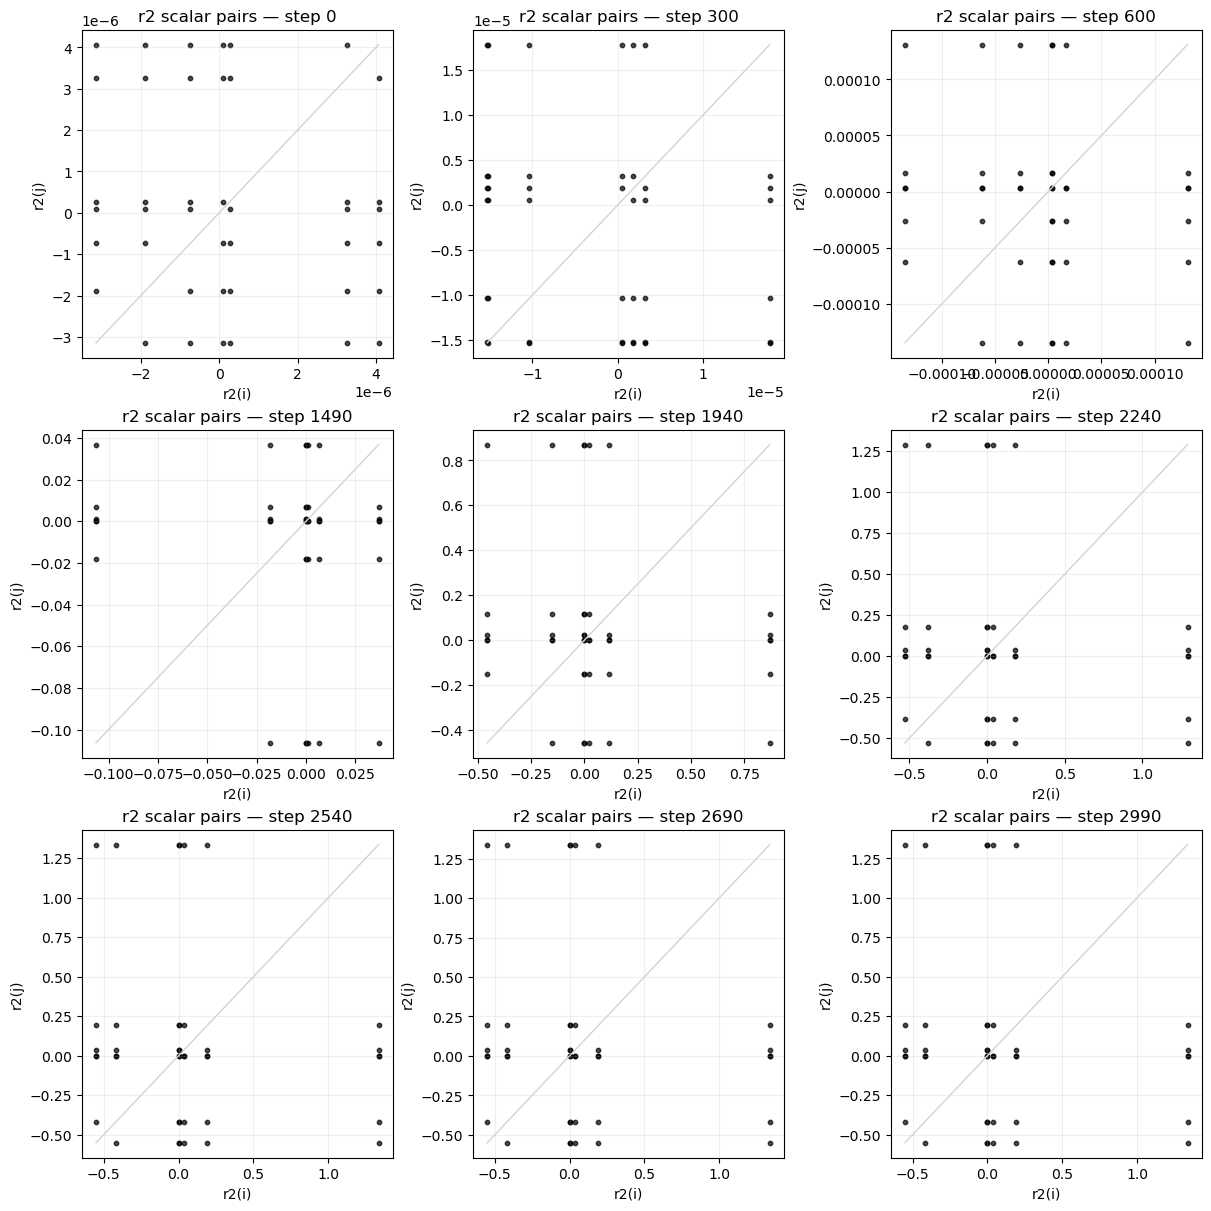

In [ ]:
# Plot r1 and r2 scalar pair scatters (x=r(i), y=r(j)) across nine positions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_r_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression="gzip")
    seed_cols = [c for c in df.columns if c.startswith("seed_")]
    steps = np.array(sorted(df["time_step"].unique()))
    items_n = int(df["item"].max()) + 1
    units = int(df["unit"].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, len(steps), items_n, units), dtype=float)
    step_to_idx = {s: k for k, s in enumerate(steps)}
    for _, row in df.iterrows():
        t = int(row["time_step"]); i = int(row["item"]); u = int(row["unit"])
        k = step_to_idx[t]
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, k, i, u] = row[sc]
    return arr, steps  # (seeds, saved_steps, items, units), saved step values

# Paths (adjust if needed)
r1_csv_gz = r"conjunctive_lazy_rich_r1s.csv.gz"
r2_csv_gz = r"conjunctive_lazy_rich_r2s.csv.gz"

R1_all, steps_r1 = load_r_from_csv_gz(r1_csv_gz)
R2_all, steps_r2 = load_r_from_csv_gz(r2_csv_gz)
R1 = R1_all.mean(axis=0)  # (K, items, units)
R2 = R2_all.mean(axis=0)  # (K, items, units)

# If units>1, take unit 0 (r1/r2 should be scalar)
R1_scalar = R1[..., 0]
R2_scalar = R2[..., 0]
items_n = R1_scalar.shape[1]

positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]
def nearest_index(saved_steps, target_step):
    idx = int(np.argmin(np.abs(saved_steps - target_step)))
    return idx, int(saved_steps[idx])

# r1 pair scatter grids
max_step_r1 = int(steps_r1.max())
fig1, axs1 = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig1.patch.set_facecolor('white')
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    tgt = int(p * max_step_r1)
    k, actual = nearest_index(steps_r1, tgt)
    rvals = R1_scalar[k]  # (items,)
    xs, ys = [], []
    for i in range(items_n):
        for j in range(items_n):
            if i == j: 
                continue
            xs.append(rvals[i]); ys.append(rvals[j])
    ax = axs1[r, c]
    ax.scatter(xs, ys, s=10, color='k', alpha=0.7)
    ax.plot([min(xs+ys), max(xs+ys)], [min(xs+ys), max(xs+ys)], color='lightgray', lw=1)  # y=x
    ax.set_title(f"r1 scalar pairs — step {actual}")
    ax.set_xlabel("r1(i)"); ax.set_ylabel("r1(j)")
    ax.grid(True, alpha=0.2)
plt.show()

# r2 pair scatter grids
max_step_r2 = int(steps_r2.max())
fig2, axs2 = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig2.patch.set_facecolor('white')
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    tgt = int(p * max_step_r2)
    k, actual = nearest_index(steps_r2, tgt)
    rvals = R2_scalar[k]  # (items,)
    xs, ys = [], []
    for i in range(items_n):
        for j in range(items_n):
            if i == j:
                continue
            xs.append(rvals[i]); ys.append(rvals[j])
    ax = axs2[r, c]
    ax.scatter(xs, ys, s=10, color='k', alpha=0.7)
    ax.plot([min(xs+ys), max(xs+ys)], [min(xs+ys), max(xs+ys)], color='lightgray', lw=1)
    ax.set_title(f"r2 scalar pairs — step {actual}")
    ax.set_xlabel("r2(i)"); ax.set_ylabel("r2(j)")
    ax.grid(True, alpha=0.2)
plt.show()

In [ ]:
import numpy as np
import pandas as pd

def load_r_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression="gzip")
    seed_cols = [c for c in df.columns if c.startswith("seed_")]
    steps = np.array(sorted(df["time_step"].unique()))
    items_n = int(df["item"].max()) + 1
    units = int(df["unit"].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, len(steps), items_n, units), dtype=float)
    step_to_idx = {s: k for k, s in enumerate(steps)}
    for _, row in df.iterrows():
        t = int(row["time_step"]); i = int(row["item"]); u = int(row["unit"])
        k = step_to_idx[t]
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, k, i, u] = row[sc]
    return arr, steps  # (seeds, K, items, units), saved time steps

def nearest_index(saved_steps, target_step):
    idx = int(np.argmin(np.abs(saved_steps - target_step)))
    return idx, int(saved_steps[idx])

def print_pair_grid(rvals_1d, name="r1", decimals=3):
    items_n = rvals_1d.shape[0]
    fmt = f"{{:.{decimals}f}}"
    # Build string grid of (r(i), r(j))
    grid = [["" for _ in range(items_n+1)] for _ in range(items_n+1)]
    grid[0][0] = f"{name}(i),{name}(j)"
    for j in range(items_n):
        grid[0][j+1] = str(j)
    for i in range(items_n):
        grid[i+1][0] = str(i)
        for j in range(items_n):
            grid[i+1][j+1] = f"({fmt.format(rvals_1d[i])},{fmt.format(rvals_1d[j])})" if i != j else "-"
    # Compute column widths
    col_w = [max(len(row[c]) for row in grid) for c in range(items_n+1)]
    # Print
    for row in grid:
        print("  ".join(cell.ljust(col_w[c]) for c, cell in enumerate(row)))

# Paths to your CSV.GZ (change to relative if needed)
r1_csv_gz = "conjunctive_lazy_rich_r1s.csv.gz"
r2_csv_gz = "conjunctive_lazy_rich_r2s.csv.gz"

# Load and average across seeds; take unit 0 since r1/r2 are scalars
R1_all, steps_r1 = load_r_from_csv_gz(r1_csv_gz)
R2_all, steps_r2 = load_r_from_csv_gz(r2_csv_gz)
R1 = R1_all.mean(axis=0)[..., 0]  # (K, items)
R2 = R2_all.mean(axis=0)[..., 0]  # (K, items)

# Choose a target step (change this as needed)
target_step = 300

k1, actual1 = nearest_index(steps_r1, target_step)
k2, actual2 = nearest_index(steps_r2, target_step)

print(f"\nGrid of r1 pair values at step {actual1}:")
print_pair_grid(R1[k1], name="r1")

print(f"\nGrid of r2 pair values at step {actual2}:")
print_pair_grid(R2[k2], name="r2")


Grid of r1 pair values at step 300:
r1(i),r1(j)  0                1               2               3                4               5               6             
0            -                (-0.502,0.274)  (-0.502,0.775)  (-0.502,-0.635)  (-0.502,0.131)  (-0.502,0.083)  (-0.502,0.081)
1            (0.274,-0.502)   -               (0.274,0.775)   (0.274,-0.635)   (0.274,0.131)   (0.274,0.083)   (0.274,0.081) 
2            (0.775,-0.502)   (0.775,0.274)   -               (0.775,-0.635)   (0.775,0.131)   (0.775,0.083)   (0.775,0.081) 
3            (-0.635,-0.502)  (-0.635,0.274)  (-0.635,0.775)  -                (-0.635,0.131)  (-0.635,0.083)  (-0.635,0.081)
4            (0.131,-0.502)   (0.131,0.274)   (0.131,0.775)   (0.131,-0.635)   -               (0.131,0.083)   (0.131,0.081) 
5            (0.083,-0.502)   (0.083,0.274)   (0.083,0.775)   (0.083,-0.635)   (0.083,0.131)   -               (0.083,0.081) 
6            (0.081,-0.502)   (0.081,0.274)   (0.081,0.775)   (0.081,-0.635)   (0

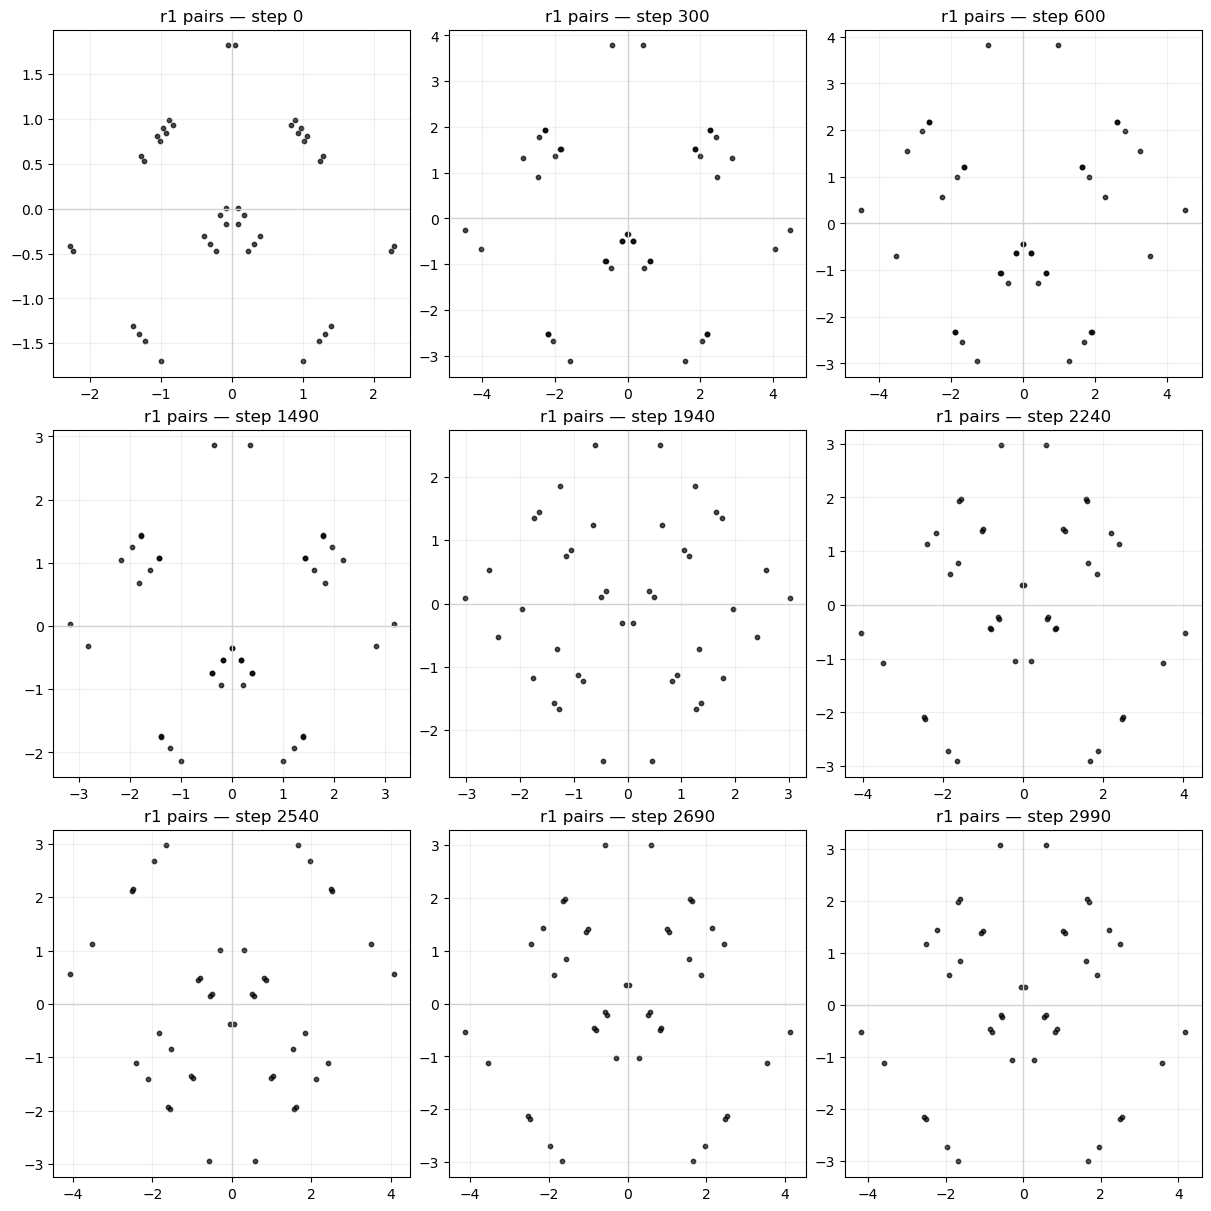

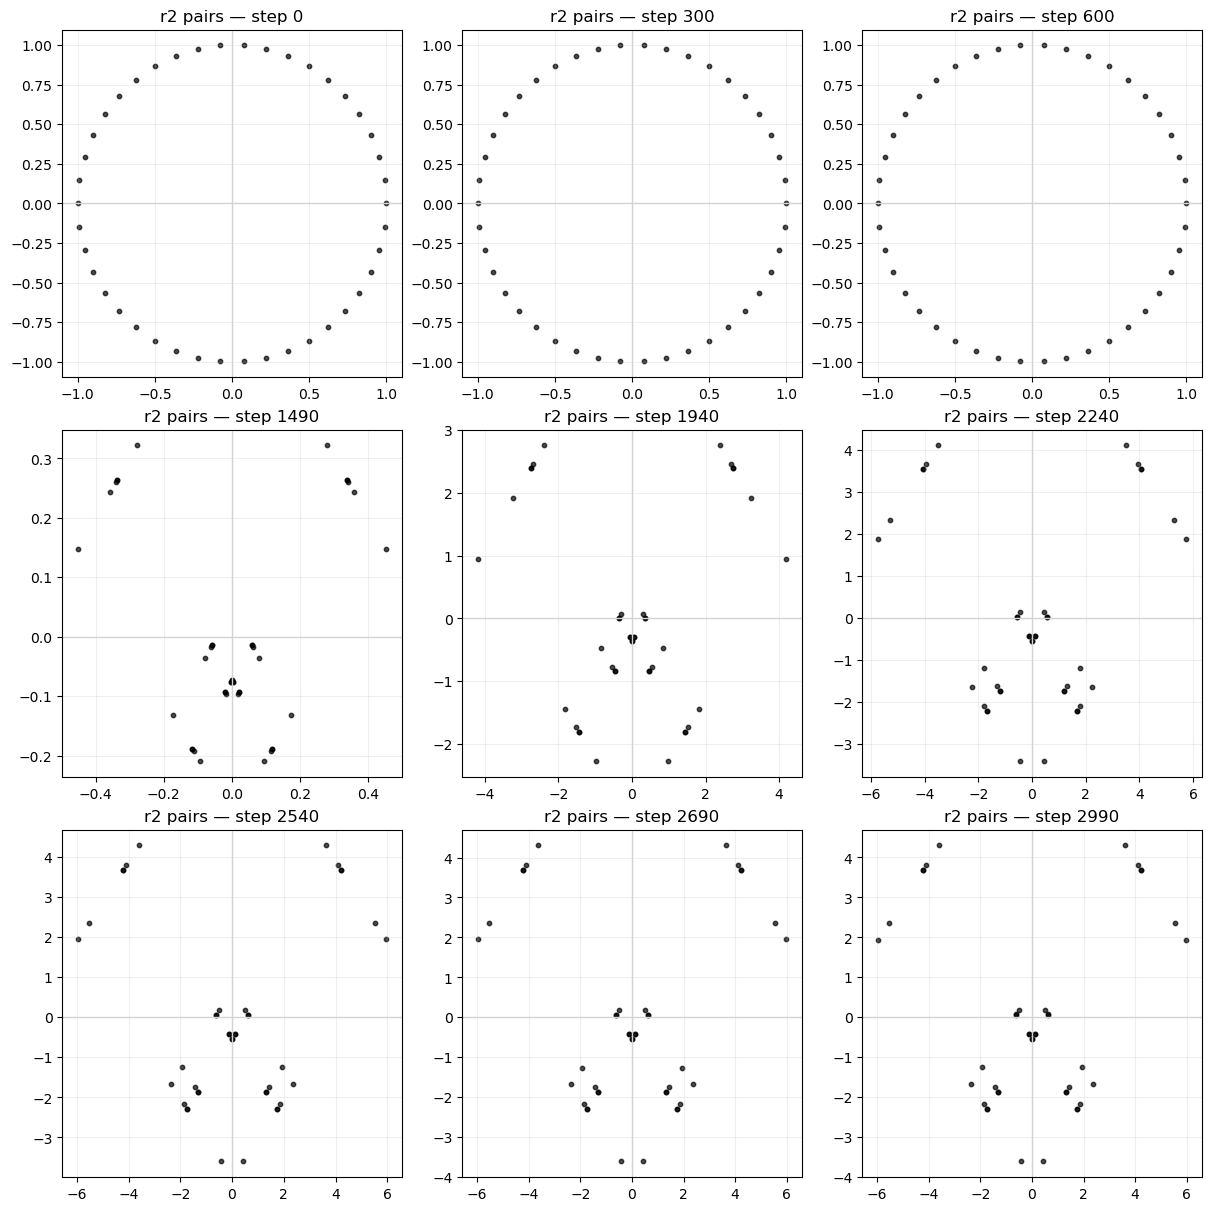

In [ ]:
# Load r1s/r2s from CSV.GZ (every 10 steps) and plot pair PCA embeddings across nine positions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def load_r_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression="gzip")
    seed_cols = [c for c in df.columns if c.startswith("seed_")]
    steps = np.array(sorted(df["time_step"].unique()))
    items_n = int(df["item"].max()) + 1
    units = int(df["unit"].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, len(steps), items_n, units), dtype=float)
    step_to_idx = {s: k for k, s in enumerate(steps)}
    for _, row in df.iterrows():
        t = int(row["time_step"]); i = int(row["item"]); u = int(row["unit"])
        k = step_to_idx[t]
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, k, i, u] = row[sc]
    return arr, steps  # (seeds, saved_steps, items, units), saved step values

def build_pair_vectors(X_items):
    # Ordered pairs (i != j) with concatenated readout vectors
    n = X_items.shape[0]
    vecs, labels = [], []
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            vecs.append(np.concatenate([X_items[i], X_items[j]], axis=0))
            labels.append(f"({i},{j})")
    V = np.asarray(vecs, dtype=float)
    V = np.nan_to_num(V, nan=0.0, posinf=0.0, neginf=0.0)
    V -= V.mean(axis=0, keepdims=True)
    return V, labels

def pca2(V, seed=0):
    if np.allclose(V.var(), 0.0):
        theta = np.linspace(0, 2*np.pi, V.shape[0], endpoint=False)
        return np.stack([np.cos(theta), np.sin(theta)], axis=1)
    k = min(2, V.shape[1])
    return PCA(n_components=k, random_state=seed).fit_transform(V)

# Paths (adjust if saving elsewhere)
r1_csv_gz = r"conjunctive_lazy_rich_r1s.csv.gz"
r2_csv_gz = r"conjunctive_lazy_rich_r2s.csv.gz"

R1_all, steps_r1 = load_r_from_csv_gz(r1_csv_gz)  # (seeds, K, items, readouts)
R2_all, steps_r2 = load_r_from_csv_gz(r2_csv_gz)  # (seeds, K, items, readouts)
R1 = R1_all.mean(axis=0)  # (K, items, readouts)
R2 = R2_all.mean(axis=0)  # (K, items, readouts)
items_n = R1.shape[1]
mds_seed = 0

# Positions as fractions of max step; map to nearest saved step
positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]
max_step_r1 = int(steps_r1.max())
def nearest_index(saved_steps, target_step):
    idx = np.argmin(np.abs(saved_steps - target_step))
    return int(idx), int(saved_steps[idx])

# Plot r1 pairs
fig1, axs1 = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig1.patch.set_facecolor('white')
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    tgt = int(p * max_step_r1)
    k, actual = nearest_index(steps_r1, tgt)
    V1, L1 = build_pair_vectors(R1[k])
    coords1 = pca2(V1, seed=mds_seed)
    ax = axs1[r, c]
    ax.scatter(coords1[:, 0], coords1[:, 1], s=10, color='k', alpha=0.7)
    ax.set_title(f"r1 pairs — step {actual}")
    ax.axhline(0, color='lightgray', lw=1); ax.axvline(0, color='lightgray', lw=1)
    ax.grid(True, alpha=0.2)
plt.show()

# Plot r2 pairs
max_step_r2 = int(steps_r2.max())
fig2, axs2 = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
fig2.patch.set_facecolor('white')
for idx, p in enumerate(positions):
    r, c = divmod(idx, 3)
    tgt = int(p * max_step_r2)
    k, actual = nearest_index(steps_r2, tgt)
    V2, L2 = build_pair_vectors(R2[k])
    coords2 = pca2(V2, seed=mds_seed)
    ax = axs2[r, c]
    ax.scatter(coords2[:, 0], coords2[:, 1], s=10, color='k', alpha=0.7)
    ax.set_title(f"r2 pairs — step {actual}")
    ax.axhline(0, color='lightgray', lw=1); ax.axvline(0, color='lightgray', lw=1)
    ax.grid(True, alpha=0.2)
plt.show()

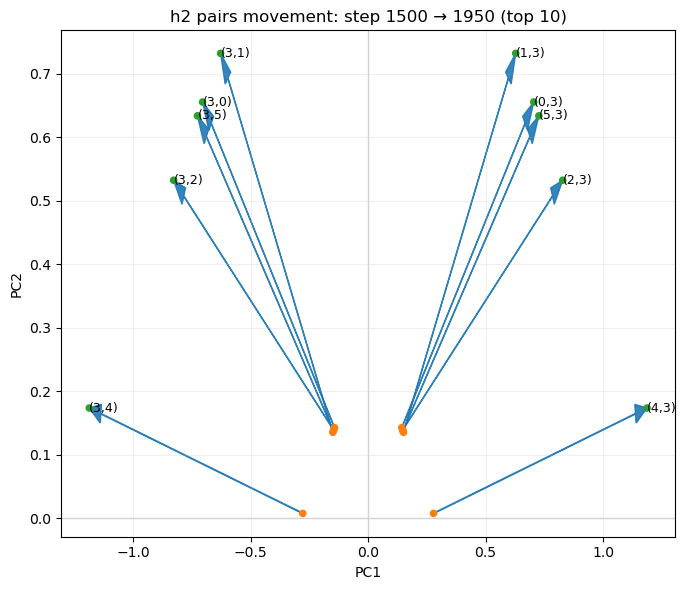

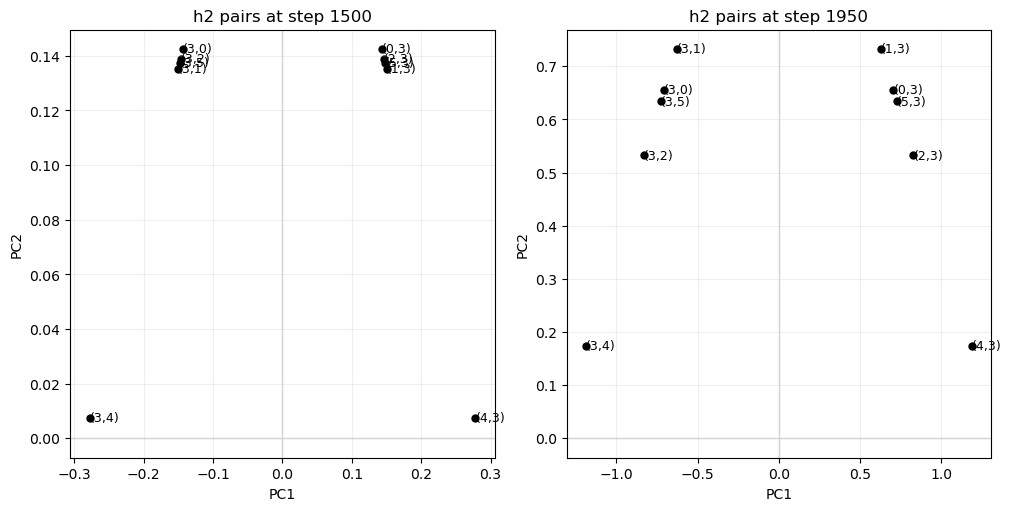

In [ ]:
# h2 pair changes between steps 1500 and 1950: show top-5 moving pairs with arrows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Prepare h2 data (mean across seeds)
H2_avg = all_h2s
time_steps, items_n_inferred, h2_size = H2_avg.shape

# Steps of interest (clip to available range)
step_a = min(1500, time_steps - 1)
step_b = min(1950, time_steps - 1)

# Build pair feature vectors by concatenation for all ordered pairs i != j
def build_pairs(X_items):
    vecs, labels, pairs = [], [], []
    for i in range(items_n_inferred):
        for j in range(items_n_inferred):
            if i == j:
                continue
            v = np.concatenate([X_items[i], X_items[j]], axis=0)
            vecs.append(v)
            labels.append(f"({i},{j})")
            pairs.append((i, j))
    V = np.asarray(vecs)
    V = V - V.mean(axis=0, keepdims=True)
    return V, labels, pairs

Xa, la, pa = build_pairs(H2_avg[step_a])
Xb, lb, pb = build_pairs(H2_avg[step_b])

# Fit PCA on the union to get a common 2D space
X_union = np.vstack([Xa, Xb])
if np.allclose(X_union.var(), 0.0):
    theta = np.linspace(0, 2*np.pi, Xa.shape[0], endpoint=False)
    coords_a = np.stack([np.cos(theta), np.sin(theta)], axis=1)
    coords_b = coords_a.copy()
else:
    pca = PCA(n_components=2, random_state=mds_seed if 'mds_seed' in globals() else 0)
    coords_union = pca.fit_transform(X_union)
    coords_a = coords_union[:Xa.shape[0]]
    coords_b = coords_union[Xa.shape[0]:]

# Compute displacements per pair (match by index; la and lb have same ordering)
deltas = coords_b - coords_a
move_norm = np.linalg.norm(deltas, axis=1)

# Select top-5 moving pairs
top_k = 10
top_idx = np.argsort(-move_norm)[:top_k]

# Plot arrows for the top pairs
plt.figure(figsize=(7, 6))
ax = plt.gca()
for idx in top_idx:
    x0, y0 = coords_a[idx]
    dx, dy = deltas[idx]
    x1, y1 = x0 + dx, y0 + dy
    ax.arrow(x0, y0, dx, dy, head_width=0.03, head_length=0.05, length_includes_head=True,
                fc='C0', ec='C0', alpha=0.9)
    ax.scatter([x0, x1], [y0, y1], s=20, color=['C1','C2'], zorder=3)
    ax.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
ax.set_title(f"h2 pairs movement: step {step_a} → {step_b} (top {top_k})")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.axhline(0, color='lightgray', linewidth=1)
ax.axvline(0, color='lightgray', linewidth=1)
ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

# Also provide separate scatter plots for the same 5 pairs at each step (optional clarity)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10., 5.), constrained_layout=True)
ax1.set_title(f"h2 pairs at step {step_a}")
ax2.set_title(f"h2 pairs at step {step_b}")
for idx in top_idx:
    x0, y0 = coords_a[idx]
    x1, y1 = coords_b[idx]
    ax1.scatter(x0, y0, s=25, color='k')
    ax1.text(x0, y0, la[idx], fontsize=9, ha='left', va='center')
    ax2.scatter(x1, y1, s=25, color='k')
    ax2.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
for axx in (ax1, ax2):
    axx.axhline(0, color='lightgray', linewidth=1)
    axx.axvline(0, color='lightgray', linewidth=1)
    axx.grid(True, alpha=0.2)
    axx.set_xlabel("PC1")
    axx.set_ylabel("PC2")
plt.show()


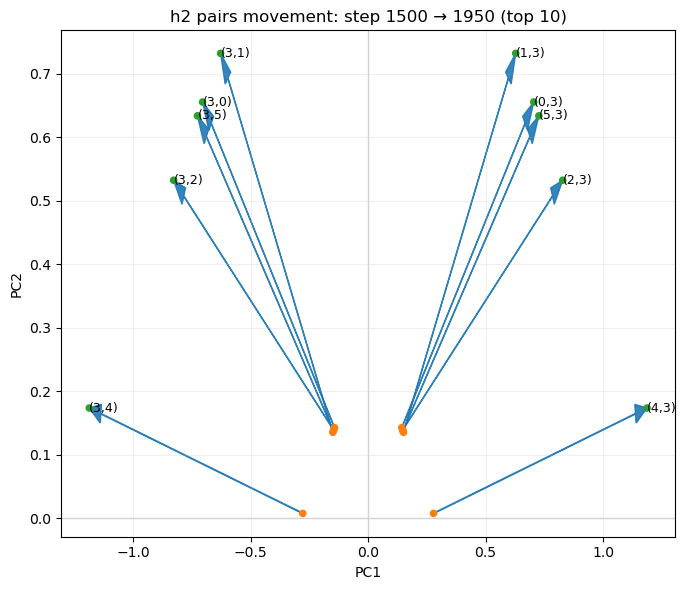

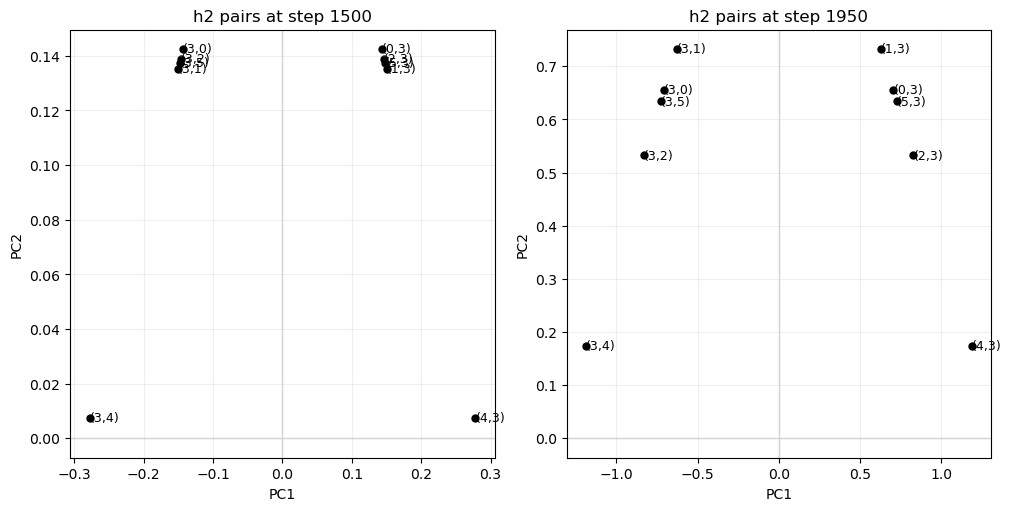

In [ ]:
# h2 pair changes between steps 1500 and 1950: show top-5 moving pairs with arrows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Prepare h2 data (mean across seeds)
if isinstance(results, tuple):
    results = results[1]
train_dict = results.get("train", {}) if isinstance(results, dict) else {}
if "h2s" not in train_dict or train_dict["h2s"] is None:
    print("No h2s found in results['train'].")
else:
    H2 = train_dict["h2s"]  # (seeds_n, time_steps, items_n, h2_size)
    H2_avg = np.nan_to_num(H2.mean(axis=0), nan=0.0, posinf=0.0, neginf=0.0)  # (time_steps, items_n, h2_size)
    time_steps, items_n_inferred, h2_size = H2_avg.shape

    # Steps of interest (clip to available range)
    step_a = min(1500, time_steps - 1)
    step_b = min(1950, time_steps - 1)

    # Build pair feature vectors by concatenation for all ordered pairs i != j
    def build_pairs(X_items):
        vecs, labels, pairs = [], [], []
        for i in range(items_n_inferred):
            for j in range(items_n_inferred):
                if i == j:
                    continue
                v = np.concatenate([X_items[i], X_items[j]], axis=0)
                vecs.append(v)
                labels.append(f"({i},{j})")
                pairs.append((i, j))
        V = np.asarray(vecs)
        V = V - V.mean(axis=0, keepdims=True)
        return V, labels, pairs

    Xa, la, pa = build_pairs(H2_avg[step_a])
    Xb, lb, pb = build_pairs(H2_avg[step_b])

    # Fit PCA on the union to get a common 2D space
    X_union = np.vstack([Xa, Xb])
    if np.allclose(X_union.var(), 0.0):
        theta = np.linspace(0, 2*np.pi, Xa.shape[0], endpoint=False)
        coords_a = np.stack([np.cos(theta), np.sin(theta)], axis=1)
        coords_b = coords_a.copy()
    else:
        pca = PCA(n_components=2, random_state=mds_seed if 'mds_seed' in globals() else 0)
        coords_union = pca.fit_transform(X_union)
        coords_a = coords_union[:Xa.shape[0]]
        coords_b = coords_union[Xa.shape[0]:]

    # Compute displacements per pair (match by index; la and lb have same ordering)
    deltas = coords_b - coords_a
    move_norm = np.linalg.norm(deltas, axis=1)

    # Select top-5 moving pairs
    top_k = 10
    top_idx = np.argsort(-move_norm)[:top_k]

    # Plot arrows for the top pairs
    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        dx, dy = deltas[idx]
        x1, y1 = x0 + dx, y0 + dy
        ax.arrow(x0, y0, dx, dy, head_width=0.03, head_length=0.05, length_includes_head=True,
                 fc='C0', ec='C0', alpha=0.9)
        ax.scatter([x0, x1], [y0, y1], s=20, color=['C1','C2'], zorder=3)
        ax.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    ax.set_title(f"h2 pairs movement: step {step_a} → {step_b} (top {top_k})")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.axhline(0, color='lightgray', linewidth=1)
    ax.axvline(0, color='lightgray', linewidth=1)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    # Also provide separate scatter plots for the same 5 pairs at each step (optional clarity)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10., 5.), constrained_layout=True)
    ax1.set_title(f"h2 pairs at step {step_a}")
    ax2.set_title(f"h2 pairs at step {step_b}")
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        x1, y1 = coords_b[idx]
        ax1.scatter(x0, y0, s=25, color='k')
        ax1.text(x0, y0, la[idx], fontsize=9, ha='left', va='center')
        ax2.scatter(x1, y1, s=25, color='k')
        ax2.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    for axx in (ax1, ax2):
        axx.axhline(0, color='lightgray', linewidth=1)
        axx.axvline(0, color='lightgray', linewidth=1)
        axx.grid(True, alpha=0.2)
        axx.set_xlabel("PC1")
        axx.set_ylabel("PC2")
    plt.show()


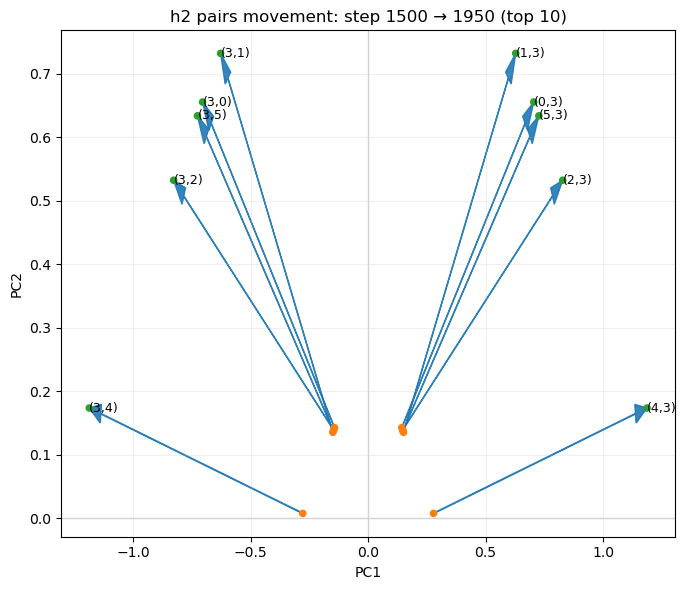

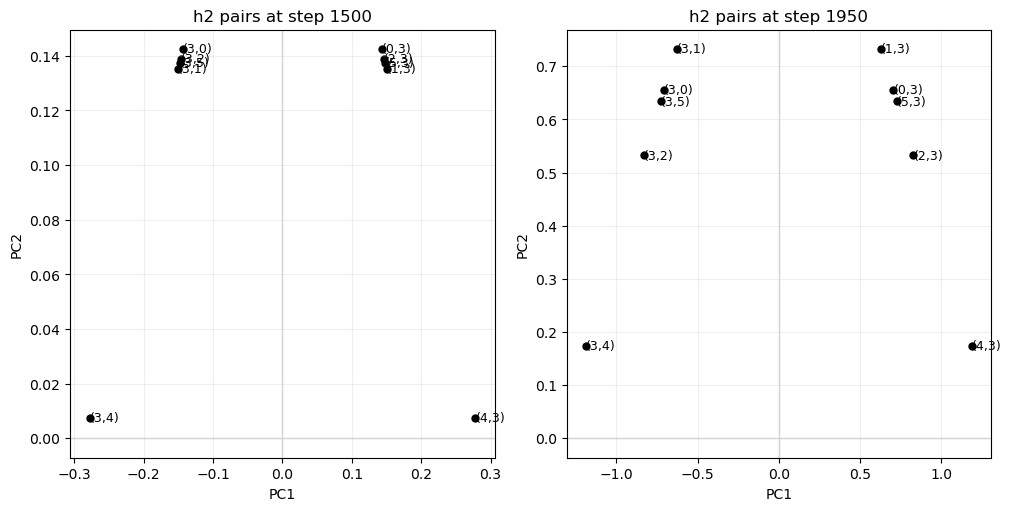

In [ ]:
# h2 pair changes between steps 1500 and 1950: show top-5 moving pairs with arrows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Prepare h2 data (mean across seeds)
if isinstance(results, tuple):
    results = results[1]
train_dict = results.get("train", {}) if isinstance(results, dict) else {}
if "h2s" not in train_dict or train_dict["h2s"] is None:
    print("No h2s found in results['train'].")
else:
    H2 = train_dict["h2s"]  # (seeds_n, time_steps, items_n, h2_size)
    H2_avg = np.nan_to_num(H2.mean(axis=0), nan=0.0, posinf=0.0, neginf=0.0)  # (time_steps, items_n, h2_size)
    time_steps, items_n_inferred, h2_size = H2_avg.shape

    # Steps of interest (clip to available range)
    step_a = min(1500, time_steps - 1)
    step_b = min(1950, time_steps - 1)

    # Build pair feature vectors by concatenation for all ordered pairs i != j
    def build_pairs(X_items):
        vecs, labels, pairs = [], [], []
        for i in range(items_n_inferred):
            for j in range(items_n_inferred):
                if i == j:
                    continue
                v = np.concatenate([X_items[i], X_items[j]], axis=0)
                vecs.append(v)
                labels.append(f"({i},{j})")
                pairs.append((i, j))
        V = np.asarray(vecs)
        V = V - V.mean(axis=0, keepdims=True)
        return V, labels, pairs

    Xa, la, pa = build_pairs(H2_avg[step_a])
    Xb, lb, pb = build_pairs(H2_avg[step_b])

    # Fit PCA on the union to get a common 2D space
    X_union = np.vstack([Xa, Xb])
    if np.allclose(X_union.var(), 0.0):
        theta = np.linspace(0, 2*np.pi, Xa.shape[0], endpoint=False)
        coords_a = np.stack([np.cos(theta), np.sin(theta)], axis=1)
        coords_b = coords_a.copy()
    else:
        pca = PCA(n_components=2, random_state=mds_seed if 'mds_seed' in globals() else 0)
        coords_union = pca.fit_transform(X_union)
        coords_a = coords_union[:Xa.shape[0]]
        coords_b = coords_union[Xa.shape[0]:]

    # Compute displacements per pair (match by index; la and lb have same ordering)
    deltas = coords_b - coords_a
    move_norm = np.linalg.norm(deltas, axis=1)

    # Select top-5 moving pairs
    top_k = 10
    top_idx = np.argsort(-move_norm)[:top_k]

    # Plot arrows for the top pairs
    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        dx, dy = deltas[idx]
        x1, y1 = x0 + dx, y0 + dy
        ax.arrow(x0, y0, dx, dy, head_width=0.03, head_length=0.05, length_includes_head=True,
                 fc='C0', ec='C0', alpha=0.9)
        ax.scatter([x0, x1], [y0, y1], s=20, color=['C1','C2'], zorder=3)
        ax.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    ax.set_title(f"h2 pairs movement: step {step_a} → {step_b} (top {top_k})")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.axhline(0, color='lightgray', linewidth=1)
    ax.axvline(0, color='lightgray', linewidth=1)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    # Also provide separate scatter plots for the same 5 pairs at each step (optional clarity)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10., 5.), constrained_layout=True)
    ax1.set_title(f"h2 pairs at step {step_a}")
    ax2.set_title(f"h2 pairs at step {step_b}")
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        x1, y1 = coords_b[idx]
        ax1.scatter(x0, y0, s=25, color='k')
        ax1.text(x0, y0, la[idx], fontsize=9, ha='left', va='center')
        ax2.scatter(x1, y1, s=25, color='k')
        ax2.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    for axx in (ax1, ax2):
        axx.axhline(0, color='lightgray', linewidth=1)
        axx.axvline(0, color='lightgray', linewidth=1)
        axx.grid(True, alpha=0.2)
        axx.set_xlabel("PC1")
        axx.set_ylabel("PC2")
    plt.show()


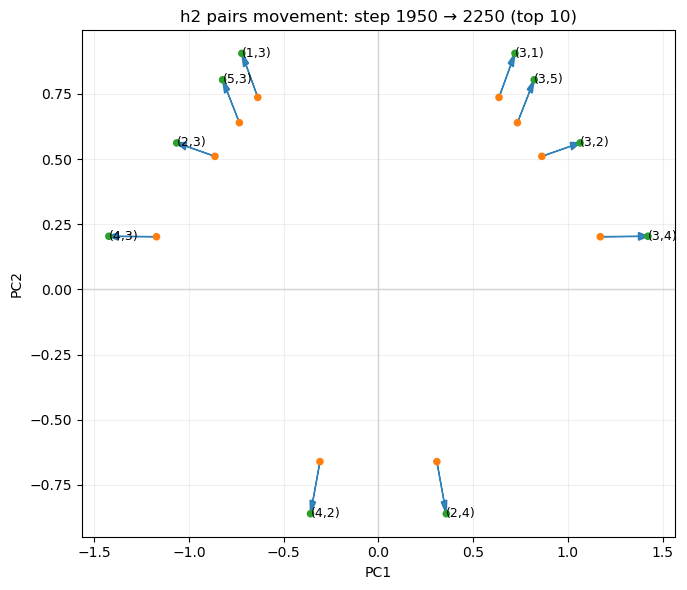

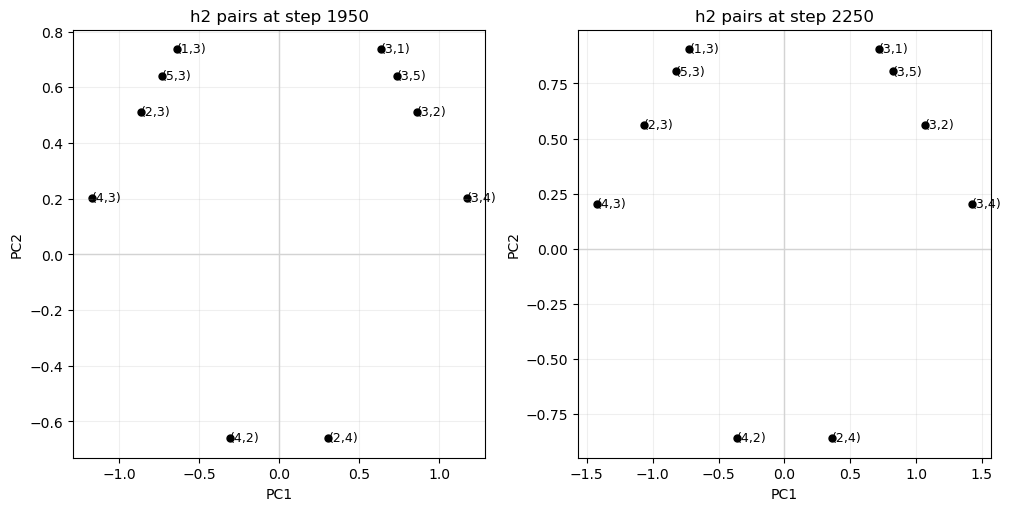

In [ ]:
# h2 pair changes between steps 1500 and 1950: show top-5 moving pairs with arrows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Prepare h2 data (mean across seeds)
if isinstance(results, tuple):
    results = results[1]
train_dict = results.get("train", {}) if isinstance(results, dict) else {}
if "h2s" not in train_dict or train_dict["h2s"] is None:
    print("No h2s found in results['train'].")
else:
    H2 = train_dict["h2s"]  # (seeds_n, time_steps, items_n, h2_size)
    H2_avg = np.nan_to_num(H2.mean(axis=0), nan=0.0, posinf=0.0, neginf=0.0)  # (time_steps, items_n, h2_size)
    time_steps, items_n_inferred, h2_size = H2_avg.shape

    # Steps of interest (clip to available range)
    step_a = min(1950, time_steps - 1)
    step_b = min(2250, time_steps - 1)

    # Build pair feature vectors by concatenation for all ordered pairs i != j
    def build_pairs(X_items):
        vecs, labels, pairs = [], [], []
        for i in range(items_n_inferred):
            for j in range(items_n_inferred):
                if i == j:
                    continue
                v = np.concatenate([X_items[i], X_items[j]], axis=0)
                vecs.append(v)
                labels.append(f"({i},{j})")
                pairs.append((i, j))
        V = np.asarray(vecs)
        V = V - V.mean(axis=0, keepdims=True)
        return V, labels, pairs

    Xa, la, pa = build_pairs(H2_avg[step_a])
    Xb, lb, pb = build_pairs(H2_avg[step_b])

    # Fit PCA on the union to get a common 2D space
    X_union = np.vstack([Xa, Xb])
    if np.allclose(X_union.var(), 0.0):
        theta = np.linspace(0, 2*np.pi, Xa.shape[0], endpoint=False)
        coords_a = np.stack([np.cos(theta), np.sin(theta)], axis=1)
        coords_b = coords_a.copy()
    else:
        pca = PCA(n_components=2, random_state=mds_seed if 'mds_seed' in globals() else 0)
        coords_union = pca.fit_transform(X_union)
        coords_a = coords_union[:Xa.shape[0]]
        coords_b = coords_union[Xa.shape[0]:]

    # Compute displacements per pair (match by index; la and lb have same ordering)
    deltas = coords_b - coords_a
    move_norm = np.linalg.norm(deltas, axis=1)

    # Select top-5 moving pairs
    top_k = 10
    top_idx = np.argsort(-move_norm)[:top_k]

    # Plot arrows for the top pairs
    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        dx, dy = deltas[idx]
        x1, y1 = x0 + dx, y0 + dy
        ax.arrow(x0, y0, dx, dy, head_width=0.03, head_length=0.05, length_includes_head=True,
                 fc='C0', ec='C0', alpha=0.9)
        ax.scatter([x0, x1], [y0, y1], s=20, color=['C1','C2'], zorder=3)
        ax.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    ax.set_title(f"h2 pairs movement: step {step_a} → {step_b} (top {top_k})")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.axhline(0, color='lightgray', linewidth=1)
    ax.axvline(0, color='lightgray', linewidth=1)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    # Also provide separate scatter plots for the same 5 pairs at each step (optional clarity)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10., 5.), constrained_layout=True)
    ax1.set_title(f"h2 pairs at step {step_a}")
    ax2.set_title(f"h2 pairs at step {step_b}")
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        x1, y1 = coords_b[idx]
        ax1.scatter(x0, y0, s=25, color='k')
        ax1.text(x0, y0, la[idx], fontsize=9, ha='left', va='center')
        ax2.scatter(x1, y1, s=25, color='k')
        ax2.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    for axx in (ax1, ax2):
        axx.axhline(0, color='lightgray', linewidth=1)
        axx.axvline(0, color='lightgray', linewidth=1)
        axx.grid(True, alpha=0.2)
        axx.set_xlabel("PC1")
        axx.set_ylabel("PC2")
    plt.show()


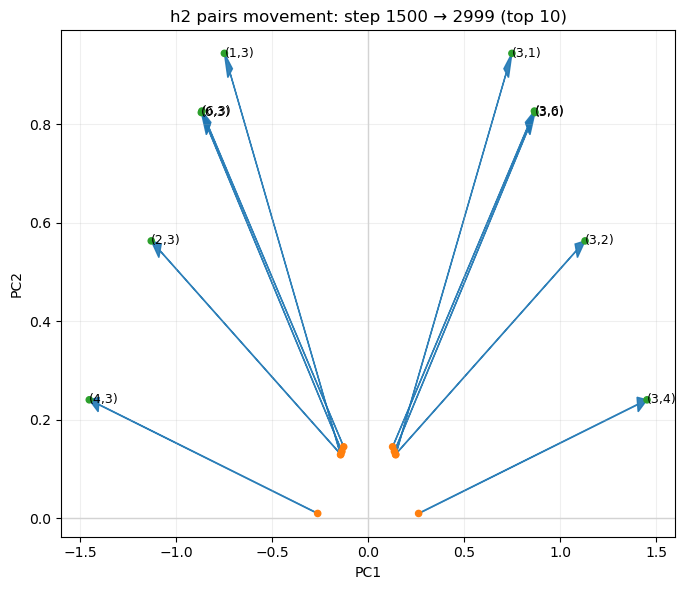

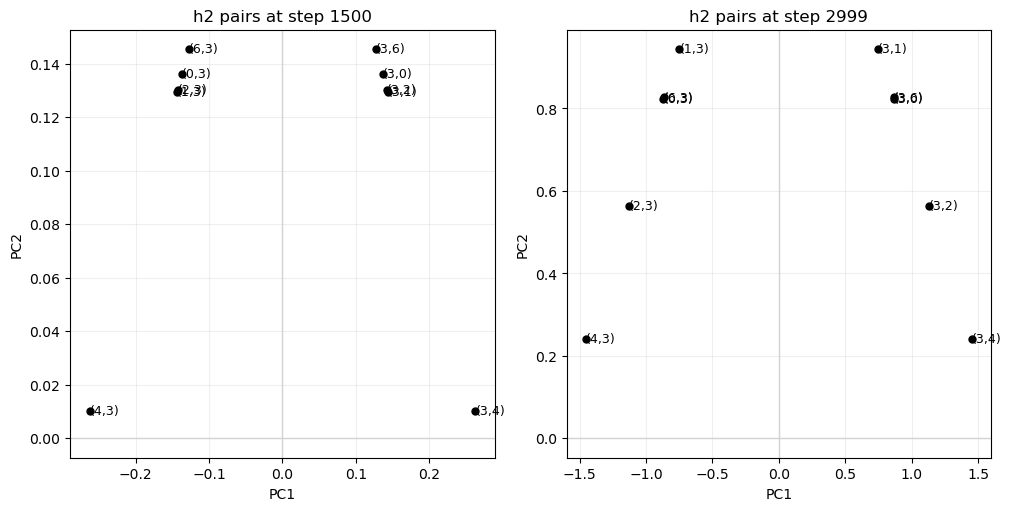

In [ ]:
# h2 pair changes between steps 1500 and 1950: show top-5 moving pairs with arrows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Prepare h2 data (mean across seeds)
if isinstance(results, tuple):
    results = results[1]
train_dict = results.get("train", {}) if isinstance(results, dict) else {}
if "h2s" not in train_dict or train_dict["h2s"] is None:
    print("No h2s found in results['train'].")
else:
    H2 = train_dict["h2s"]  # (seeds_n, time_steps, items_n, h2_size)
    H2_avg = np.nan_to_num(H2.mean(axis=0), nan=0.0, posinf=0.0, neginf=0.0)  # (time_steps, items_n, h2_size)
    time_steps, items_n_inferred, h2_size = H2_avg.shape

    # Steps of interest (clip to available range)
    step_a = min(1500, time_steps - 1)
    step_b = min(3000, time_steps - 1)

    # Build pair feature vectors by concatenation for all ordered pairs i != j
    def build_pairs(X_items):
        vecs, labels, pairs = [], [], []
        for i in range(items_n_inferred):
            for j in range(items_n_inferred):
                if i == j:
                    continue
                v = np.concatenate([X_items[i], X_items[j]], axis=0)
                vecs.append(v)
                labels.append(f"({i},{j})")
                pairs.append((i, j))
        V = np.asarray(vecs)
        V = V - V.mean(axis=0, keepdims=True)
        return V, labels, pairs

    Xa, la, pa = build_pairs(H2_avg[step_a])
    Xb, lb, pb = build_pairs(H2_avg[step_b])

    # Fit PCA on the union to get a common 2D space
    X_union = np.vstack([Xa, Xb])
    if np.allclose(X_union.var(), 0.0):
        theta = np.linspace(0, 2*np.pi, Xa.shape[0], endpoint=False)
        coords_a = np.stack([np.cos(theta), np.sin(theta)], axis=1)
        coords_b = coords_a.copy()
    else:
        pca = PCA(n_components=2, random_state=mds_seed if 'mds_seed' in globals() else 0)
        coords_union = pca.fit_transform(X_union)
        coords_a = coords_union[:Xa.shape[0]]
        coords_b = coords_union[Xa.shape[0]:]

    # Compute displacements per pair (match by index; la and lb have same ordering)
    deltas = coords_b - coords_a
    move_norm = np.linalg.norm(deltas, axis=1)

    # Select top-5 moving pairs
    top_k = 10
    top_idx = np.argsort(-move_norm)[:top_k]

    # Plot arrows for the top pairs
    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        dx, dy = deltas[idx]
        x1, y1 = x0 + dx, y0 + dy
        ax.arrow(x0, y0, dx, dy, head_width=0.03, head_length=0.05, length_includes_head=True,
                 fc='C0', ec='C0', alpha=0.9)
        ax.scatter([x0, x1], [y0, y1], s=20, color=['C1','C2'], zorder=3)
        ax.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    ax.set_title(f"h2 pairs movement: step {step_a} → {step_b} (top {top_k})")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.axhline(0, color='lightgray', linewidth=1)
    ax.axvline(0, color='lightgray', linewidth=1)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    # Also provide separate scatter plots for the same 5 pairs at each step (optional clarity)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10., 5.), constrained_layout=True)
    ax1.set_title(f"h2 pairs at step {step_a}")
    ax2.set_title(f"h2 pairs at step {step_b}")
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        x1, y1 = coords_b[idx]
        ax1.scatter(x0, y0, s=25, color='k')
        ax1.text(x0, y0, la[idx], fontsize=9, ha='left', va='center')
        ax2.scatter(x1, y1, s=25, color='k')
        ax2.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    for axx in (ax1, ax2):
        axx.axhline(0, color='lightgray', linewidth=1)
        axx.axvline(0, color='lightgray', linewidth=1)
        axx.grid(True, alpha=0.2)
        axx.set_xlabel("PC1")
        axx.set_ylabel("PC2")
    plt.show()


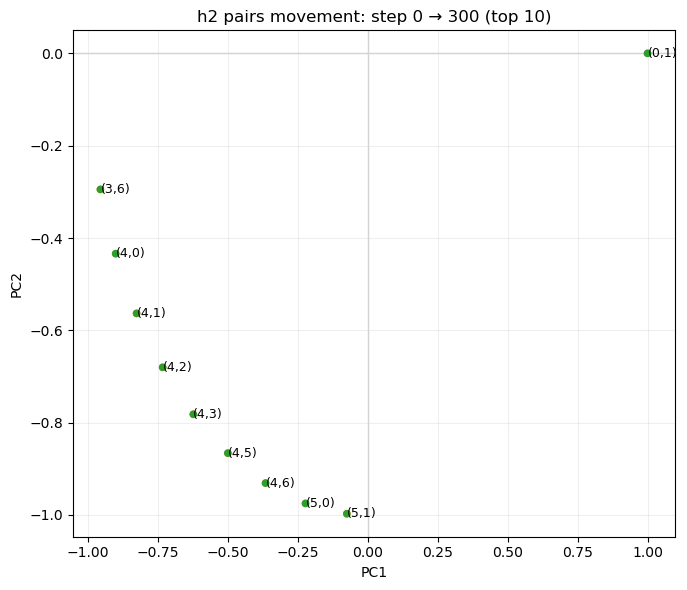

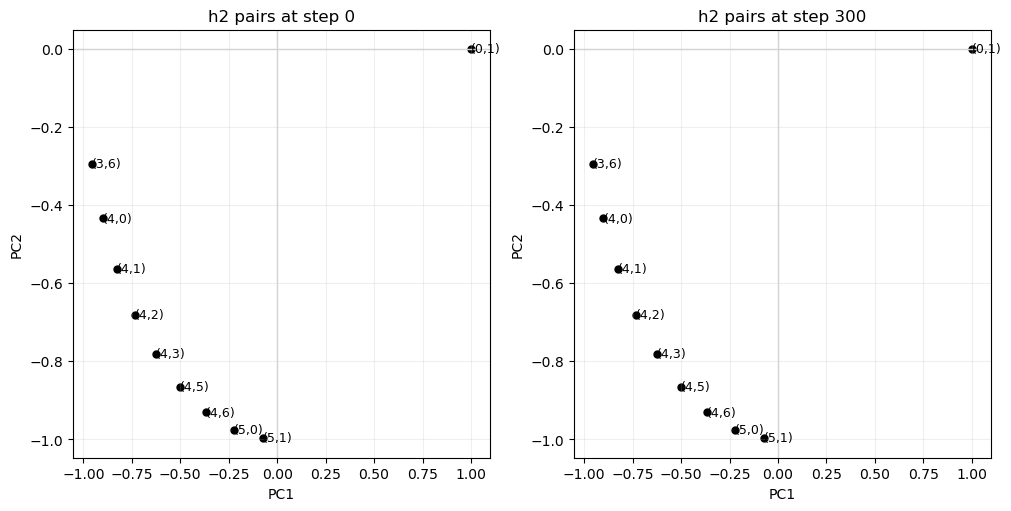

In [ ]:
# h2 pair changes between steps 1500 and 1950: show top-5 moving pairs with arrows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Prepare h2 data (mean across seeds)
if isinstance(results, tuple):
    results = results[1]
train_dict = results.get("train", {}) if isinstance(results, dict) else {}
if "h2s" not in train_dict or train_dict["h2s"] is None:
    print("No h2s found in results['train'].")
else:
    H2 = train_dict["h2s"]  # (seeds_n, time_steps, items_n, h2_size)
    H2_avg = np.nan_to_num(H2.mean(axis=0), nan=0.0, posinf=0.0, neginf=0.0)  # (time_steps, items_n, h2_size)
    time_steps, items_n_inferred, h2_size = H2_avg.shape

    # Steps of interest (clip to available range)
    step_a = min(0, time_steps - 1)
    step_b = min(300, time_steps - 1)

    # Build pair feature vectors by concatenation for all ordered pairs i != j
    def build_pairs(X_items):
        vecs, labels, pairs = [], [], []
        for i in range(items_n_inferred):
            for j in range(items_n_inferred):
                if i == j:
                    continue
                v = np.concatenate([X_items[i], X_items[j]], axis=0)
                vecs.append(v)
                labels.append(f"({i},{j})")
                pairs.append((i, j))
        V = np.asarray(vecs)
        V = V - V.mean(axis=0, keepdims=True)
        return V, labels, pairs

    Xa, la, pa = build_pairs(H2_avg[step_a])
    Xb, lb, pb = build_pairs(H2_avg[step_b])

    # Fit PCA on the union to get a common 2D space
    X_union = np.vstack([Xa, Xb])
    if np.allclose(X_union.var(), 0.0):
        theta = np.linspace(0, 2*np.pi, Xa.shape[0], endpoint=False)
        coords_a = np.stack([np.cos(theta), np.sin(theta)], axis=1)
        coords_b = coords_a.copy()
    else:
        pca = PCA(n_components=2, random_state=mds_seed if 'mds_seed' in globals() else 0)
        coords_union = pca.fit_transform(X_union)
        coords_a = coords_union[:Xa.shape[0]]
        coords_b = coords_union[Xa.shape[0]:]

    # Compute displacements per pair (match by index; la and lb have same ordering)
    deltas = coords_b - coords_a
    move_norm = np.linalg.norm(deltas, axis=1)

    # Select top-5 moving pairs
    top_k = 10
    top_idx = np.argsort(-move_norm)[:top_k]

    # Plot arrows for the top pairs
    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        dx, dy = deltas[idx]
        x1, y1 = x0 + dx, y0 + dy
        ax.arrow(x0, y0, dx, dy, head_width=0.03, head_length=0.05, length_includes_head=True,
                 fc='C0', ec='C0', alpha=0.9)
        ax.scatter([x0, x1], [y0, y1], s=20, color=['C1','C2'], zorder=3)
        ax.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    ax.set_title(f"h2 pairs movement: step {step_a} → {step_b} (top {top_k})")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.axhline(0, color='lightgray', linewidth=1)
    ax.axvline(0, color='lightgray', linewidth=1)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    # Also provide separate scatter plots for the same 5 pairs at each step (optional clarity)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10., 5.), constrained_layout=True)
    ax1.set_title(f"h2 pairs at step {step_a}")
    ax2.set_title(f"h2 pairs at step {step_b}")
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        x1, y1 = coords_b[idx]
        ax1.scatter(x0, y0, s=25, color='k')
        ax1.text(x0, y0, la[idx], fontsize=9, ha='left', va='center')
        ax2.scatter(x1, y1, s=25, color='k')
        ax2.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    for axx in (ax1, ax2):
        axx.axhline(0, color='lightgray', linewidth=1)
        axx.axvline(0, color='lightgray', linewidth=1)
        axx.grid(True, alpha=0.2)
        axx.set_xlabel("PC1")
        axx.set_ylabel("PC2")
    plt.show()


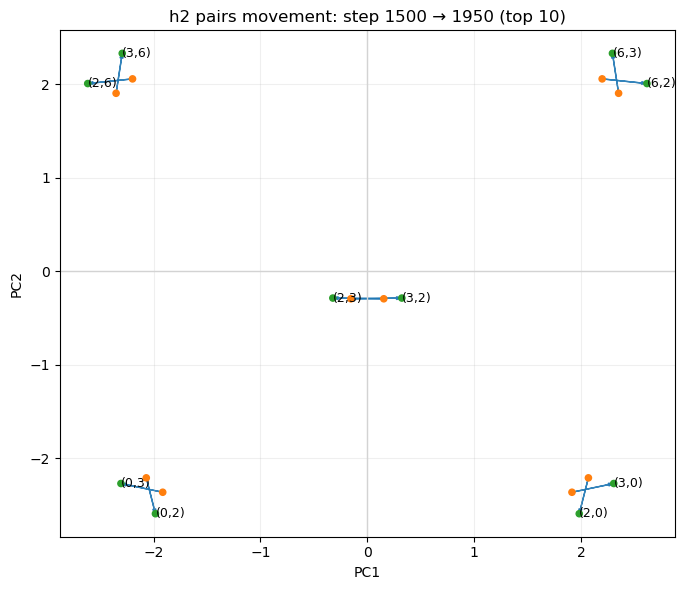

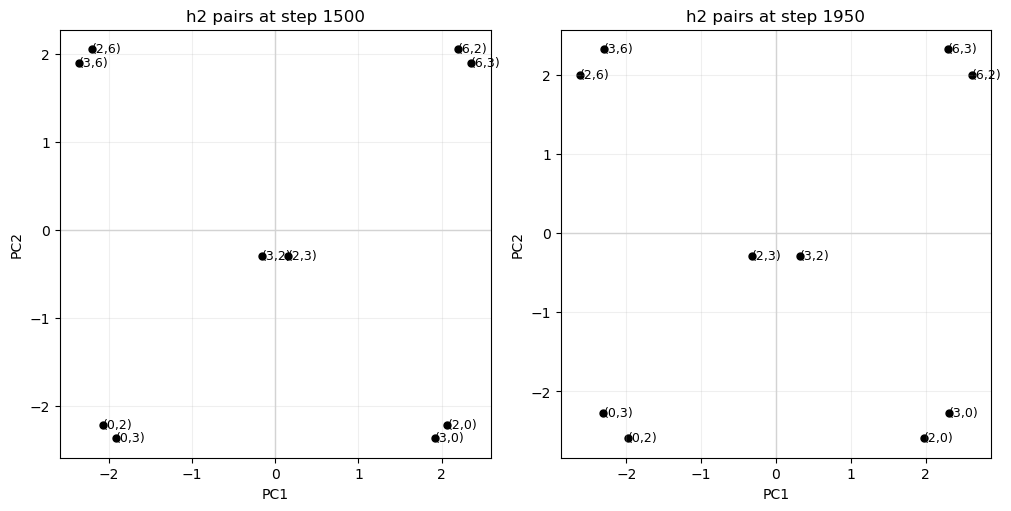

In [ ]:
# h1 pair changes between steps 1500 and 1950: show top-5 moving pairs with arrows
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Prepare h2 data (mean across seeds)
if isinstance(results, tuple):
    results = results[1]
train_dict = results.get("train", {}) if isinstance(results, dict) else {}
if "h1s" not in train_dict or train_dict["h1s"] is None:
    print("No h1s found in results['train'].")
else:
    H2 = train_dict["h1s"]  # (seeds_n, time_steps, items_n, h2_size)
    H2_avg = np.nan_to_num(H2.mean(axis=0), nan=0.0, posinf=0.0, neginf=0.0)  # (time_steps, items_n, h2_size)
    time_steps, items_n_inferred, h2_size = H2_avg.shape

    # Steps of interest (clip to available range)
    step_a = min(1500, time_steps - 1)
    step_b = min(1950, time_steps - 1)

    # Build pair feature vectors by concatenation for all ordered pairs i != j
    def build_pairs(X_items):
        vecs, labels, pairs = [], [], []
        for i in range(items_n_inferred):
            for j in range(items_n_inferred):
                if i == j:
                    continue
                v = np.concatenate([X_items[i], X_items[j]], axis=0)
                vecs.append(v)
                labels.append(f"({i},{j})")
                pairs.append((i, j))
        V = np.asarray(vecs)
        V = V - V.mean(axis=0, keepdims=True)
        return V, labels, pairs

    Xa, la, pa = build_pairs(H2_avg[step_a])
    Xb, lb, pb = build_pairs(H2_avg[step_b])

    # Fit PCA on the union to get a common 2D space
    X_union = np.vstack([Xa, Xb])
    if np.allclose(X_union.var(), 0.0):
        theta = np.linspace(0, 2*np.pi, Xa.shape[0], endpoint=False)
        coords_a = np.stack([np.cos(theta), np.sin(theta)], axis=1)
        coords_b = coords_a.copy()
    else:
        pca = PCA(n_components=2, random_state=mds_seed if 'mds_seed' in globals() else 0)
        coords_union = pca.fit_transform(X_union)
        coords_a = coords_union[:Xa.shape[0]]
        coords_b = coords_union[Xa.shape[0]:]

    # Compute displacements per pair (match by index; la and lb have same ordering)
    deltas = coords_b - coords_a
    move_norm = np.linalg.norm(deltas, axis=1)

    # Select top-5 moving pairs
    top_k = 10
    top_idx = np.argsort(-move_norm)[:top_k]

    # Plot arrows for the top pairs
    plt.figure(figsize=(7, 6))
    ax = plt.gca()
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        dx, dy = deltas[idx]
        x1, y1 = x0 + dx, y0 + dy
        ax.arrow(x0, y0, dx, dy, head_width=0.03, head_length=0.05, length_includes_head=True,
                 fc='C0', ec='C0', alpha=0.9)
        ax.scatter([x0, x1], [y0, y1], s=20, color=['C1','C2'], zorder=3)
        ax.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    ax.set_title(f"h2 pairs movement: step {step_a} → {step_b} (top {top_k})")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.axhline(0, color='lightgray', linewidth=1)
    ax.axvline(0, color='lightgray', linewidth=1)
    ax.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

    # Also provide separate scatter plots for the same 5 pairs at each step (optional clarity)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10., 5.), constrained_layout=True)
    ax1.set_title(f"h2 pairs at step {step_a}")
    ax2.set_title(f"h2 pairs at step {step_b}")
    for idx in top_idx:
        x0, y0 = coords_a[idx]
        x1, y1 = coords_b[idx]
        ax1.scatter(x0, y0, s=25, color='k')
        ax1.text(x0, y0, la[idx], fontsize=9, ha='left', va='center')
        ax2.scatter(x1, y1, s=25, color='k')
        ax2.text(x1, y1, la[idx], fontsize=9, ha='left', va='center')
    for axx in (ax1, ax2):
        axx.axhline(0, color='lightgray', linewidth=1)
        axx.axvline(0, color='lightgray', linewidth=1)
        axx.grid(True, alpha=0.2)
        axx.set_xlabel("PC1")
        axx.set_ylabel("PC2")
    plt.show()


In [ ]:
import numpy as np
import pandas as pd

def load_r_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression="gzip")
    seed_cols = [c for c in df.columns if c.startswith("seed_")]
    steps = np.array(sorted(df["time_step"].unique()))
    items_n = int(df["item"].max()) + 1
    units = int(df["unit"].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, len(steps), items_n, units), dtype=float)
    step_to_idx = {s: k for k, s in enumerate(steps)}
    for _, row in df.iterrows():
        t = int(row["time_step"]); i = int(row["item"]); u = int(row["unit"])
        k = step_to_idx[t]
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, k, i, u] = row[sc]
    return arr, steps  # (seeds, K, items, units), saved time steps

def nearest_index(saved_steps, target_step):
    idx = int(np.argmin(np.abs(saved_steps - target_step)))
    return idx, int(saved_steps[idx])

def print_pair_grid(rvals_1d, name="r1", decimals=3):
    items_n = rvals_1d.shape[0]
    fmt = f"{{:.{decimals}f}}"
    # Build string grid of (r(i), r(j))
    grid = [["" for _ in range(items_n+1)] for _ in range(items_n+1)]
    grid[0][0] = f"{name}(i),{name}(j)"
    for j in range(items_n):
        grid[0][j+1] = str(j)
    for i in range(items_n):
        grid[i+1][0] = str(i)
        for j in range(items_n):
            grid[i+1][j+1] = f"({fmt.format(rvals_1d[i])},{fmt.format(rvals_1d[j])})" 
    # Compute column widths
    col_w = [max(len(row[c]) for row in grid) for c in range(items_n+1)]
    # Print
    for row in grid:
        print("  ".join(cell.ljust(col_w[c]) for c, cell in enumerate(row)))

# Paths to your CSV.GZ (change to relative if needed)
r1_csv_gz = "conjunctive_lazy_rich_r1s.csv.gz"
r2_csv_gz = "conjunctive_lazy_rich_r2s.csv.gz"

# Load and average across seeds; take unit 0 since r1/r2 are scalars
R1_all, steps_r1 = load_r_from_csv_gz(r1_csv_gz)
R2_all, steps_r2 = load_r_from_csv_gz(r2_csv_gz)
R1 = R1_all.mean(axis=0)[..., 0]  # (K, items)
R2 = R2_all.mean(axis=0)[..., 0]  # (K, items)

# Choose a target step (change this as needed)
target_step = 1500

k1, actual1 = nearest_index(steps_r1, target_step)
k2, actual2 = nearest_index(steps_r2, target_step)

print(f"\nGrid of r1 pair values at step {actual1}:")
print_pair_grid(R1[k1], name="r1")

print(f"\nGrid of r2 pair values at step {actual2}:")
print_pair_grid(R2[k2], name="r2")


Grid of r1 pair values at step 1500:
r1(i),r1(j)  0                1               2               3                4               5               6             
0            (-0.417,-0.417)  (-0.417,0.206)  (-0.417,0.572)  (-0.417,-0.531)  (-0.417,0.135)  (-0.417,0.068)  (-0.417,0.069)
1            (0.206,-0.417)   (0.206,0.206)   (0.206,0.572)   (0.206,-0.531)   (0.206,0.135)   (0.206,0.068)   (0.206,0.069) 
2            (0.572,-0.417)   (0.572,0.206)   (0.572,0.572)   (0.572,-0.531)   (0.572,0.135)   (0.572,0.068)   (0.572,0.069) 
3            (-0.531,-0.417)  (-0.531,0.206)  (-0.531,0.572)  (-0.531,-0.531)  (-0.531,0.135)  (-0.531,0.068)  (-0.531,0.069)
4            (0.135,-0.417)   (0.135,0.206)   (0.135,0.572)   (0.135,-0.531)   (0.135,0.135)   (0.135,0.068)   (0.135,0.069) 
5            (0.068,-0.417)   (0.068,0.206)   (0.068,0.572)   (0.068,-0.531)   (0.068,0.135)   (0.068,0.068)   (0.068,0.069) 
6            (0.069,-0.417)   (0.069,0.206)   (0.069,0.572)   (0.069,-0.531)   (

In [ ]:
# Print at standard nine positions (map to nearest saved step)
positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]

def print_all_positions(R, steps, name):
    max_step = int(steps.max())
    for p in positions:
        tgt = int(p * max_step)
        k, actual = nearest_index(steps, tgt)
        print(f"\nGrid of {name} pair values at step {actual} (pos={p:.2f}):")
        print_pair_grid(R[k], name=name)

print_all_positions(R1, steps_r1, "r1")
print_all_positions(R2, steps_r2, "r2")


Grid of r1 pair values at step 0 (pos=0.00):
r1(i),r1(j)  0                1               2               3                4               5               6             
0            (-0.236,-0.236)  (-0.236,0.155)  (-0.236,0.472)  (-0.236,-0.251)  (-0.236,0.084)  (-0.236,0.057)  (-0.236,0.029)
1            (0.155,-0.236)   (0.155,0.155)   (0.155,0.472)   (0.155,-0.251)   (0.155,0.084)   (0.155,0.057)   (0.155,0.029) 
2            (0.472,-0.236)   (0.472,0.155)   (0.472,0.472)   (0.472,-0.251)   (0.472,0.084)   (0.472,0.057)   (0.472,0.029) 
3            (-0.251,-0.236)  (-0.251,0.155)  (-0.251,0.472)  (-0.251,-0.251)  (-0.251,0.084)  (-0.251,0.057)  (-0.251,0.029)
4            (0.084,-0.236)   (0.084,0.155)   (0.084,0.472)   (0.084,-0.251)   (0.084,0.084)   (0.084,0.057)   (0.084,0.029) 
5            (0.057,-0.236)   (0.057,0.155)   (0.057,0.472)   (0.057,-0.251)   (0.057,0.084)   (0.057,0.057)   (0.057,0.029) 
6            (0.029,-0.236)   (0.029,0.155)   (0.029,0.472)   (0.029,-0.

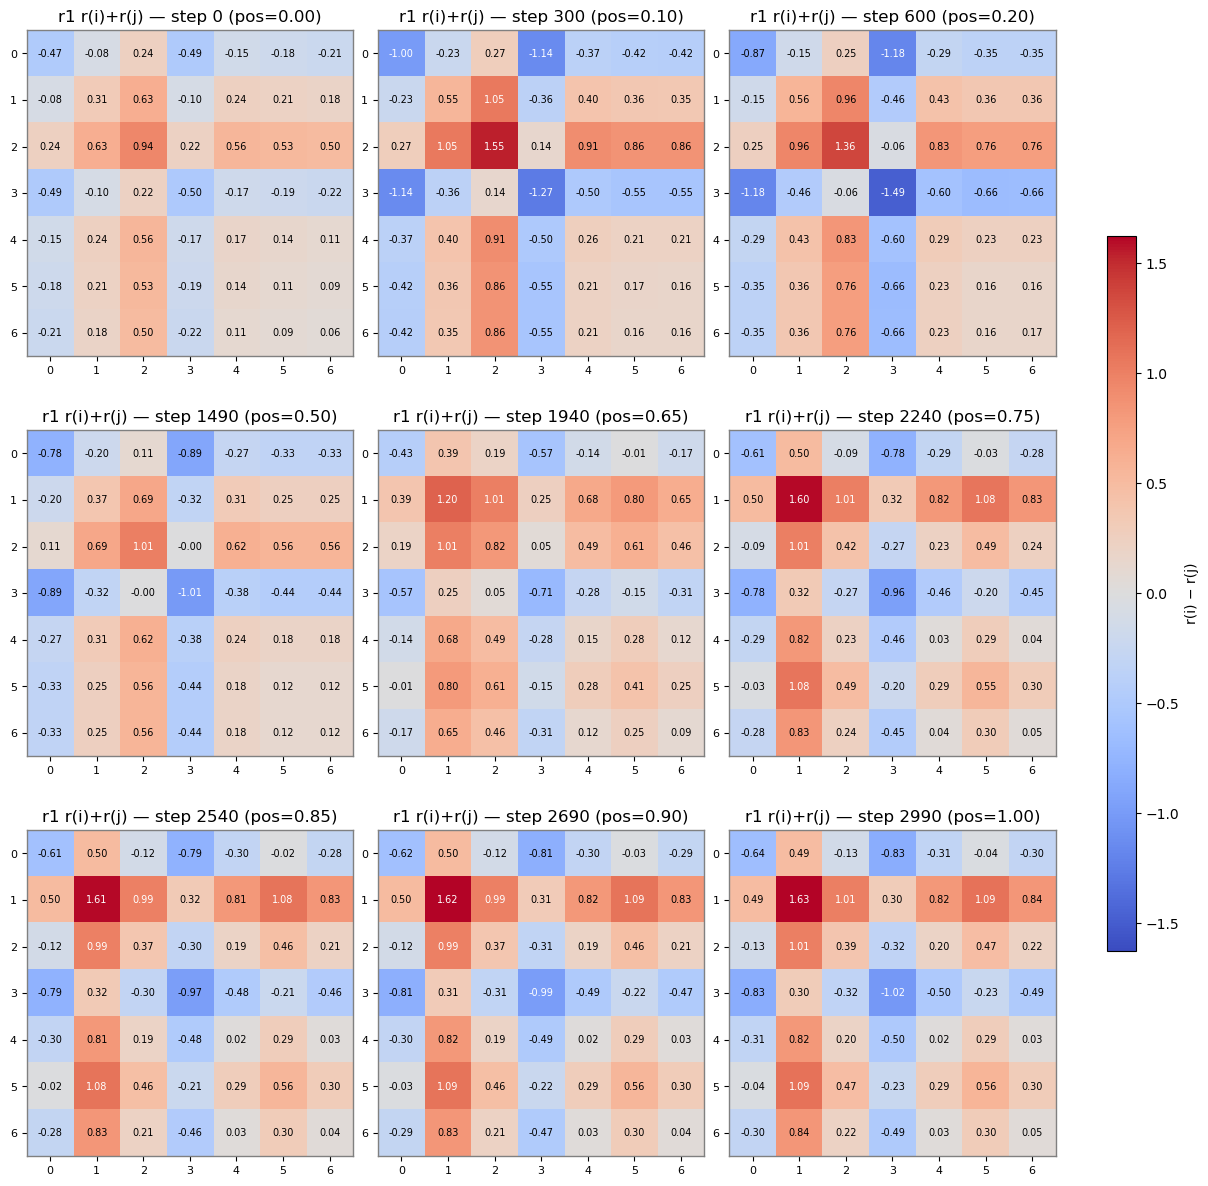

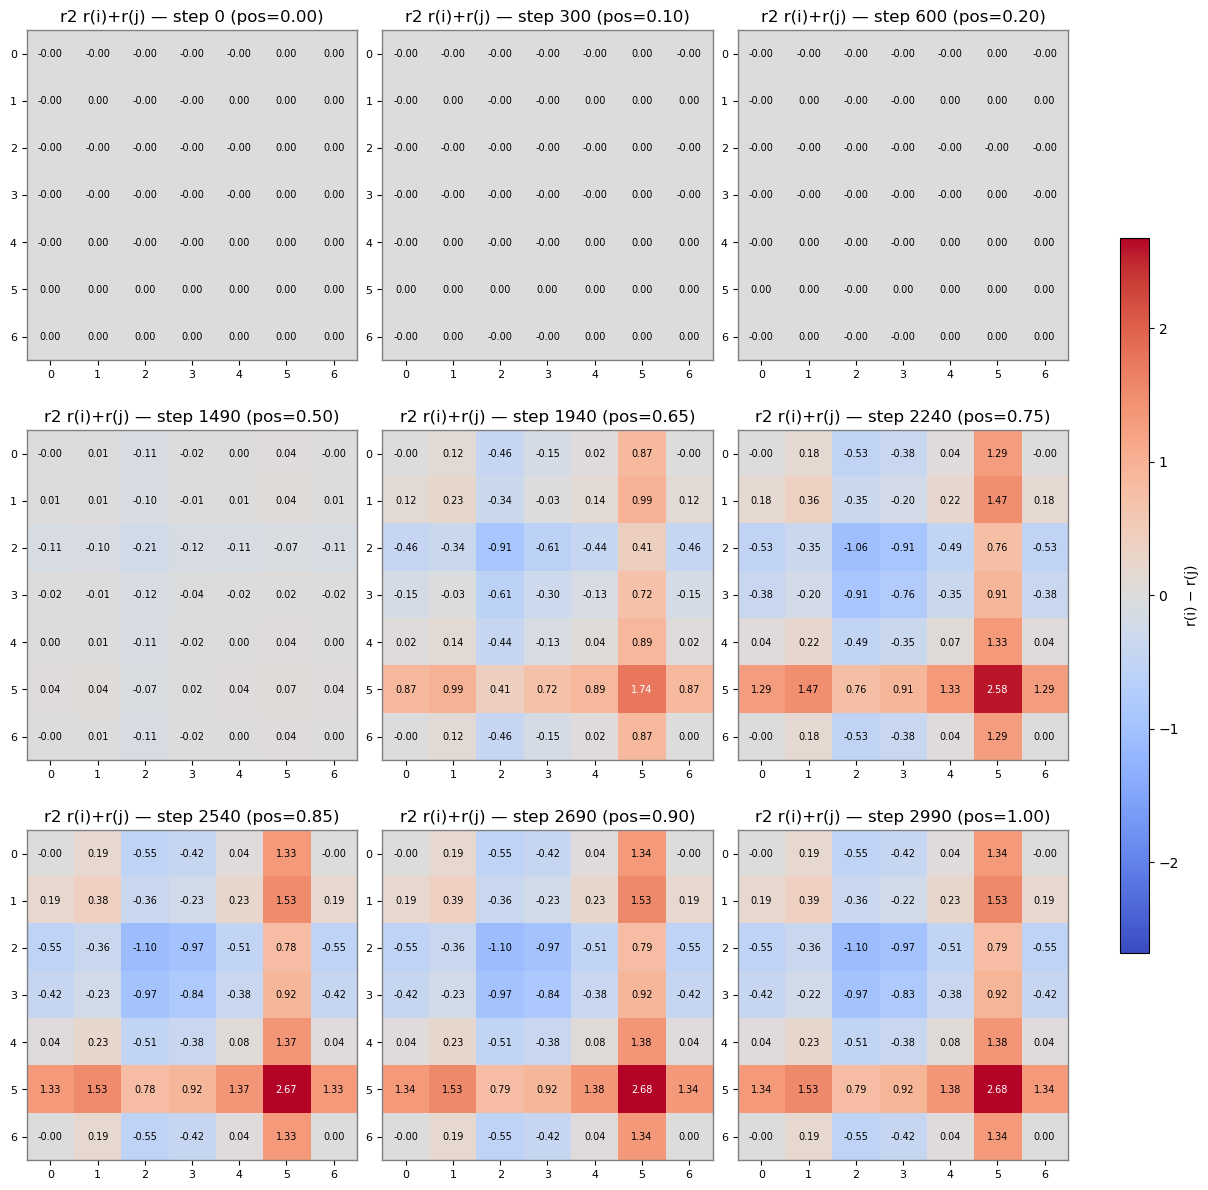

In [ ]:
# Heatmap-style pair grids (like margins) for r1 and r2: cell = r(i) + r(j) with numeric annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_r_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression="gzip")
    seed_cols = [c for c in df.columns if c.startswith("seed_")]
    steps = np.array(sorted(df["time_step"].unique()))
    items_n = int(df["item"].max()) + 1
    units = int(df["unit"].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, len(steps), items_n, units), dtype=float)
    step_to_idx = {s: k for k, s in enumerate(steps)}
    for _, row in df.iterrows():
        t = int(row["time_step"]); i = int(row["item"]); u = int(row["unit"])
        k = step_to_idx[t]
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, k, i, u] = row[sc]
    return arr.mean(axis=0)[..., 0], steps  # (K, items), saved steps

def nearest_index(saved_steps, target_step):
    idx = int(np.argmin(np.abs(saved_steps - target_step)))
    return idx, int(saved_steps[idx])

def plot_readout_heatmaps(R, steps, positions, title_prefix, cmap="coolwarm"):
    # Select slices and determine common color scale across panels
    max_step = int(steps.max())
    sel = [nearest_index(steps, int(p * max_step))[0] for p in positions]
    mats = []
    for k in sel:
        r = R[k]  # shape (items,)
        M = r[:, None] + r[None, :]  # r(i) + r(j)
        mats.append(M)
    all_vals = np.concatenate([m.flatten() for m in mats])
    v = np.max(np.abs(all_vals))
    vmin, vmax = -v, v

    fig, axs = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
    fig.patch.set_facecolor('white')
    im_last = None

    for idx, p in enumerate(positions):
        r, c = divmod(idx, 3)
        k, actual = nearest_index(steps, int(p * max_step))
        M = mats[idx]
        ax = axs[r, c]
        im_last = ax.imshow(M, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
        ax.set_title(f"{title_prefix} r(i)+r(j) — step {actual} (pos={p:.2f})")
        ax.set_xticks(range(M.shape[0])); ax.set_yticks(range(M.shape[0]))
        ax.tick_params(axis='both', labelsize=8)

        # Numeric annotations
        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                val = M[i, j]
                txt = f"{val:.2f}"
                # choose text color based on background
                color = "white" if abs(val) > 0.6 * v else "black"
                ax.text(j, i, txt, ha='center', va='center', fontsize=7, color=color)

        for pos in ["top", "right", "bottom", "left"]:
            ax.spines[pos].set_linewidth(1)
            ax.spines[pos].set_color([0.5] * 3)

    cbar = fig.colorbar(im_last, ax=axs, shrink=.6, aspect=25)
    cbar.set_label("r(i) − r(j)")
    plt.show()

# Load from CSV.GZ saved every 10 steps (adjust paths if needed)
r1_csv_gz = "conjunctive_lazy_rich_r1s.csv.gz"
r2_csv_gz = "conjunctive_lazy_rich_r2s.csv.gz"
R1, steps_r1 = load_r_from_csv_gz(r1_csv_gz)
R2, steps_r2 = load_r_from_csv_gz(r2_csv_gz)

# Same nine positions as other figures
positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]

# Plot 3x3 grids
plot_readout_heatmaps(R1, steps_r1, positions, title_prefix="r1", cmap="coolwarm")
plot_readout_heatmaps(R2, steps_r2, positions, title_prefix="r2", cmap="coolwarm")

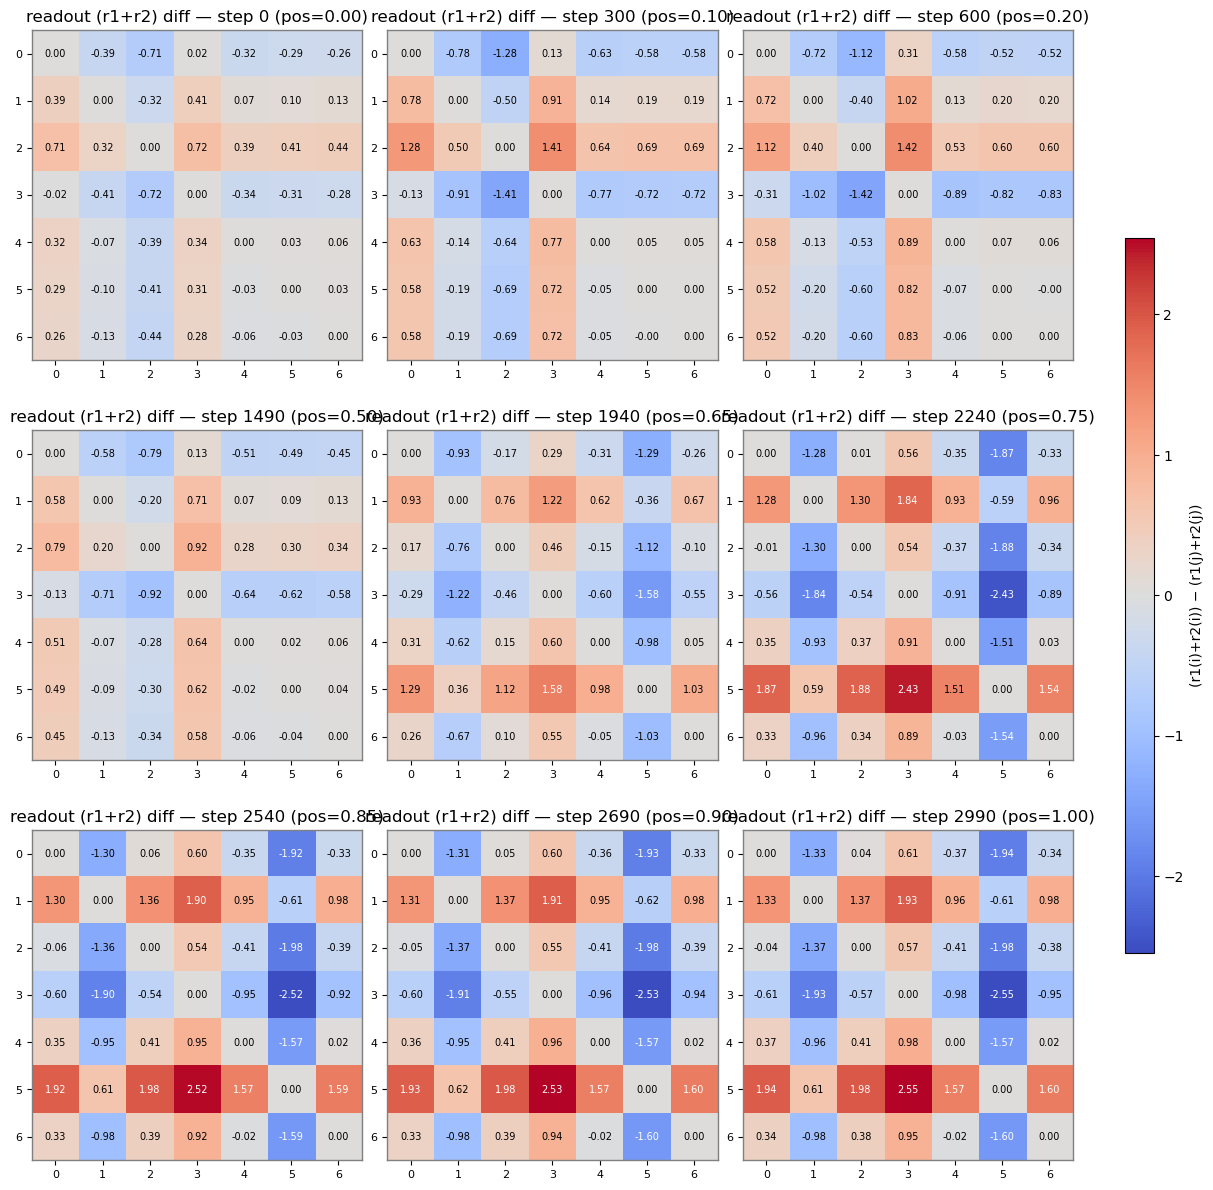

In [ ]:
# Combined readout heatmaps: M(i,j) = (r1(i)+r2(i)) − (r1(j)+r2(j)) across nine positions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_r_from_csv_gz(csv_gz_path):
    df = pd.read_csv(csv_gz_path, compression="gzip")
    seed_cols = [c for c in df.columns if c.startswith("seed_")]
    steps = np.array(sorted(df["time_step"].unique()))
    items_n = int(df["item"].max()) + 1
    units = int(df["unit"].max()) + 1
    seeds_n = len(seed_cols)
    arr = np.zeros((seeds_n, len(steps), items_n, units), dtype=float)
    step_to_idx = {s: k for k, s in enumerate(steps)}
    for _, row in df.iterrows():
        t = int(row["time_step"]); i = int(row["item"]); u = int(row["unit"])
        k = step_to_idx[t]
        for s_idx, sc in enumerate(seed_cols):
            arr[s_idx, k, i, u] = row[sc]
    return arr.mean(axis=0)[..., 0], steps  # (K, items), saved steps

def nearest_index(saved_steps, target_step):
    idx = int(np.argmin(np.abs(saved_steps - target_step)))
    return idx, int(saved_steps[idx])

def plot_combined_heatmaps(R1, steps1, R2, steps2, positions, cmap="coolwarm"):
    # Assume same saved steps for r1 and r2; if not, map positions separately
    max_step = int(min(steps1.max(), steps2.max()))
    idxs = [nearest_index(steps1, int(p * max_step))[0] for p in positions]

    # Build matrices and shared color scale
    mats = []
    for k in idxs:
        S = R1[k] + R2[k]             # combined readout per item
        M = S[:, None] - S[None, :]   # pair matrix
        np.fill_diagonal(M, 0.0)
        mats.append(M)
    all_vals = np.concatenate([m.ravel() for m in mats])
    v = float(np.max(np.abs(all_vals))) if all_vals.size else 1.0
    vmin, vmax = -v, v

    fig, axs = plt.subplots(3, 3, figsize=(12., 12.), constrained_layout=True)
    fig.patch.set_facecolor('white')
    im_last = None

    for idx, p in enumerate(positions):
        r, c = divmod(idx, 3)
        k, actual = nearest_index(steps1, int(p * max_step))
        M = mats[idx]
        ax = axs[r, c]
        im_last = ax.imshow(M, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest')
        ax.set_title(f"readout (r1+r2) diff — step {actual} (pos={p:.2f})")
        ax.set_xticks(range(M.shape[0])); ax.set_yticks(range(M.shape[0]))
        ax.tick_params(axis='both', labelsize=8)

        for i in range(M.shape[0]):
            for j in range(M.shape[1]):
                val = M[i, j]
                color = "white" if v > 0 and abs(val) > 0.6 * v else "black"
                ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=7, color=color)

        for pos in ["top", "right", "bottom", "left"]:
            ax.spines[pos].set_linewidth(1)
            ax.spines[pos].set_color([0.5] * 3)

    cbar = fig.colorbar(im_last, ax=axs, shrink=.6, aspect=25)
    cbar.set_label("(r1(i)+r2(i)) − (r1(j)+r2(j))")
    plt.show()

# Paths to CSV.GZ (adjust if needed)
r1_csv_gz = "conjunctive_lazy_rich_r1s.csv.gz"
r2_csv_gz = "conjunctive_lazy_rich_r2s.csv.gz"

R1, steps_r1 = load_r_from_csv_gz(r1_csv_gz)
R2, steps_r2 = load_r_from_csv_gz(r2_csv_gz)

positions = [0.00, 0.10, 0.20, 0.50, 0.65, 0.75, 0.85, 0.90, 1.00]
plot_combined_heatmaps(R1, steps_r1, R2, steps_r2, positions, cmap="coolwarm")

In [ ]:
pwd

'/mnt/smb/locker/abbott-locker/Luke/Nelli Reimplementation/10.16.25 - Reps_Margins/conjunctive_lazy_rich_1e-5_reps_margins_v2'